# GALAH DR4 Stellar Label Optimisation


In [13]:
# Preamble
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.constants as c
import logging
import time
from pathlib import Path
import pickle
import astropy.units as u
from astropy.table import Table
import scipy.interpolate
from scipy import signal
from scipy.spatial import cKDTree
import scipy.optimize as op
from scipy.ndimage.filters import convolve
from scipy.io import readsav
import thecannon as tc
import emcee
import corner

# Corrections to non-spectroscopic data
from astroquery.gaia import Gaia
from zero_point import zpt
zpt.load_tables()

In [98]:
# Create dictionary for descriptions
description = dict()
description['sobject_id'] = 'GALAH identifier'
description['tmass_id'] = '2MASS identifier'
description['gaia_edr3_source_id'] = 'Gaia DR2 source_id'
description['teff'] = 'Spectroscopic effective temperature'
description['logg'] = 'Surface gravity'
description['fe_h'] = 'Fe abundance [Fe/H] (1D-NLTE)'
description['vmic'] = 'Microturbulence velocity'
description['vsini'] = 'Rotational broadening velocity'
for element in ['Li','C','N','O','Na','Mg','Al','Si','K','Ca','Sc','Ti','V','Cr','Mn','Co','Ni','Cu','Zn','Rb','Sr','Y','Zr','Mo','Ru','Ba','La','Ce','Nd','Sm','Eu']:
    if element in ['Li','C','N','O','Na','Mg','Al','Si','K','Ca','Mn','Ba']:
        lte_nlte = 'NLTE'
    else:
        lte_nlte = 'LTE'        
    description[element.lower()+'_fe'] = element+' abundance ['+element+'/Fe] (1D-'+lte_nlte+')'
description['vrad'] = 'Radial velocity fitted from spectra'
description['distance'] = 'Distance from Sun to star'
description['a_v'] = 'Extinction in V filter'

In [99]:
# Create dictionary for units
units = dict()
for each in description.keys():
    units[each] = ''
    if each in ['sobject_id','tmass_id','gaia_edr3_source_id']:
        pass
    elif each in ['teff']:
        units[each] = 'K'
    elif each in ['logg']:
        units[each] = 'log(cm.s**-2)'
    elif each in ['fe_h']:
        units[each] = 'dex'
    elif each in ['vmic','vsini','vrad']:
        units[each] = 'km s-1'
    elif each[-3:] == '_fe':
        units[each] = 'dex'
    elif each in ['distance']:
        units[each] = 'pc'
    elif each in ['a_v']:
        units[each] = 'mag'
    else:
        print("'"+each+"',")

In [16]:
print("To Do:")
print("Better isochrone set and interpolation routine from Sanjib")
print("Implement some mechanism that checks the ph_qual flag for chi2 and only uses A?")

To Do:
Better isochrone set and interpolation routine from Sanjib
Implement some mechanism that checks the ph_qual flag for chi2 and only uses A?


In [60]:
#sobject_id = 150427000801285 # GRID POINT: 1511 red giant with numax
#sobject_id = 150606003401143
#sobject_id = 170509004701075
sobject_id = 170509004701096 # GRID POINT: 1931 solar twin
#sobject_id = ... Arcturus # GRID POINT: 1259

use_photoastrometry = True
use_asteroseismology = True

debug = False

working_directory = '/Users/svenbuder/GALAH_DR4/'
spectra_directory = working_directory+'observations/'
cannon_model_directory = working_directory+'spectrum_interpolation/TheCannon/models/'

# Get observation and initial parameters

In [61]:
def get_reduction_products(sobject_id, neglect_ir_beginning=True):

    """
    This function collects the spectrum and other reduction products.
    
    INPUT:
    sobject_id: identifier for spectra
    neglect_ir_beginning: Cut away CCD4 information below 7700Å?

    OUTPUT:
    spectrum - dictionary with the following keywords:
    - sobject_id: identifier for GALAH
    - tmass_id: identifier for 2MASS
    - gaia_edr3_source_id: identifier for GaiaEDR3
    - init_teff: Teff value suggested by reduction
    - init_logg: logg value suggested by reduction
    - init_fe_h: [Fe/H] value suggested by reduction
    - init_x_fe: [X/Fe] for alpha-process elements C, O, Mg, Si, Ca, Ti
    - init_vmic: vmic value suggested by reduction
    - init_vsini: vsini value suggested by reduction
    - init_vrad: vrad value suggested by reduction

    """
    spectrum = dict()

    spectrum['sobject_id'] = sobject_id

    fits_file = fits.open(spectra_directory+str(sobject_id)[:6]+'/spectra/com/'+str(sobject_id)+'1.fits')

    spectrum['galah_id'] = fits_file[0].header['GALAH_ID']
    spectrum['tmass_id'] = fits_file[0].header['2MASS_ID']
    spectrum['gaia_edr3_source_id'] = fits_file[0].header['GAIA_ID']

    if fits_file[0].header['PAR_OK']==1:
        
        # TEFF
        spectrum['init_teff'] = fits_file[0].header['TEFF_R']
        if spectrum['init_teff'] < 3000:
            raise ValueError('TEFF < 3000')
        if spectrum['init_teff'] > 8000:
            raise ValueError('TEFF > 8000')
        
        # LOGG
        spectrum['init_logg'] = fits_file[0].header['LOGG_R']
        if spectrum['init_logg'] < -0.5:
            raise ValueError('LOGG < -0.5')
        if spectrum['init_logg'] > 5.5:
            raise ValueError('LOGG > 5.5')
            
        # FE_H
        spectrum['init_fe_h'] = fits_file[0].header['FE_H_R']
        if spectrum['init_fe_h'] < -4.0:
            raise ValueError('LOGG < -4.0')
        if spectrum['init_fe_h'] > 1.0:
            raise ValueError('LOGG > 1.0')
        
        for element in ['Li','C','N','O','Na','Mg','Al','Si','K','Ca','Sc','Ti','V','Cr','Mn','Co','Ni','Cu','Zn','Rb','Sr','Y','Zr','Mo','Ru','Ba','La','Ce','Nd','Sm','Eu']:
            spectrum['init_'+element.lower()+'_fe'] = 0.0

        # ALPHA_FE -> C, O, Si, Mg, Ca, Ti
        for each_alpha in ['c','o','mg','si','ca','ti']:
            spectrum['init_'+each_alpha+'_fe'] = fits_file[0].header['A_FE_R']
            if spectrum['init_'+each_alpha+'_fe'] < -1.0:
                raise ValueError('['+each_alpha+'/Fe] < -1.0')
            if spectrum['init_'+each_alpha+'_fe'] > 1.0:
                raise ValueError('['+each_alpha+'/Fe] > 1.0')
            
        # VMIC
        spectrum['init_vmic'] = fits_file[0].header['VMIC_R']
        
        # VBROAD
        spectrum['init_vsini'] = fits_file[0].header['VBROAD_R']

    else:
        raise ValueError('Reduction parameters not trustworthy!')

    if fits_file[0].header['RVCOM_OK']==1:
        spectrum['init_vrad'] = fits_file[0].header['RVCOM']
    else:
        raise ValueError('RV pipeline did not converge!')

    if fits_file[0].header['WAV_OK']==0:
        raise ValueError('Wavelength solution not ok!')

    if fits_file[0].header['CROSS_OK']==0:
        raise ValueError('Cross-talk not calculated reliably!')

    for ccd in [1,2,3,4]:

        if ccd != 1:
            fits_file = fits.open(spectra_directory+str(sobject_id)[:6]+'/spectra/com/'+str(sobject_id)+str(ccd)+'.fits')

        spectrum['crval_ccd'+str(ccd)] = fits_file[0].header['CRVAL1']
        spectrum['cdelt_ccd'+str(ccd)] = fits_file[0].header['CDELT1']

        spectrum['counts_ccd'+str(ccd)]   = fits_file[0].data
        spectrum['counts_unc_ccd'+str(ccd)] = fits_file[0].data * fits_file[2].data

        spectrum['sky_ccd'+str(ccd)]   = fits_file[3].data
        spectrum['telluric_ccd'+str(ccd)]   = fits_file[4].data

        spectrum['lsf_b_ccd'+str(ccd)] = fits_file[0].header['B']
        spectrum['lsf_ccd'+str(ccd)]   = fits_file[7].data
        
        fits_file.close()

        if (ccd == 4) & neglect_ir_beginning:
            wave_ccd4 = spectrum['crval_ccd4'] + spectrum['cdelt_ccd4'] * np.arange(len(spectrum['counts_ccd4']))
            bad_ir = wave_ccd4 > 7698
            spectrum['crval_ccd4'] = wave_ccd4[bad_ir][0]
            spectrum['counts_ccd4'] = spectrum['counts_ccd4'][bad_ir]
            spectrum['counts_unc_ccd4'] = spectrum['counts_unc_ccd4'][bad_ir]
            spectrum['lsf_ccd4'] = spectrum['lsf_ccd4'][bad_ir]

    return(spectrum)

spectrum = get_reduction_products(sobject_id)

In [62]:
def exchange_with_reliable_galah_dr3_values(spectrum):

    galah_dr3 = Table.read('../auxiliary_information/GALAH_DR3_main_allspec_v2_lite.fits')
    galah_dr3_match = np.where(galah_dr3['sobject_id'] == spectrum['sobject_id'])[0]
    if len(galah_dr3_match) > 0:
        print('Found match in GALAH+ DR3')
        galah_dr3_entry = galah_dr3[galah_dr3_match[0]]

        if galah_dr3_entry['flag_sp'] == 0:
            print('Replacing initial value for Teff, logg, vmic, vsini with GALAH+ DR3 ones.')
            for label in ['teff','logg','vmic','vsini']:
                label2 = label
                if label=='vsini':
                    label2 = 'vbroad'
                print(label+' IRAF 6.0: ',"{:.2f}".format(spectrum['init_'+label]), 'GALAH+ DR3: ',"{:.2f}".format(galah_dr3_entry[label2]))
                spectrum['init_'+label] = galah_dr3_entry[label2]

            if galah_dr3_entry['flag_fe_h'] == 0:
                print('Replacing initial value for [Fe/H] with GALAH+ DR3 ones.')
                print('[Fe/H] IRAF 6.0: ',"{:.2f}".format(spectrum['init_fe_h']), 'GALAH+ DR3: ',"{:.2f}".format(galah_dr3_entry['fe_h']))
                spectrum['init_fe_h'] = galah_dr3_entry['fe_h']

            for element in ['Li','C','O','Na','Mg','Al','Si','K','Ca','Sc','Ti','V','Cr','Mn','Co','Ni','Cu','Zn','Rb','Sr','Y','Zr','Mo','Ru','Ba','La','Ce','Nd','Sm','Eu']:
                if galah_dr3_entry['flag_'+element+'_fe'] == 0:
                    print('['+element+'/Fe] initial value from GALAH+ DR3: '+"{:.2f}".format(galah_dr3_entry[element+'_fe']))

                    spectrum['init_'+element.lower()+'_fe'] = galah_dr3_entry[element+'_fe']

exchange_with_reliable_galah_dr3_values(spectrum)

Found match in GALAH+ DR3
Replacing initial value for Teff, logg, vmic, vsini with GALAH+ DR3 ones.
teff IRAF 6.0:  5628.43 GALAH+ DR3:  5727.23
logg IRAF 6.0:  4.33 GALAH+ DR3:  4.45
vmic IRAF 6.0:  1.11 GALAH+ DR3:  1.14
vsini IRAF 6.0:  4.89 GALAH+ DR3:  5.15
Replacing initial value for [Fe/H] with GALAH+ DR3 ones.
[Fe/H] IRAF 6.0:  -0.03 GALAH+ DR3:  -0.01
[Li/Fe] initial value from GALAH+ DR3: 0.55
[C/Fe] initial value from GALAH+ DR3: -0.01
[O/Fe] initial value from GALAH+ DR3: -0.06
[Na/Fe] initial value from GALAH+ DR3: -0.02
[Mg/Fe] initial value from GALAH+ DR3: -0.00
[Al/Fe] initial value from GALAH+ DR3: 0.03
[Si/Fe] initial value from GALAH+ DR3: 0.01
[K/Fe] initial value from GALAH+ DR3: -0.03
[Ca/Fe] initial value from GALAH+ DR3: -0.01
[Sc/Fe] initial value from GALAH+ DR3: 0.01
[Ti/Fe] initial value from GALAH+ DR3: 0.02
[V/Fe] initial value from GALAH+ DR3: -0.06
[Cr/Fe] initial value from GALAH+ DR3: -0.03
[Mn/Fe] initial value from GALAH+ DR3: 0.01
[Ni/Fe] initial v

In [63]:
# Correction of Gaia Gband magnitude and flux.
# The code is listed in the appendix of Gaia Collaboration et al. (2021), and 
# implements the formulae presented in Riello et al. (2021): https://ui.adsabs.harvard.edu/abs/2021A%26A...649A...3R/abstract
# Code retrieved from https://github.com/agabrown/gaiaedr3-6p-gband-correction/ 

def correct_gband(bp_rp, astrometric_params_solved, phot_g_mean_mag, phot_g_mean_flux):
    """
    Correct the G-band fluxes and magnitudes for the input list of Gaia EDR3 data.
    
    Parameters
    ----------
    
    bp_rp: float, numpy.ndarray
        The (BP-RP) colour listed in the Gaia EDR3 archive.
    astrometric_params_solved: int, numpy.ndarray
        The astrometric solution type listed in the Gaia EDR3 archive.
    phot_g_mean_mag: float, numpy.ndarray
        The G-band magnitude as listed in the Gaia EDR3 archive.
    phot_g_mean_flux: float, numpy.ndarray
        The G-band flux as listed in the Gaia EDR3 archive.
        
    Returns
    -------
    
    The corrected G-band magnitudes and fluxes. The corrections are only applied to
    sources with a 2-paramater or 6-parameter astrometric solution fainter than G=13, 
    for which a (BP-RP) colour is available.
    
    Example
    -------
    
    gmag_corr, gflux_corr = correct_gband(bp_rp, astrometric_params_solved, phot_g_mean_mag, phot_g_mean_flux)
    """

    if np.isscalar(bp_rp) or np.isscalar(astrometric_params_solved) or np.isscalar(phot_g_mean_mag) \
                    or np.isscalar(phot_g_mean_flux):
        bp_rp = np.float64(bp_rp)
        astrometric_params_solved = np.int64(astrometric_params_solved)
        phot_g_mean_mag = np.float64(phot_g_mean_mag)
        phot_g_mean_flux = np.float64(phot_g_mean_flux)
    
    if not (bp_rp.shape == astrometric_params_solved.shape == phot_g_mean_mag.shape == phot_g_mean_flux.shape):
        raise ValueError('Function parameters must be of the same shape!')
    
    do_not_correct = np.isnan(bp_rp) | (phot_g_mean_mag<13) | (astrometric_params_solved == 31)
    bright_correct = np.logical_not(do_not_correct) & (phot_g_mean_mag>=13) & (phot_g_mean_mag<=16)
    faint_correct = np.logical_not(do_not_correct) & (phot_g_mean_mag>16)
    bp_rp_c = np.clip(bp_rp, 0.25, 3.0)
    
    correction_factor = np.ones_like(phot_g_mean_mag)
    correction_factor[faint_correct] = 1.00525 - 0.02323*bp_rp_c[faint_correct] + \
        0.01740*np.power(bp_rp_c[faint_correct],2) - 0.00253*np.power(bp_rp_c[faint_correct],3)
    correction_factor[bright_correct] = 1.00876 - 0.02540*bp_rp_c[bright_correct] + \
        0.01747*np.power(bp_rp_c[bright_correct],2) - 0.00277*np.power(bp_rp_c[bright_correct],3)
    
    gmag_corrected = phot_g_mean_mag - 2.5*np.log10(correction_factor)
    gflux_corrected = phot_g_mean_flux * correction_factor
    
    return gmag_corrected, gflux_corrected

In [64]:
def get_non_spec_info(spectrum, use_photoastrometry, use_asteroseismology):
    """
    Get the non-spectroscopic information from the auxiliary information.
    X-matches to 2MASS, Gaia eDR3, and K2
    
    INPUT:
    spectrum dictionary with sobject_id and gaia_edr_source_id keywords
    use_photoastrometry : True/False statement to use Gaia+2MASS+WISE photometry (g_bp, ks_m, W2, etc.) + Gaia astrometry (parallax)
    use_asteroseismology : True/False statement to use asteroseismology (nu_max and delta_nu)
    
    OUTPUT:
    dictionary with the important information
    from Gaia eDR3, 2MASS, WISE, and K2 (if available)
    """

    non_spec_info = dict()
    non_spec_info['sobject_id'] = spectrum['sobject_id']
    non_spec_info['tmass_id'] = spectrum['tmass_id']
    non_spec_info['gaia_edr3_source_id'] = spectrum['gaia_edr3_source_id']

    print('Matching with Gaia eDR3 and 2MASS via TAP query')
    if use_photoastrometry:
        
        # Query to get Gaia eDR3 and 2MASS information.
        # At the moment, we do not match with other surveys, but we easily could, as indicated below
        
        if sobject_id == 150606003401143:
            adql = [
                'SELECT TOP 10',
                'gaia_edr3.ruwe, gaia_edr3.astrometric_params_solved, gaia_edr3.nu_eff_used_in_astrometry, gaia_edr3.pseudocolour, gaia_edr3.ecl_lat,',
                'gaia_edr3.bp_rp, gaia_edr3.phot_g_mean_mag, gaia_edr3.phot_bp_mean_mag, gaia_edr3.phot_rp_mean_mag,',
                'gaia_edr3.phot_g_mean_flux, gaia_edr3.phot_bp_mean_flux, gaia_edr3.phot_rp_mean_flux,',
                'gaia_edr3.phot_g_mean_flux_error, gaia_edr3.phot_bp_mean_flux_error, gaia_edr3.phot_rp_mean_flux_error,',
                'gaia_edr3.parallax, gaia_edr3.parallax_error,',
                'gaia_edr3.dr2_radial_velocity, gaia_edr3.dr2_radial_velocity_error',
                #'tmass.designation as tmass_id,',
                #'tmass.ph_qual as ph_qual_tmass,',
                #'tmass.j_m, tmass.j_msigcom,',
                #'tmass.h_m, tmass.h_msigcom,',
                #'tmass.ks_m, tmass.ks_msigcom',
                'FROM gaiaedr3.gaia_source as gaia_edr3',
                #'INNER JOIN tmass_psc_xsc_best_neighbour as tmass_xmatch',
                #'ON gaia_edr3.source_id = tmass_xmatch.source_id',
                #'INNER JOIN gaiadr1.tmass_original_valid as tmass',
                #'ON tmass.designation = tmass_xmatch.original_ext_source_id',
                # We could extend to use of Allwise (but check multiple keywords like ph_qual)
                #'INNER JOIN gaiaedr3.allwise_best_neighbour as allwise_xmatch',
                #'ON gaia_edr3.source_id = allwise_xmatch.source_id',
                #'INNER JOIN gaiadr1.allwise_original_valid as allwise',
                #'ON allwise.allwise_oid = allwise_xmatch.allwise_oid',
                'WHERE gaia_edr3.source_id = '+str(spectrum['gaia_edr3_source_id'])
            ]
        else:
            adql = [
                'SELECT TOP 10',
                'gaia_edr3.ruwe, gaia_edr3.astrometric_params_solved, gaia_edr3.nu_eff_used_in_astrometry, gaia_edr3.pseudocolour, gaia_edr3.ecl_lat,',
                'gaia_edr3.bp_rp, gaia_edr3.phot_g_mean_mag, gaia_edr3.phot_bp_mean_mag, gaia_edr3.phot_rp_mean_mag,',
                'gaia_edr3.phot_g_mean_flux, gaia_edr3.phot_bp_mean_flux, gaia_edr3.phot_rp_mean_flux,',
                'gaia_edr3.phot_g_mean_flux_error, gaia_edr3.phot_bp_mean_flux_error, gaia_edr3.phot_rp_mean_flux_error,',
                'gaia_edr3.parallax, gaia_edr3.parallax_error,',
                'gaia_edr3.dr2_radial_velocity, gaia_edr3.dr2_radial_velocity_error,',
                'tmass.designation as tmass_id,',
                'tmass.ph_qual as ph_qual_tmass,',
                'tmass.j_m, tmass.j_msigcom,',
                'tmass.h_m, tmass.h_msigcom,',
                'tmass.ks_m, tmass.ks_msigcom',
                'FROM gaiaedr3.gaia_source as gaia_edr3',
                'INNER JOIN tmass_psc_xsc_best_neighbour as tmass_xmatch',
                'ON gaia_edr3.source_id = tmass_xmatch.source_id',
                'INNER JOIN gaiadr1.tmass_original_valid as tmass',
                'ON tmass.designation = tmass_xmatch.original_ext_source_id',
                # We could extend to use of Allwise (but check multiple keywords like ph_qual)
                #'INNER JOIN gaiaedr3.allwise_best_neighbour as allwise_xmatch',
                #'ON gaia_edr3.source_id = allwise_xmatch.source_id',
                #'INNER JOIN gaiadr1.allwise_original_valid as allwise',
                #'ON allwise.allwise_oid = allwise_xmatch.allwise_oid',
                'WHERE gaia_edr3.source_id = '+str(spectrum['gaia_edr3_source_id'])
            ]

        try:
            job = Gaia.launch_job(' '.join(adql))
            adql_result = job.get_results()
        except:
            print(' '.join(adql))
            raise ValueError('No match with via gaiaedr3.source_id found')

        if np.shape(adql_result)[0] > 1:
            print(' '.join(adql))
            raise ValueError('More than 1 match with via gaiaedr3.source_id found')

        # Prepare the photometric information from Gaia eDR3
        Gmag, FG = correct_gband(
            bp_rp = adql_result['bp_rp'][0], 
            astrometric_params_solved = adql_result['astrometric_params_solved'][0], 
            phot_g_mean_mag = adql_result['phot_g_mean_mag'][0], 
            phot_g_mean_flux = adql_result['phot_g_mean_flux'][0]
        )
        non_spec_info['gmag_gaia_edr3'] = Gmag * u.mag
        non_spec_info['gbpmag_gaia_edr3'] = adql_result['phot_bp_mean_mag'][0] * u.mag
        non_spec_info['grpmag_gaia_edr3'] = adql_result['phot_rp_mean_mag'][0] * u.mag

        # Calculation of Gaia eDR3 G/GBP/GRP uncertainties:
        # See both https://www.cosmos.esa.int/web/gaia/edr3-passbands
        # and https://cdsarc.unistra.fr/viz-bin/ReadMe/I/350?format=html&tex=true#sRM3.63
        sigmaG_0 = 0.0027553202
        sigmaGBP_0 = 0.0027901700
        sigmaGRP_0 = 0.0037793818
        non_spec_info['e_gmag_gaia_edr3']   = np.sqrt((-2.5/np.log(10)*adql_result['phot_g_mean_flux_error'][0]/FG)**2 + sigmaG_0**2) * u.mag
        non_spec_info['e_gbpmag_gaia_edr3'] = np.sqrt((-2.5/np.log(10)*adql_result['phot_bp_mean_flux_error'][0]/adql_result['phot_bp_mean_flux'][0])**2 + sigmaGBP_0**2) * u.mag
        non_spec_info['e_grpmag_gaia_edr3'] = np.sqrt((-2.5/np.log(10)*adql_result['phot_rp_mean_flux_error'][0]/adql_result['phot_rp_mean_flux'][0])**2 + sigmaGRP_0**2) * u.mag

        # Calculations of Parallax Zeropoint Corrections:
        # Following script by Lindegren et al. (2021b)
        # https://ui.adsabs.harvard.edu/abs/2021A&A...649A...4L
        if adql_result['astrometric_params_solved'][0] in [31,95]:
            # Parallax zeropoint corretion for 
            parallax_zeropoint_correction = zpt.get_zpt(
                phot_g_mean_mag = adql_result['phot_g_mean_mag'][0],
                nu_eff_used_in_astrometry = adql_result['nu_eff_used_in_astrometry'][0],
                pseudocolour = adql_result['pseudocolour'][0],
                ecl_lat = adql_result['ecl_lat'][0],
                astrometric_params_solved = adql_result['astrometric_params_solved'][0]
            )
        else:
            parallax_zeropoint_correction = 0.

        if np.isfinite(adql_result['dr2_radial_velocity_error'][0]):
            non_spec_info['rv_gaia_edr3'] = adql_result['dr2_radial_velocity'][0] * u.km/u.s
            non_spec_info['e_rv_gaia_edr3'] = adql_result['dr2_radial_velocity_error'][0] * u.km/u.s
        else:
            non_spec_info['rv_gaia_edr3'] = np.nan
            non_spec_info['e_rv_gaia_edr3'] = np.nan

        non_spec_info['ruwe_gaia_edr3'] = adql_result['ruwe'][0]
        
        non_spec_info['parallax_raw_gaia_edr3'] = adql_result['parallax'][0] * u.mas
        non_spec_info['parallax_gaia_edr3'] = (adql_result['parallax'][0] - parallax_zeropoint_correction) * u.mas
        non_spec_info['e_parallax_gaia_edr3'] = adql_result['parallax_error'][0] * u.mas
        
        non_spec_info['parallax'] = non_spec_info['parallax_gaia_edr3']
        non_spec_info['e_parallax'] = non_spec_info['e_parallax_gaia_edr3']

        # Check entries in open cluster catalog by Cantat-Gaudin et al., 2020, A&A 640, 1
        cantatgaudin2020_parallaxes = Table.read('../auxiliary_information/CantatGaudin_2020_AandA_640_1.fits')
        cantatgaudin2020_match = np.where(spectrum['gaia_edr3_source_id'] == cantatgaudin2020_parallaxes['GaiaDR2'])[0]
        # If there is an entry in this catalog
        if len(cantatgaudin2020_match) > 0:
            non_spec_info['parallax_cg2020'] = cantatgaudin_parallaxes['plx'][cantatgaudin2020_match[0]]
            non_spec_info['e_parallax_cg2020'] = cantatgaudin_parallaxes['e_plx'][cantatgaudin2020_match[0]]
            # replace parallax to be used, if Cantat-Gaudin et al. parallax has smaller uncertainty
            if non_spec_info['e_parallax_cg2020'] < non_spec_info['e_parallax']:
                print('Open cluster entry by Cantat-Gaudin et al. (2020) more precise')
                non_spec_info['parallax'] = non_spec_info['parallax_cg2020']
                non_spec_info['e_parallax'] = non_spec_info['e_parallax_cg2020']
            else:
                print('Open cluster entry by Cantat-Gaudin et al. (2020) less precise')
        else:
            print('No entry in Cantat-Gaudin et al. (2020) found')

        # Check entries in open cluster catalog by Cantat-Gaudin et al., 2020, A&A 640, 1
        vasiliev2021_parallaxes = Table.read('../auxiliary_information/VasilievBaumgardt_2021_MNRAS_505_5978_8GCs_70percent.fits')
        vasiliev2021_match = np.where(spectrum['gaia_edr3_source_id'] == vasiliev2021_parallaxes['source_id'])[0]
        # If there is an entry in this catalog
        if len(vasiliev2021_match) > 0:
            if vasiliev2021_parallaxes['cluster'][vasiliev2021_match[0]] == 'NGC_104_47Tuc':
                non_spec_info['parallax_vb21'] = 0.232 * u.mas
                non_spec_info['e_parallax_vb21'] = 0.009 * u.mas
            if vasiliev2021_parallaxes['cluster'][vasiliev2021_match[0]] == 'NGC_288':
                non_spec_info['parallax_vb21'] = 0.141 * u.mas
                non_spec_info['e_parallax_vb21'] = 0.011 * u.mas
            if vasiliev2021_parallaxes['cluster'][vasiliev2021_match[0]] == 'NGC_362':
                non_spec_info['parallax_vb21'] = 0.114 * u.mas
                non_spec_info['e_parallax_vb21'] = 0.011 * u.mas
            if vasiliev2021_parallaxes['cluster'][vasiliev2021_match[0]] == 'NGC_1851':
                non_spec_info['parallax_vb21'] = 0.088 * u.mas
                non_spec_info['e_parallax_vb21'] = 0.011 * u.mas
            if vasiliev2021_parallaxes['cluster'][vasiliev2021_match[0]] == 'NGC_5139_oCen':
                non_spec_info['parallax_vb21'] = 0.193 * u.mas
                non_spec_info['e_parallax_vb21'] = 0.009 * u.mas
            if vasiliev2021_parallaxes['cluster'][vasiliev2021_match[0]] == 'NGC_6362':
                non_spec_info['parallax_vb21'] = 0.136 * u.mas
                non_spec_info['e_parallax_vb21'] = 0.010 * u.mas
            if vasiliev2021_parallaxes['cluster'][vasiliev2021_match[0]] == 'NGC_6397':
                non_spec_info['parallax_vb21'] = 0.416 * u.mas
                non_spec_info['e_parallax_vb21'] = 0.010 * u.mas
            if vasiliev2021_parallaxes['cluster'][vasiliev2021_match[0]] == 'NGC_7099_M_30':
                non_spec_info['parallax_vb21'] = 0.136 * u.mas
                non_spec_info['e_parallax_vb21'] = 0.011 * u.mas
            
            # replace parallax to be used, if Cantat-Gaudin et al. parallax has smaller uncertainty
            if non_spec_info['e_parallax_vb21'] < non_spec_info['e_parallax']:
                print('Globular cluster entry by Vasiliev & Baumgardt (2021) more precise')
                non_spec_info['parallax'] = non_spec_info['parallax_vb21']
                non_spec_info['e_parallax'] = non_spec_info['e_parallax_vb21']
            else:
                print('Globular cluster entry by Vasiliev & Baumgardt (2021) less precise')
        else:
            print('No entry in Vasiliev & Baumgardt (2021) found')
                
        if spectrum['tmass_id'] == '16103957-2602249':
            non_spec_info['ph_qual_tmass'] = 'AAA'
            non_spec_info['jmag_tmass'] = 7.996 * u.mag
            non_spec_info['e_jmag_tmass'] = 0.026 * u.mag
            non_spec_info['hmag_tmass'] = 7.431 * u.mag
            non_spec_info['e_hmag_tmass'] = 0.038 * u.mag
            non_spec_info['ksmag_tmass'] = 7.265 * u.mag
            non_spec_info['e_ksmag_tmass'] = 0.016 * u.mag

        else:
            #Prepare the photometric information from 2MASS
            if spectrum['tmass_id'] != str(adql_result['tmass_id'][0])[2:-1]:
                print(' '.join(adql))
                print('GALAH internal 2MASS ID', spectrum['tmass_id'])
                print('Gaia eDR3 matched  2MASS ID', str(adql_result['tmass_id'][0])[2:-1])
                raise ValueError('Gaia eDR3 crossmatch to 2MASS is not consistent with our 2MASS ID')

            non_spec_info['ph_qual_tmass'] = str(adql_result['ph_qual_tmass'][0])[2:-1]
            non_spec_info['jmag_tmass'] = adql_result['j_m'][0] * u.mag
            non_spec_info['e_jmag_tmass'] = adql_result['j_msigcom'][0] * u.mag
            non_spec_info['hmag_tmass'] = adql_result['h_m'][0] * u.mag
            non_spec_info['e_hmag_tmass'] = adql_result['h_msigcom'][0] * u.mag
            non_spec_info['ksmag_tmass'] = adql_result['ks_m'][0] * u.mag
            non_spec_info['e_ksmag_tmass'] = adql_result['ks_msigcom'][0] * u.mag

    if use_asteroseismology:
        # information from K2
        K2 = Table.read('../auxiliary_information/Zinn_Table2_eDR3_xmatch.fits')
        match = np.where(K2['source_id'] == non_spec_info['gaia_edr3_source_id'])[0]
    
        if len(match) > 0:
            if len(match) > 1:
                print('Multiple matches between K2 and Gaia eDR3 found!')

            non_spec_info['epic_id'] = K2['epic_id'][match[0]]

            non_spec_info['nu_max'] = K2['numax_mean'][match[0]] * u.microHertz
            if np.isfinite(K2['numax_scatter'][match[0]]):
                non_spec_info['e_nu_max'] = K2['numax_scatter'][match[0]] * u.microHertz
            else:
                print('No uncertainty for nu_max value')
                non_spec_info['e_nu_max'] = np.nan

            non_spec_info['delta_nu'] = K2['dnu_mean_corr'][match[0]] * u.microHertz
            if np.isfinite(K2['dnu_mean_corr'][match[0]]):
                non_spec_info['e_delta_nu'] = K2['dnu_mean_corr'][match[0]] * u.microHertz
            else:
                print('No uncertainty for delta_nu value')
                non_spec_info['e_delta_nu'] = np.nan
        else:
            raise ValueError('No match with K2 asteroseismic table found!')

    return(non_spec_info)

non_spec_info = get_non_spec_info(spectrum, use_photoastrometry=True, use_asteroseismology=True)

Matching with Gaia eDR3 and 2MASS via TAP query
No entry in Cantat-Gaudin et al. (2020) found
No entry in Vasiliev & Baumgardt (2021) found


ValueError: No match with K2 asteroseismic table found!

In [ ]:
# Read in isochrone grid and trained nearest neighbor search machinery 'kdtree'
# parsec = Table.read('../auxiliary_information/parsec_isochrones/parsec_isochrones_logt_6p19_0p01_10p17_mh_m2p75_0p25_m0p75_mh_m0p60_0p10_0p70_GaiaEDR3_2MASS.fits')
# parsec = Table.read('../auxiliary_information/parsec_isochrones/parsec_isochrones_logt_6p19_0p01_10p17_mh_m2p75_0p25_1p00_mh_m0p75_0p05_0p75_GaiaEDR3_2MASS.fits')
# file = open('../auxiliary_information/parsec_isochrones/isochrone_kdtree_Teff_logg_M_H.pickle','rb')
# parsec_kdtree = pickle.load(file)
# file.close()

In [ ]:
# Load CANNON Models
cannon_models = Table.read(cannon_model_directory+'Cannon_subgrid.fits')
cannon_index_tree = cKDTree(np.c_[cannon_models['teff'],cannon_models['logg'],cannon_models['fe_h']])

default_model_name = '../spectrum_interpolation/TheCannon/models/galah_dr4_thecannon_model_5750_4.50_0.00_order2_36labels.model'
default_model = tc.CannonModel.read(default_model_name)

In [ ]:
# Load Spectrum masks
masks = Table.read('spectrum_masks/solar_spectrum_mask.fits')

# Adjustment functions for model

In [ ]:
def galah_kern(fwhm, b):
    """ Returns a normalized 1D kernel as is used for GALAH resolution profile """
    size=2*(fwhm/2.355)**2
    size_grid = int(size) # we limit the size of kernel, so it is as small as possible (or minimal size) for faster calculations
    if size_grid<7: size_grid=7
    x= scipy.mgrid[-size_grid:size_grid+1]
    g = scipy.exp(-0.693147*np.power(abs(2*x/fwhm), b))
    return g / np.sum(g)

In [ ]:
def synth_resolution_degradation(l, res_map, res_b, synth, synth_res=300000.0):
    """
    Take a synthetic spectrum with a very high  resolution and degrade its resolution to the resolution profile of the observed spectrum. The synthetic spectrum should not be undersampled, or the result of the convolution might be wrong.
    Parameters:
        synth np array or similar: an array representing the synthetic spectrum. Must have size m x 2. First column is the wavelength array, second column is the flux array. Resolution of the synthetic spectrum must be constant and higher than that of the observed spectrum.
        synth_res (float): resolving power of the synthetic spectrum
    Returns:
        Convolved syntehtic spectrum as a np array of size m x 2.
    """

    synth=np.array(synth)
    l_original=synth[:,0]
    #check if the shape of the synthetic spectrum is correct
    if synth.shape[1]!=2: logging.error('Syntehtic spectrum must have shape m x 2.')

    #check if the resolving power is high enough
    sigma_synth=synth[:,0]/synth_res
    if max(sigma_synth)>=min(res_map)*0.95: logging.error('Resolving power of the synthetic spectrum must be higher.')
        
    #check if wavelength calibration of the synthetic spectrum is linear:
    if not (synth[:,0][1]-synth[:,0][0])==(synth[:,0][-1]-synth[:,0][-2]):
        logging.error('Synthetic spectrum must have linear (equidistant) sampling.')		

    #current sampling:
    sampl=synth[:,0][1]-synth[:,0][0]
    galah_sampl=l[1]-l[0]

    #original sigma
    s_original=sigma_synth

    #required sigma (resample the resolution map into the wavelength range of the synthetic spectrum)
    s_out=np.interp(synth[:,0], l, res_map)

    #the sigma of the kernel is:
    s=np.sqrt(s_out**2-s_original**2)

    #fit it with the polynomial, so we have a function instead of sampled values:
    map_fit=np.poly1d(np.polyfit(synth[:,0], s, deg=6))

    #create an array with new sampling. The first point is the same as in the spectrum:
    l_new=[synth[:,0][0]]

    #oversampling. If synthetic spectrum sampling is much finer than the size of the kernel, the code would work, but would return badly sampled spectrum. this is because from here on the needed sampling is measured in units of sigma.
    oversample=galah_sampl/sampl*5.0

    #minimal needed sampling
    min_sampl=max(s_original)/sampl/sampl*oversample

    #keep adding samples until end of the wavelength range is reached
    while l_new[-1]<synth[:,0][-1]+sampl:
        l_new.append(l_new[-1]+map_fit(l_new[-1])/sampl/min_sampl)

    #interpolate the spectrum to the new sampling:
    new_f=np.interp(np.array(l_new),synth[:,0],synth[:,1])

    kernel_=galah_kern(max(s_original)/sampl*oversample, res_b)

    con_f=signal.fftconvolve(new_f,kernel_,mode='same')

    #inverse the warping:
    synth[:,1]=np.interp(l_original,np.array(l_new),con_f)
    return synth.T

In [ ]:
def cubic_spline_interpolate(old_wavelength, old_flux, new_wavelength):
    """
    INPUT:
    old_wavelength, old_flux: Input spectrum that has to be interpolated
    new_wavelength: Wavelength array onto which we want to interpolate
    
    OUTPUT:
    flux interpolated on new_wavelength array
    """
    return scipy.interpolate.CubicSpline(old_wavelength, old_flux)(new_wavelength)

In [ ]:
def gaussbroad(w, s, hwhm):
    """
    Smooths a spectrum by convolution with a gaussian of specified hwhm.
    Parameters
    -------
    w : array[n]
        wavelength scale of spectrum to be smoothed
    s : array[n]
        spectrum to be smoothed
    hwhm : float
        half width at half maximum of smoothing gaussian.
    Returns
    -------
    sout: array[n]
        the gaussian-smoothed spectrum.
    """
    """
    History
    --------
        Dec-90 GB,GM
            Rewrote with fourier convolution algorithm.
        Jul-91 AL
            Translated from ANA to IDL.
        22-Sep-91 JAV
            Relaxed constant dispersion check# vectorized, 50% faster.
        05-Jul-92 JAV
            Converted to function, handle nonpositive hwhm.
        Oct-18 AW
            Python version
    """

    # Warn user if hwhm is negative.
    if hwhm < 0:
        logger.warning("Forcing negative smoothing width to zero.")

    # Return input argument if half-width is nonpositive.
    if hwhm <= 0:
        return s  # true: no broadening

    # Calculate (uniform) dispersion.
    nw = len(w)  ## points in spectrum
    wrange = w[-1] - w[0]
    dw = wrange / (nw - 1)  # wavelength change per pixel

    # Make smoothing gaussian# extend to 4 sigma.
    # 4.0 / sqrt(2.0*alog(2.0)) = 3.3972872 and sqrt(alog(2.0))=0.83255461
    # sqrt(alog(2.0)/pi)=0.46971864 (*1.0000632 to correct for >4 sigma wings)
    if hwhm >= 5 * wrange:
        return np.full(nw, np.sum(s) / nw)
    nhalf = int(3.3972872 * hwhm / dw)  ## points in half gaussian
    ng = 2 * nhalf + 1  ## points in gaussian (odd!)
    wg = dw * (
        np.arange(ng, dtype=float) - (ng - 1) / 2
    )  # wavelength scale of gaussian
    xg = (0.83255461 / hwhm) * wg  # convenient absisca
    gpro = (0.46974832 * dw / hwhm) * np.exp(-xg * xg)  # unit area gaussian w/ FWHM
    gpro = gpro / np.sum(gpro)

    # Pad spectrum ends to minimize impact of Fourier ringing.
    sout = convolve(s, gpro, mode="nearest")

    return sout

In [65]:
def apply_gauss_broad(wave, smod, ipres=30000, debug=True):
    # Apply Gaussian Instrument Broadening
    if ipres == 0.0:
        hwhm = 0
    else:
        hwhm = 0.5 * wave[0] / ipres
    if hwhm > 0: smod = gaussbroad(wave, smod, hwhm)

    return(smod)

In [66]:
def sclip(p,fit,n,ye=[],sl=99999,su=99999,min=0,max=0,min_data=1,grow=0,global_mask=None,verbose=True):
    """
    p: array of coordinate vectors. Last line in the array must be values that are fitted. The rest are coordinates.
    fit: name of the fitting function. It must have arguments x,y,ye,and mask and return an array of values of the fitted function at coordinates x
    n: number of iterations
    ye: array of errors for each point
    sl: lower limit in sigma units
    su: upper limit in sigma units
    min: number or fraction of rejected points below the fitted curve
    max: number or fraction of rejected points above the fitted curve
    min_data: minimal number of points that can still be used to make a constrained fit
    global_mask: if initial mask is given it will be used throughout the whole fitting process, but the final fit will be evaluated also in the masked points
    grow: number of points to reject around the rejected point.
    verbose: print the results or not
    """

    nv,dim=np.shape(p)

    #if error vector is not given, assume errors are equal to 0:
    if ye==[]: ye=np.zeros(dim)
    #if a single number is given for y errors, assume it means the same error is for all points:
    if isinstance(ye, (int, float)): ye=np.ones(dim)*ye

    if global_mask==None: global_mask=np.ones(dim, dtype=bool)
    else: pass

    f_initial=fit(p,ye,global_mask)
    s_initial=np.std(p[-1]-f_initial)

    f=f_initial
    s=s_initial

    tmp_results=[]

    b_old=np.ones(dim, dtype=bool)

    for step in range(n):
        #check that only sigmas or only min/max are given:
        if (sl!=99999 or su!=99999) and (min!=0 or max!=0):
            raise RuntimeError('Sigmas and min/max are given. Only one can be used.')

        #if sigmas are given:
        if sl!=99999 or su!=99999:
            b=np.zeros(dim, dtype=bool)
            if sl>=99999 and su!=sl: sl=su#check if only one is given. In this case set the other to the same value
            if su>=99999 and sl!=su: su=sl

            good_values=np.where(((f-p[-1])<(sl*(s+ye))) & ((f-p[-1])>-(su*(s+ye))))#find points that pass the sigma test
            b[good_values]=True

        #if min/max are given
        if min!=0 or max!=0:
            b=np.ones(dim, dtype=bool)
            if min<1: min=dim*min#detect if min is in number of points or percentage
            if max<1: max=dim*max#detect if max is in number of points or percentage

            bad_values=np.concatenate(((p[-1]-f).argsort()[-int(max):], (p[-1]-f).argsort()[:int(min)]))
            b[bad_values]=False

        #check the grow parameter:
        if grow>=1 and nv==2:
            b_grown=np.ones(dim, dtype=bool)
            for ind,val in enumerate(b):
                if val==False:
                    ind_l=ind-int(grow)
                    ind_u=ind+int(grow)+1
                    if ind_l<0: ind_l=0
                    b_grown[ind_l:ind_u]=False

            b=b_grown

        tmp_results.append(f)

        #check that the minimal number of good points is not too low:
        if len(b[b])<min_data:
            step=step-1
            b=b_old
            break

        #check if the new b is the same as old one and break if yes:
        if np.array_equal(b,b_old):
            step=step-1
            break

        #fit again
        f=fit(p,ye,b&global_mask)
        s=np.std(p[-1][b]-f[b])
        b_old=b

    if verbose:
        print('')
        print('FITTING RESULTS:')
        print('Number of iterations requested:    ',n)
        print('Number of iterations performed:    ', step+1)
        print('Initial standard deviation:        ', s_initial)
        print('Final standard deviation:          ', s)
        print('Number of rejected points:         ',len(np.invert(b[np.invert(b)])))
        print('')

    return f,tmp_results,b

In [67]:
def chebyshev(p,ye,mask):
    coef=np.polynomial.chebyshev.chebfit(p[0][mask], p[1][mask], 4)
    cont=np.polynomial.chebyshev.chebval(p[0],coef)
    return cont

In [68]:
def rv_shift(rv_value, wavelength):
    '''
    Shifts observed wavelengths to account for radial velocity measurements
    
    INPUT:
    rv_value = radial velocity in km/s (negative if moving towards earth)
    wavelengths = array of observed wavelengths
    
    OUTPUT:
    array of shifted wavelengths
    '''
    return wavelength / (1.+rv_value/c.c.to(u.km/u.s).value)

In [69]:
def find_closest_cannon_model(cannon_index_tree, teff, logg, feh, labels, order, debug=True):

    cannon_index = cannon_index_tree.query(np.c_[teff, logg, feh])[1]
    
    if debug:
        print(cannon_index)
        print('input: ',teff,logg,feh)
        print('Cannon: ',cannon_models['teff'][cannon_index][0],cannon_models['logg'][cannon_index][0],cannon_models['fe_h'][cannon_index][0])

    model_file = 'subgrid_'+str(cannon_models['index'][cannon_index][0])+'_order'+str(order)+'_'+str(len(labels))+'labels'
    if debug:
        print(model_file)
    
    return(model_file)

In [70]:
def create_synthetic_spectrum(model_parameters, model_labels, default_model=None, default_model_name=None, debug=True):
    
    model_parameters = np.array(model_parameters)
    if 'teff' in model_labels:
        teff = model_parameters[model_labels=='teff'][0]
    else:
        raise ValueError('You have to define Teff as input parameter')
    if 'logg' in model_labels:
        logg = model_parameters[model_labels=='logg'][0]
    else:
        raise ValueError('You have to define logg as input parameter')
    if 'fe_h' in model_labels:
        fe_h = model_parameters[model_labels=='fe_h'][0]
    else:
        raise ValueError('You have to define fe_h as input parameter')

    if 'vmic' in model_labels:
        vmic = model_parameters[model_labels=='vmic'][0]
    else:
        vmic = 1.0

    if 'vsini' in model_labels:
        vsini = model_parameters[model_labels=='vsini'][0]
    else:
        vsini = 0.0

    if 'li_fe' in model_labels:
        li_fe = model_parameters[model_labels=='li_fe'][0]
    else:
        li_fe = 0.0
    
    if 'c_fe' in model_labels:
        c_fe = model_parameters[model_labels=='c_fe'][0]
    else:
        c_fe = 0.0

    if 'n_fe' in model_labels:
        n_fe = model_parameters[model_labels=='n_fe'][0]
    else:
        n_fe = 0.0

    if 'o_fe' in model_labels:
        o_fe = model_parameters[model_labels=='o_fe'][0]
    else:
        o_fe = 0.0

    if 'na_fe' in model_labels:
        na_fe = model_parameters[model_labels=='na_fe'][0]
    else:
        na_fe = 0.0

    if 'mg_fe' in model_labels:
        mg_fe = model_parameters[model_labels=='mg_fe'][0]
    else:
        mg_fe = 0.0

    if 'al_fe' in model_labels:
        al_fe = model_parameters[model_labels=='al_fe'][0]
    else:
        al_fe = 0.0

    if 'si_fe' in model_labels:
        si_fe = model_parameters[model_labels=='si_fe'][0]
    else:
        si_fe = 0.0

    if 'k_fe' in model_labels:
        k_fe = model_parameters[model_labels=='k_fe'][0]
    else:
        k_fe = 0.0

    if 'ca_fe' in model_labels:
        ca_fe = model_parameters[model_labels=='ca_fe'][0]
    else:
        ca_fe = 0.0

    if 'sc_fe' in model_labels:
        sc_fe = model_parameters[model_labels=='sc_fe'][0]
    else:
        sc_fe = 0.0

    if 'ti_fe' in model_labels:
        ti_fe = model_parameters[model_labels=='ti_fe'][0]
    else:
        ti_fe = 0.0

    if 'v_fe' in model_labels:
        v_fe = model_parameters[model_labels=='v_fe'][0]
    else:
        v_fe = 0.0

    if 'cr_fe' in model_labels:
        cr_fe = model_parameters[model_labels=='cr_fe'][0]
    else:
        cr_fe = 0.0

    if 'mn_fe' in model_labels:
        mn_fe = model_parameters[model_labels=='mn_fe'][0]
    else:
        mn_fe = 0.0

    if 'co_fe' in model_labels:
        co_fe = model_parameters[model_labels=='co_fe'][0]
    else:
        co_fe = 0.0

    if 'ni_fe' in model_labels:
        ni_fe = model_parameters[model_labels=='ni_fe'][0]
    else:
        ni_fe = 0.0

    if 'cu_fe' in model_labels:
        cu_fe = model_parameters[model_labels=='cu_fe'][0]
    else:
        cu_fe = 0.0

    if 'zn_fe' in model_labels:
        zn_fe = model_parameters[model_labels=='zn_fe'][0]
    else:
        zn_fe = 0.0

    if 'rb_fe' in model_labels:
        rb_fe = model_parameters[model_labels=='rb_fe'][0]
    else:
        rb_fe = 0.0

    if 'sr_fe' in model_labels:
        sr_fe = model_parameters[model_labels=='sr_fe'][0]
    else:
        sr_fe = 0.0

    if 'y_fe' in model_labels:
        y_fe = model_parameters[model_labels=='y_fe'][0]
    else:
        y_fe = 0.0

    if 'zr_fe' in model_labels:
        zr_fe = model_parameters[model_labels=='zr_fe'][0]
    else:
        zr_fe = 0.0

    if 'mo_fe' in model_labels:
        mo_fe = model_parameters[model_labels=='mo_fe'][0]
    else:
        mo_fe = 0.0

    if 'ru_fe' in model_labels:
        ru_fe = model_parameters[model_labels=='ru_fe'][0]
    else:
        ru_fe = 0.0

    if 'ba_fe' in model_labels:
        ba_fe = model_parameters[model_labels=='ba_fe'][0]
    else:
        ba_fe = 0.0

    if 'la_fe' in model_labels:
        la_fe = model_parameters[model_labels=='la_fe'][0]
    else:
        la_fe = 0.0

    if 'ce_fe' in model_labels:
        ce_fe = model_parameters[model_labels=='ce_fe'][0]
    else:
        ce_fe = 0.0

    if 'nd_fe' in model_labels:
        nd_fe = model_parameters[model_labels=='nd_fe'][0]
    else:
        nd_fe = 0.0

    if 'sm_fe' in model_labels:
        sm_fe = model_parameters[model_labels=='sm_fe'][0]
    else:
        sm_fe = 0.0

    if 'eu_fe' in model_labels:
        eu_fe = model_parameters[model_labels=='eu_fe'][0]
    else:
        eu_fe = 0.0
    
    #model_file = find_closest_cannon_model(cannon_index_tree, teff, logg, fe_h, labels=['teff','logg','feh'], order=2, debug=debug)
    #model = tc.CannonModel.read('../spectrum_interpolation/TheCannon/models/'+model_file+'.model')
    #model_spectrum = model.__call__([teff, logg, fe_h])

    # Below we have other Cannon Model Choices with 35 and 10 labels for the Solar Twin Cannon label
    
#     model = tc.CannonModel.read('../spectrum_interpolation/TheCannon/models/rc_rgb_grid_pm1dex_25_labels.model')
#     model_spectrum = model.__call__([
#         teff, logg, fe_h, vmic, li_fe,
#         c_fe, n_fe, o_fe, na_fe, mg_fe,
#         al_fe, si_fe, k_fe, ca_fe, sc_fe,
#         ti_fe, v_fe, cr_fe, mn_fe, co_fe,
#         ni_fe, cu_fe, zn_fe, #rb_fe, sr_fe,
#         y_fe, #zr_fe, mo_fe, ru_fe, 
#         ba_fe
#         #la_fe, ce_fe, nd_fe, sm_fe, eu_fe
#     ])
    
#     model = tc.CannonModel.read('../spectrum_interpolation/TheCannon/models/rc_rgb_grid_pm1dex_vsini_25_labels.model')
#     model_spectrum = model.__call__([
#         teff, logg, fe_h, vmic, vsini, li_fe,
#         c_fe, n_fe, o_fe, na_fe, mg_fe,
#         al_fe, si_fe, k_fe, ca_fe, sc_fe,
#         ti_fe, v_fe, cr_fe, mn_fe, co_fe,
#         ni_fe, cu_fe, zn_fe, #rb_fe, sr_fe,
#         y_fe, #zr_fe, mo_fe, ru_fe, 
#         ba_fe
#         #la_fe, ce_fe, nd_fe, sm_fe, eu_fe
#     ])
    
    # model = tc.CannonModel.read('../spectrum_interpolation/TheCannon/models/rc_rgb_grid_pm1dex_vsini_5_labels.model')
    # model_spectrum = model.__call__([
    #     teff, logg, fe_h, vmic, vsini
    # ])

    # model = tc.CannonModel.read('../spectrum_interpolation/TheCannon/models/solar_twin_grid_pm1dex_35_labels.model')
    # model_spectrum = model.__call__([
    #     teff, logg, fe_h, vmic, li_fe,
    #     c_fe, n_fe, o_fe, na_fe, mg_fe,
    #     al_fe, si_fe, k_fe, ca_fe, sc_fe,
    #     ti_fe, v_fe, cr_fe, mn_fe, co_fe,
    #     ni_fe, cu_fe, zn_fe, rb_fe, sr_fe,
    #     y_fe, zr_fe, mo_fe, ru_fe, ba_fe,
    #     la_fe, ce_fe, nd_fe, sm_fe, eu_fe
    # ])
    
    if default_model_name == None:
        model = tc.CannonModel.read('../spectrum_interpolation/TheCannon/models/galah_dr4_thecannon_model_5750_4.50_0.00_order2_36labels.model')
        model_spectrum = model.__call__([
            teff, logg, fe_h, vmic, vsini, li_fe,
            c_fe, n_fe, o_fe, na_fe, mg_fe,
            al_fe, si_fe, k_fe, ca_fe, sc_fe,
            ti_fe, v_fe, cr_fe, mn_fe, co_fe,
            ni_fe, cu_fe, zn_fe, rb_fe, sr_fe,
            y_fe, zr_fe, mo_fe, ru_fe, ba_fe,
            la_fe, ce_fe, nd_fe, sm_fe, eu_fe
        ])
        return(model.dispersion, model_spectrum, model.s2)
    else:
        model_spectrum = default_model.__call__([
            teff, logg, fe_h, vmic, vsini, li_fe,
            c_fe, n_fe, o_fe, na_fe, mg_fe,
            al_fe, si_fe, k_fe, ca_fe, sc_fe,
            ti_fe, v_fe, cr_fe, mn_fe, co_fe,
            ni_fe, cu_fe, zn_fe, rb_fe, sr_fe,
            y_fe, zr_fe, mo_fe, ru_fe, ba_fe,
            la_fe, ce_fe, nd_fe, sm_fe, eu_fe
        ])
        return(default_model.dispersion, model_spectrum, default_model.s2)

In [71]:
def match_observation_and_model(model_parameters, model_labels, spectrum, masks, default_model=None, default_model_name=None, debug=True):
    
    model_parameters = np.array(model_parameters)
    vrad = model_parameters[model_labels=='vrad'][0]
    
    if debug:
        start = time.time()
        print(start)
    
    wave_model, flux_model, s2_model = create_synthetic_spectrum(model_parameters, model_labels, default_model, default_model_name, debug)
    
    if debug:
        time_step = time.time()-start
        print('reading in cannon model',time_step)
    
    # at the moment, let's assume cdelt and crval are correct
    
    for ccd in [1,2,3,4]:
        
        spectrum['wave_ccd'+str(ccd)] = rv_shift(vrad,spectrum['crval_ccd'+str(ccd)] + spectrum['cdelt_ccd'+str(ccd)]*np.arange(len(spectrum['counts_ccd'+str(ccd)])))
        
        # Prepare degrading synthetic spectrum by interpolating onto equidistant grid
        wave_model_ccd = (wave_model > (3+ccd)*1000) & (wave_model < (4+ccd)*1000)
        smallest_dispersion_in_segment = np.min(wave_model[wave_model_ccd][1:]-wave_model[wave_model_ccd][:-1])
        wave_model_equidistant = np.arange(wave_model[wave_model_ccd][0],wave_model[wave_model_ccd][-1],smallest_dispersion_in_segment)
        flux_model_equidistant = cubic_spline_interpolate(
            wave_model[wave_model_ccd], 
            flux_model[wave_model_ccd], 
            wave_model_equidistant
        )
        s2_model_equidistant = cubic_spline_interpolate(
            wave_model[wave_model_ccd], 
            s2_model[wave_model_ccd], 
            wave_model_equidistant
        )
        
        if debug:
            time_step_old = time_step
            time_step = time.time()-start
            print('interpolation onto equidistant wavelength grid ccd'+str(ccd),time_step,time_step-time_step_old)

        # Degrade synthetic spectrum onto LSF
        wave_model_ccd_lsf, flux_model_ccd_lsf = synth_resolution_degradation(
            l = spectrum['crval_ccd1'] + spectrum['cdelt_ccd1']*np.arange(len(spectrum['counts_ccd1'])), 
            res_map = spectrum['lsf_ccd1'], 
            res_b = spectrum['lsf_b_ccd1'], 
            synth = np.array([wave_model_equidistant, flux_model_equidistant]).T,
            synth_res=3000000.0)
        
        if debug:
            time_step_old = time_step
            time_step = time.time()-start
            print('degrade flux ccd'+str(ccd),time_step,time_step-time_step_old)

        wave_model_ccd_lsf, s2_model_ccd_lsf = synth_resolution_degradation(
            l = spectrum['crval_ccd1'] + spectrum['cdelt_ccd1']*np.arange(len(spectrum['counts_ccd1'])), 
            res_map = spectrum['lsf_ccd1'], 
            res_b = spectrum['lsf_b_ccd1'], 
            synth = np.array([wave_model_equidistant, s2_model_equidistant]).T,
            synth_res=3000000.0)
        
        if debug:
            time_step_old = time_step
            time_step = time.time()-start
            print('degrade sigma ccd'+str(ccd),time_step,time_step-time_step_old)

        # Interpolate model onto right wavelength grid
        spectrum['flux_model_ccd'+str(ccd)] = cubic_spline_interpolate(
            wave_model_ccd_lsf,
            flux_model_ccd_lsf,
            spectrum['wave_ccd'+str(ccd)]
        )
        spectrum['s2_model_ccd'+str(ccd)] = cubic_spline_interpolate(
            wave_model_ccd_lsf,
            s2_model_ccd_lsf,
            spectrum['wave_ccd'+str(ccd)]
        )
        
        if debug:
            time_step_old = time_step
            time_step = time.time()-start
            print('interpolation on observed wavelength ccd'+str(ccd),time_step,time_step-time_step_old)

        renormalisation_fit = sclip((spectrum['wave_ccd'+str(ccd)],spectrum['counts_ccd'+str(ccd)]/spectrum['flux_model_ccd'+str(ccd)]),chebyshev,int(3),ye=spectrum['counts_unc_ccd'+str(ccd)],su=5,sl=5,min_data=100,verbose=False)

        if debug:
            time_step_old = time_step
            time_step = time.time()-start
            print('renormalisation ccd'+str(ccd),time_step,time_step-time_step_old)

        spectrum['flux_obs_ccd'+str(ccd)] = spectrum['counts_ccd'+str(ccd)]/renormalisation_fit[0]
        spectrum['flux_obs_unc_ccd'+str(ccd)] = spectrum['counts_unc_ccd'+str(ccd)]/renormalisation_fit[0]
        
        if debug:
            plt.figure(figsize=(15,3))
            plt.plot(spectrum['wave_ccd'+str(ccd)],spectrum['flux_obs_ccd'+str(ccd)],c='k',label='Observation',lw=0.5)
            plt.plot(spectrum['wave_ccd'+str(ccd)],spectrum['flux_model_ccd'+str(ccd)],c='C0',label='Synthesis',lw=0.5)
            plt.plot(spectrum['wave_ccd'+str(ccd)],spectrum['flux_obs_ccd'+str(ccd)]-spectrum['flux_model_ccd'+str(ccd)],c='C1',label='Residuals',lw=0.5)
            for (mask_beginning, mask_end) in zip(masks['mask_begin'],masks['mask_end']):
                if (mask_beginning > spectrum['wave_ccd'+str(ccd)][0]) & (mask_end < spectrum['wave_ccd'+str(ccd)][-1]):
                    plt.axvspan(mask_beginning,mask_end,color='grey',alpha=0.2)
            plt.xlabel('Wavelength [$\mathrm{\AA}$]')
            plt.ylabel('Flux [norm.]')
            plt.ylim(-0.2,1.2)
            
    # calculate the log likelihood
    # -0.5 * sum((data-model))**2/sigma2) + log(sigma2)
    wave = np.concatenate([spectrum['wave_ccd'+str(ccd)] for ccd in [1,2,3,4]])
    
    data = np.concatenate([spectrum['flux_obs_ccd'+str(ccd)] for ccd in [1,2,3,4]])
    sigma2 = np.concatenate([spectrum['flux_obs_unc_ccd'+str(ccd)] for ccd in [1,2,3,4]])**2
    
    model = np.concatenate([spectrum['flux_model_ccd'+str(ccd)] for ccd in [1,2,3,4]])
    s2 = np.concatenate([spectrum['s2_model_ccd'+str(ccd)] for ccd in [1,2,3,4]])

    if debug:
        time_step_old = time_step
        time_step = time.time()-start
        print('done with matching',time_step,time_step-time_step_old)

    return(wave,data,sigma2,model,s2)

# Bayesian Framework

In [72]:
def spectroscopic_log_likelihood(model_parameters, model_labels, spectrum, masks, default_model=None, default_model_name=None, debug=False):
    """
    INPUT:
    model_parameters: an array with each parameter that we need to create an array "flux_modelled"
    wavelength_observed, flux_observed, flux_error_observed
    
    OUTPUT:
    log(Likelihood) = -0.5 * sum((data-model))**2/sigma2) + log(sigma2)
    """
        
    (wave,data,data_sigma2,model,model_sigma2) = match_observation_and_model(model_parameters, model_labels, spectrum, masks, default_model, default_model_name, debug)
        
    # you can also add "debug" keywords. They come in handy, when debugging code.
    # Here I simply test, how rv_value is changing during the likelihood maximisation
    if debug:
        print('Current LogP Values:', model_parameters)

    unmasked = ~np.any(np.array([((wave >= mask_beginning) & (wave <= mask_end)) for (mask_beginning, mask_end) in zip(masks['mask_begin'],masks['mask_end'])]),axis=0)

    sigma2 = data_sigma2 + model_sigma2
    
    return - 1/2 * ((data[unmasked] - model[unmasked])**2/(sigma2[unmasked]) + np.log(2*np.pi*np.sqrt(sigma2[unmasked])))

In [73]:
def asteroseismic_log_likelihood(model_parameters, model_labels, non_spec_info):

    model_parameters = np.array(model_parameters)

    teff = model_parameters[model_labels=='teff'][0]
    logg = model_parameters[model_labels=='logg'][0]
    
    nu_max_model = (10**logg) / (10**4.438) * np.sqrt(teff / 5772.) * 3090. * u.microHertz
    
    return - 1/2 * ((non_spec_info['nu_max'] - nu_max_model)**2/(non_spec_info['e_nu_max'])**2 + np.log(2*np.pi*non_spec_info['e_nu_max']/u.microHertz))

In [74]:
def photoastrometric_log_likelihood(model_parameters, model_labels, non_spec_info):
    
    model_parameters = np.array(model_parameters)
    teff = model_parameters[model_labels=='teff'][0]
    logg = model_parameters[model_labels=='logg'][0]
    fe_h = model_parameters[model_labels=='fe_h'][0]
    distance = model_parameters[model_labels=='distance'][0] * u.pc
    A_V = model_parameters[model_labels=='a_v'][0] * u.mag
    
    # taken as truth value for the purpose of finding the best isochrone:
    abs_j_m = non_spec_info['jmag_tmass'] - 5*np.log10(distance/(10. * u.pc))*u.mag - A_V * 0.243 # ±0.004 Wang & Chen 2019 ApJ 877:116
    abs_h_m = non_spec_info['hmag_tmass'] - 5*np.log10(distance/(10. * u.pc))*u.mag - A_V * 0.131 # ±0.006 Wang & Chen 2019 ApJ 877:116
    abs_ks_m = non_spec_info['ksmag_tmass'] - 5*np.log10(distance/(10. * u.pc))*u.mag - A_V * 0.078 # ±0.004 Wang & Chen 2019 ApJ 877:116
    abs_gaia_g = non_spec_info['gmag_gaia_edr3'] - 5*np.log10(distance/(10. * u.pc))*u.mag - A_V * 1.002 # ±0.005 Wang & Chen 2019 ApJ 877:116
    abs_gaia_bp = non_spec_info['gbpmag_gaia_edr3'] - 5*np.log10(distance/(10. * u.pc))*u.mag - A_V * 1.002 # ±0.007 Wang & Chen 2019 ApJ 877:116
    abs_gaia_rp = non_spec_info['grpmag_gaia_edr3'] - 5*np.log10(distance/(10. * u.pc))*u.mag - A_V * 0.589 # ±0.004 Wang & Chen 2019 ApJ 877:116
    
    # find the nearest neighbours
    distance_matches, closest_matches = parsec_kdtree.query([[np.log10(teff),logg,fe_h]],k=100)
    
    # Calculate weighted average values based on squared KDTree distances
    weights = 1/distance_matches**2
    mass = np.average(parsec['mass'][closest_matches],weights=weights) * u.M_sun
    age = 10**np.average(parsec['logAge'][closest_matches],weights=weights) * u.Gyr
    abs_j_m = np.average(parsec['Jmag'][closest_matches],weights=weights) * u.mag
    abs_h_m = np.average(parsec['Hmag'][closest_matches],weights=weights) * u.mag
    abs_ks_m = np.average(parsec['Ksmag'][closest_matches],weights=weights) * u.mag 
    abs_gaia_g = np.average(parsec['Gmag'][closest_matches],weights=weights) * u.mag 
    abs_gaia_bp = np.average(parsec['GBPmag'][closest_matches],weights=weights) * u.mag 
    abs_gaia_rp = np.average(parsec['GRPmag'][closest_matches],weights=weights) * u.mag 

    # Calculate observables for comparison
    parallax_model = ((1/distance) * u.arcsec * u.pc).to(u.mas)
    
    jmag_tmass_model = abs_j_m + 5*np.log10(distance/(10. * u.pc)) * u.mag  + A_V * 0.28688 # PARSEC website
    hmag_tmass_model = abs_h_m + 5*np.log10(distance/(10. * u.pc)) * u.mag  + A_V * 0.18103 # PARSEC website
    ksmag_tmass_model = abs_ks_m + 5*np.log10(distance/(10. * u.pc)) * u.mag  + A_V * 0.11265 # PARSEC website
    gmag_gaia_edr3_model = abs_gaia_g + 5*np.log10(distance/(10. * u.pc)) * u.mag  + A_V * 0.83627 # PARSEC website
    gbpmag_gaia_edr3_model = abs_gaia_bp + 5*np.log10(distance/(10. * u.pc)) * u.mag  + A_V * 1.08337 # PARSEC website
    grpmag_gaia_edr3_model = abs_gaia_rp + 5*np.log10(distance/(10. * u.pc)) * u.mag  + A_V * 0.63439 # PARSEC website

    logL_parallax = - 1/2 * ((parallax_model - non_spec_info['parallax'])**2/(2.*non_spec_info['e_parallax']**2) + np.log(2*np.pi*non_spec_info['e_parallax']/u.mas))
    logL_jmag = - 1/2 * ((jmag_tmass_model - non_spec_info['jmag_tmass'])**2/(2*non_spec_info['e_jmag_tmass']**2) + np.log(2*np.pi*non_spec_info['e_jmag_tmass']/u.mag))
    logL_hmag = - 1/2 * ((hmag_tmass_model - non_spec_info['hmag_tmass'])**2/(2*non_spec_info['e_hmag_tmass']**2) + np.log(2*np.pi*non_spec_info['e_hmag_tmass']/u.mag))
    logL_ksmag = - 1/2 * ((ksmag_tmass_model - non_spec_info['ksmag_tmass'])**2/(2*non_spec_info['e_ksmag_tmass']**2) + np.log(2*np.pi*non_spec_info['e_ksmag_tmass']/u.mag))
    logL_gmag = - 1/2 * ((gmag_gaia_edr3_model - non_spec_info['gmag_gaia_edr3'])**2/(2*non_spec_info['e_gmag_gaia_edr3']**2) + np.log(2*np.pi*non_spec_info['e_gmag_gaia_edr3']/u.mag))
    logL_gbpmag = - 1/2 * ((gbpmag_gaia_edr3_model - non_spec_info['gbpmag_gaia_edr3'])**2/(2*non_spec_info['e_gbpmag_gaia_edr3']**2) + np.log(2*np.pi*non_spec_info['e_gbpmag_gaia_edr3']/u.mag))
    logL_grpmag = - 1/2 * ((grpmag_gaia_edr3_model - non_spec_info['grpmag_gaia_edr3'])**2/(2*non_spec_info['e_grpmag_gaia_edr3']**2) + np.log(2*np.pi*non_spec_info['e_grpmag_gaia_edr3']/u.mag))

    if 'theta_ld' in non_spec_info.keys():
        theta_ld_model = (2*np.arctan((np.sqrt(c.G * c.M_sun / ((10**logg*u.cm).to(u.m)/u.s**2)) / (distance).to(u.m)))).to(u.mas)
        logL_theta_ld = - 1/2 * ((theta_ld_model - non_spec_info['theta_ld'])**2/(2.*non_spec_info['e_theta_ld']**2) + np.log(2*np.pi*non_spec_info['e_theta_ld']/u.mas))
        return(logL_theta_ld + logL_parallax + logL_jmag + logL_hmag + logL_ksmag + logL_gmag + logL_gbpmag + logL_grpmag)
    
    else:
        return(logL_parallax + logL_jmag + logL_hmag + logL_ksmag + logL_gmag + logL_gbpmag + logL_grpmag)

In [75]:
def log_likelihood(model_parameters, model_labels, spectrum, masks, non_spec_info, use_spectroscopy=True, use_photoastrometry=True, use_asteroseismology=True, default_model=None, default_model_name=None, debug=False):

    combined_log_likelihood = 0.0
    
    if use_spectroscopy:
        combined_log_likelihood += np.sum(spectroscopic_log_likelihood(model_parameters, model_labels, spectrum, masks, default_model, default_model_name, debug=debug))
        print(combined_log_likelihood, model_parameters)

    if use_photoastrometry:
        combined_log_likelihood += photoastrometric_log_likelihood(model_parameters, model_labels, non_spec_info)
        
    if use_asteroseismology:
        combined_log_likelihood += asteroseismic_log_likelihood(model_parameters, model_labels, non_spec_info)
        
    return(combined_log_likelihood)

In [76]:
def log_prior(model_parameters, model_labels, use_spectroscopy=True, use_photoastrometry=True, use_asteroseismology=True):

    model_parameters = np.array(model_parameters)
    
    teff = model_parameters[model_labels=='teff'][0]
    logg = model_parameters[model_labels=='logg'][0]
    fe_h = model_parameters[model_labels=='fe_h'][0]

    if not (teff >= 3000.0 and teff <= 8000.0 and logg >= -0.5 and logg <= 5.5 and fe_h <= 1.0):# and vsini >= 0.0):
        return -np.inf
    
    if 'vmic' in model_labels:
        vmic = model_parameters[model_labels=='vmic'][0]
        if not (vmic >= 0.0):
            return -np.inf

    if 'vsini' in model_labels:
        vsini = model_parameters[model_labels=='vsini'][0]
        if not (vsini >= 0.0):
            return -np.inf
        
    if 'distance' in model_labels:
        distance = model_parameters[model_labels=='distance'][0]
        if not (distance >= 0.0):
            return -np.inf

    if 'a_v' in model_labels:
        a_v = model_parameters[model_labels=='a_v'][0]
        if not (a_v >= 0.0):
            return -np.inf

    return 0.0

In [77]:
def log_probability(model_parameters, model_labels, spectrum, masks, non_spec_info, use_spectroscopy = True, use_photoastrometry=True, use_asteroseismology=True, default_model=None, default_model_name=None, debug=False):
    
    # Estimate Prior
    lp = log_prior(model_parameters, model_labels, use_spectroscopy, use_photoastrometry, use_asteroseismology)
    
    # If prior kicks in
    if not np.isfinite(lp):
        return -np.inf

    # Otherwise combine prior and likelihood
    return lp + log_likelihood(model_parameters, model_labels, spectrum, masks, non_spec_info, use_spectroscopy, use_photoastrometry, use_asteroseismology, default_model, default_model_name, debug=debug)

# Simple optimisation

In [81]:
initial_model_parameters = [
    spectrum['init_vrad'],
    spectrum['init_teff'],
    spectrum['init_logg'],
    spectrum['init_fe_h'],
    spectrum['init_vmic'],
    spectrum['init_vsini'],
    #((1./non_spec_info['parallax'] * u.arcsec * u.pc).to(u.pc)).value,
    #0.0,
    spectrum['init_li_fe'],
    spectrum['init_c_fe'],
    spectrum['init_n_fe'],
    spectrum['init_o_fe'],
    spectrum['init_na_fe'],
    spectrum['init_mg_fe'],
    spectrum['init_al_fe'],
    spectrum['init_si_fe'],
    spectrum['init_k_fe'],
    spectrum['init_ca_fe'],
    spectrum['init_sc_fe'],
    spectrum['init_ti_fe'],
    spectrum['init_v_fe'],
    spectrum['init_cr_fe'],
    spectrum['init_mn_fe'],
    spectrum['init_co_fe'],
    spectrum['init_ni_fe'],
    spectrum['init_cu_fe'],
    spectrum['init_zn_fe'],
    spectrum['init_rb_fe'],
    spectrum['init_sr_fe'],
    spectrum['init_y_fe'],
    spectrum['init_zr_fe'],
    spectrum['init_mo_fe'],
    spectrum['init_ru_fe'],
    spectrum['init_ba_fe'],
    spectrum['init_la_fe'],
    spectrum['init_ce_fe'],
    spectrum['init_nd_fe'],
    spectrum['init_sm_fe'],
    spectrum['init_eu_fe']
]

model_labels = np.array([
    'vrad',
    'teff',
    'logg',
    'fe_h',
    'vmic',
    'vsini',
    #'distance',
    #'a_v',
    'li_fe',
    'c_fe', 'n_fe', 'o_fe', 'na_fe', 'mg_fe',
    'al_fe', 'si_fe', 'k_fe', 'ca_fe', 'sc_fe',
    'ti_fe', 'v_fe', 'cr_fe', 'mn_fe', 'co_fe',
    'ni_fe', 'cu_fe', 'zn_fe', 'rb_fe', 'sr_fe',
    'y_fe', 'zr_fe', 'mo_fe', 'ru_fe', 
    'ba_fe','la_fe','ce_fe','nd_fe','sm_fe','eu_fe'
])

In [82]:
nll = lambda *args: -log_likelihood(*args)

minisation = op.minimize(
    nll, 
    initial_model_parameters, 
    args=(
        model_labels,
        spectrum,
        masks,
        non_spec_info,
        True, #use_spectroscopy
        False, #use_photoastrometry
        False, #use_asteroseismology
        default_model,# default_model
        default_model_name, # default_model_name
        False #debug=False
    )
)


-9035.81938515754 [-2.25661964e+01  5.72722900e+03  4.44967985e+00 -1.42564774e-02
  1.14337611e+00  5.14595413e+00  5.46327782e-01 -7.48462677e-03
  0.00000000e+00 -5.69787216e-02 -1.61085701e-02 -4.52861786e-03
  3.47488785e-02  1.05431366e-02 -3.31676674e-02 -1.02059174e-02
  1.15717316e-02  1.72539699e-02 -6.44915009e-02 -2.52512741e-02
  7.13102341e-03  0.00000000e+00 -1.16306162e-02  1.16448138e-02
 -2.03148584e-02  0.00000000e+00  0.00000000e+00 -1.16708333e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.00549316e-02
  0.00000000e+00  1.91167450e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-9035.819360379608 [-2.25661963e+01  5.72722900e+03  4.44967985e+00 -1.42564774e-02
  1.14337611e+00  5.14595413e+00  5.46327782e-01 -7.48462677e-03
  0.00000000e+00 -5.69787216e-02 -1.61085701e-02 -4.52861786e-03
  3.47488785e-02  1.05431366e-02 -3.31676674e-02 -1.02059174e-02
  1.15717316e-02  1.72539699e-02 -6.44915009e-02 -2.52512741e-02
  7.13102341e-03  0.00000000e+00 -1

  0.00000000e+00]
-9035.81933740592 [-2.25661964e+01  5.72722900e+03  4.44967985e+00 -1.42564774e-02
  1.14337611e+00  5.14595413e+00  5.46327782e-01 -7.48462677e-03
  0.00000000e+00 -5.69787216e-02 -1.61085701e-02 -4.52861786e-03
  3.47488785e-02  1.05431515e-02 -3.31676674e-02 -1.02059174e-02
  1.15717316e-02  1.72539699e-02 -6.44915009e-02 -2.52512741e-02
  7.13102341e-03  0.00000000e+00 -1.16306162e-02  1.16448138e-02
 -2.03148584e-02  0.00000000e+00  0.00000000e+00 -1.16708333e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.00549316e-02
  0.00000000e+00  1.91167450e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-9035.819371199184 [-2.25661964e+01  5.72722900e+03  4.44967985e+00 -1.42564774e-02
  1.14337611e+00  5.14595413e+00  5.46327782e-01 -7.48462677e-03
  0.00000000e+00 -5.69787216e-02 -1.61085701e-02 -4.52861786e-03
  3.47488785e-02  1.05431366e-02 -3.31676525e-02 -1.02059174e-02
  1.15717316e-02  1.72539699e-02 -6.44915009e-02 -2.52512741e-02
  7.13102341e-03 

  0.00000000e+00]
-9035.81940318124 [-2.25661964e+01  5.72722900e+03  4.44967985e+00 -1.42564774e-02
  1.14337611e+00  5.14595413e+00  5.46327782e-01 -7.48462677e-03
  0.00000000e+00 -5.69787216e-02 -1.61085701e-02 -4.52861786e-03
  3.47488785e-02  1.05431366e-02 -3.31676674e-02 -1.02059174e-02
  1.15717316e-02  1.72539699e-02 -6.44915009e-02 -2.52512741e-02
  7.13102341e-03  0.00000000e+00 -1.16306162e-02  1.16448138e-02
 -2.03148584e-02  0.00000000e+00  0.00000000e+00 -1.16708318e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.00549316e-02
  0.00000000e+00  1.91167450e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-9035.819432188942 [-2.25661964e+01  5.72722900e+03  4.44967985e+00 -1.42564774e-02
  1.14337611e+00  5.14595413e+00  5.46327782e-01 -7.48462677e-03
  0.00000000e+00 -5.69787216e-02 -1.61085701e-02 -4.52861786e-03
  3.47488785e-02  1.05431366e-02 -3.31676674e-02 -1.02059174e-02
  1.15717316e-02  1.72539699e-02 -6.44915009e-02 -2.52512741e-02
  7.13102341e-03 

 -1.21741104e-02]
-175406.198849515 [-2.25187636e+01  5.72729801e+03  4.11750538e+00 -8.75188901e-01
  1.08963202e+00  5.15071782e+00  5.01379472e-01 -4.08046734e-02
  1.92472815e-02 -2.03891641e-01 -8.37161848e-02  2.07220109e-01
 -2.70369665e-02  1.01954859e-01 -6.44695523e-03  3.58737614e-03
  1.92206193e-02 -5.57904904e-02  3.00284047e-03 -2.06471005e-03
  7.67177682e-02 -4.49867144e-02 -9.52523938e-02 -6.30087733e-02
 -9.47492991e-03  3.07881542e-03 -6.69786182e-02 -1.51211402e-01
 -9.00329974e-02 -6.17877671e-02 -2.09222483e-02 -1.79079971e-01
 -8.12957691e-02 -3.16964191e-02 -2.50641345e-02 -3.35326197e-02
 -1.21741104e-02]
-175406.19873846526 [-2.25187636e+01  5.72729801e+03  4.11750540e+00 -8.75188901e-01
  1.08963202e+00  5.15071782e+00  5.01379472e-01 -4.08046734e-02
  1.92472815e-02 -2.03891641e-01 -8.37161848e-02  2.07220109e-01
 -2.70369665e-02  1.01954859e-01 -6.44695523e-03  3.58737614e-03
  1.92206193e-02 -5.57904904e-02  3.00284047e-03 -2.06471005e-03
  7.67177682e-02

 -1.21741104e-02]
-175406.19954620302 [-2.25187636e+01  5.72729801e+03  4.11750538e+00 -8.75188901e-01
  1.08963202e+00  5.15071782e+00  5.01379472e-01 -4.08046734e-02
  1.92472815e-02 -2.03891641e-01 -8.37161848e-02  2.07220109e-01
 -2.70369665e-02  1.01954859e-01 -6.44695523e-03  3.58739104e-03
  1.92206193e-02 -5.57904904e-02  3.00284047e-03 -2.06471005e-03
  7.67177682e-02 -4.49867144e-02 -9.52523938e-02 -6.30087733e-02
 -9.47492991e-03  3.07881542e-03 -6.69786182e-02 -1.51211402e-01
 -9.00329974e-02 -6.17877671e-02 -2.09222483e-02 -1.79079971e-01
 -8.12957691e-02 -3.16964191e-02 -2.50641345e-02 -3.35326197e-02
 -1.21741104e-02]
-175406.19697150047 [-2.25187636e+01  5.72729801e+03  4.11750538e+00 -8.75188901e-01
  1.08963202e+00  5.15071782e+00  5.01379472e-01 -4.08046734e-02
  1.92472815e-02 -2.03891641e-01 -8.37161848e-02  2.07220109e-01
 -2.70369665e-02  1.01954859e-01 -6.44695523e-03  3.58737614e-03
  1.92206342e-02 -5.57904904e-02  3.00284047e-03 -2.06471005e-03
  7.67177682e-

 -1.21741104e-02]
-175406.1978438339 [-2.25187636e+01  5.72729801e+03  4.11750538e+00 -8.75188901e-01
  1.08963202e+00  5.15071782e+00  5.01379472e-01 -4.08046734e-02
  1.92472815e-02 -2.03891641e-01 -8.37161848e-02  2.07220109e-01
 -2.70369665e-02  1.01954859e-01 -6.44695523e-03  3.58737614e-03
  1.92206193e-02 -5.57904904e-02  3.00284047e-03 -2.06471005e-03
  7.67177682e-02 -4.49867144e-02 -9.52523938e-02 -6.30087733e-02
 -9.47492991e-03  3.07881542e-03 -6.69786182e-02 -1.51211402e-01
 -9.00329974e-02 -6.17877522e-02 -2.09222483e-02 -1.79079971e-01
 -8.12957691e-02 -3.16964191e-02 -2.50641345e-02 -3.35326197e-02
 -1.21741104e-02]
-175406.1986783691 [-2.25187636e+01  5.72729801e+03  4.11750538e+00 -8.75188901e-01
  1.08963202e+00  5.15071782e+00  5.01379472e-01 -4.08046734e-02
  1.92472815e-02 -2.03891641e-01 -8.37161848e-02  2.07220109e-01
 -2.70369665e-02  1.01954859e-01 -6.44695523e-03  3.58737614e-03
  1.92206193e-02 -5.57904904e-02  3.00284047e-03 -2.06471005e-03
  7.67177682e-02

 -2.84008125e-03]
-11789.673756222574 [-2.25551308e+01  5.72724510e+03  4.37218733e+00 -2.15102203e-01
  1.13083824e+00  5.14706545e+00  5.35841853e-01 -1.52578140e-02
  4.49017150e-03 -9.12518320e-02 -3.18806564e-02  4.48699477e-02
  2.03349448e-02  3.18684501e-02 -2.69340297e-02 -6.98809913e-03
  1.33561299e-02  2.13529492e-04 -4.87458400e-02 -1.98421129e-02
  2.33648182e-02 -1.04948879e-02 -3.11386243e-02 -5.77101758e-03
 -1.77860266e-02  7.18252560e-04 -1.56253486e-02 -1.24757506e-01
 -2.10036726e-02 -1.44143821e-02 -4.88092215e-03 -9.54892312e-02
 -1.89653767e-02  7.26261271e-03 -5.84717704e-03 -7.82277815e-03
 -2.84008125e-03]
-11789.673834100831 [-2.25551308e+01  5.72724510e+03  4.37218733e+00 -2.15102203e-01
  1.13083823e+00  5.14706546e+00  5.35841853e-01 -1.52578140e-02
  4.49017150e-03 -9.12518320e-02 -3.18806564e-02  4.48699477e-02
  2.03349448e-02  3.18684501e-02 -2.69340297e-02 -6.98809913e-03
  1.33561299e-02  2.13529492e-04 -4.87458400e-02 -1.98421129e-02
  2.33648182e-

 -2.84008125e-03]
-11789.673805646795 [-2.25551308e+01  5.72724510e+03  4.37218733e+00 -2.15102203e-01
  1.13083823e+00  5.14706545e+00  5.35841853e-01 -1.52578140e-02
  4.49017150e-03 -9.12518320e-02 -3.18806564e-02  4.48699477e-02
  2.03349448e-02  3.18684501e-02 -2.69340297e-02 -6.98809913e-03
  1.33561299e-02  2.13529492e-04 -4.87458251e-02 -1.98421129e-02
  2.33648182e-02 -1.04948879e-02 -3.11386243e-02 -5.77101758e-03
 -1.77860266e-02  7.18252560e-04 -1.56253486e-02 -1.24757506e-01
 -2.10036726e-02 -1.44143821e-02 -4.88092215e-03 -9.54892312e-02
 -1.89653767e-02  7.26261271e-03 -5.84717704e-03 -7.82277815e-03
 -2.84008125e-03]
-11789.673894009433 [-2.25551308e+01  5.72724510e+03  4.37218733e+00 -2.15102203e-01
  1.13083823e+00  5.14706545e+00  5.35841853e-01 -1.52578140e-02
  4.49017150e-03 -9.12518320e-02 -3.18806564e-02  4.48699477e-02
  2.03349448e-02  3.18684501e-02 -2.69340297e-02 -6.98809913e-03
  1.33561299e-02  2.13529492e-04 -4.87458400e-02 -1.98420980e-02
  2.33648182e-

 -2.84008125e-03]
-11789.674047897533 [-2.25551308e+01  5.72724510e+03  4.37218733e+00 -2.15102203e-01
  1.13083823e+00  5.14706545e+00  5.35841853e-01 -1.52578140e-02
  4.49017150e-03 -9.12518320e-02 -3.18806564e-02  4.48699477e-02
  2.03349448e-02  3.18684501e-02 -2.69340297e-02 -6.98809913e-03
  1.33561299e-02  2.13529492e-04 -4.87458400e-02 -1.98421129e-02
  2.33648182e-02 -1.04948879e-02 -3.11386243e-02 -5.77101758e-03
 -1.77860266e-02  7.18252560e-04 -1.56253486e-02 -1.24757506e-01
 -2.10036726e-02 -1.44143821e-02 -4.88092215e-03 -9.54892312e-02
 -1.89653618e-02  7.26261271e-03 -5.84717704e-03 -7.82277815e-03
 -2.84008125e-03]
-11789.673813036101 [-2.25551308e+01  5.72724510e+03  4.37218733e+00 -2.15102203e-01
  1.13083823e+00  5.14706545e+00  5.35841853e-01 -1.52578140e-02
  4.49017150e-03 -9.12518320e-02 -3.18806564e-02  4.48699477e-02
  2.03349448e-02  3.18684501e-02 -2.69340297e-02 -6.98809913e-03
  1.33561299e-02  2.13529492e-04 -4.87458400e-02 -1.98421129e-02
  2.33648182e-

 -1.07900709e-03]
-7809.038324535306 [-2.25619923e+01  5.72723512e+03  4.42023880e+00 -9.05620274e-02
  1.13861270e+00  5.14637634e+00  5.42343955e-01 -1.04378105e-02
  1.70591136e-03 -6.99998030e-02 -2.21007201e-02  1.42389447e-02
  2.92727194e-02  1.86450754e-02 -3.07993762e-02 -8.98339998e-03
  1.22496623e-02  1.07799453e-02 -5.85093904e-02 -2.31962191e-02
  1.32985863e-02 -3.98723046e-03 -1.90421221e-02  5.02817015e-03
 -1.93541016e-02  2.72879377e-04 -5.93640123e-03 -1.19766384e-01
 -7.97974057e-03 -5.47632941e-03 -1.85436582e-03 -7.97179614e-02
 -7.20534876e-03  1.46131088e-02 -2.22146654e-03 -2.97203929e-03
 -1.07900709e-03]
-7809.038354469811 [-2.25619923e+01  5.72723512e+03  4.42023880e+00 -9.05620274e-02
  1.13861270e+00  5.14637634e+00  5.42343955e-01 -1.04378254e-02
  1.70592626e-03 -6.99998030e-02 -2.21007201e-02  1.42389447e-02
  2.92727194e-02  1.86450754e-02 -3.07993762e-02 -8.98339998e-03
  1.22496623e-02  1.07799453e-02 -5.85093904e-02 -2.31962191e-02
  1.32985863e-02

 -1.07900709e-03]
-7809.038310046787 [-2.25619923e+01  5.72723512e+03  4.42023880e+00 -9.05620274e-02
  1.13861270e+00  5.14637634e+00  5.42343955e-01 -1.04378254e-02
  1.70591136e-03 -6.99998030e-02 -2.21007201e-02  1.42389447e-02
  2.92727194e-02  1.86450754e-02 -3.07993762e-02 -8.98339998e-03
  1.22496623e-02  1.07799453e-02 -5.85093904e-02 -2.31962191e-02
  1.32985863e-02 -3.98721556e-03 -1.90421221e-02  5.02817015e-03
 -1.93541016e-02  2.72879377e-04 -5.93640123e-03 -1.19766384e-01
 -7.97974057e-03 -5.47632941e-03 -1.85436582e-03 -7.97179614e-02
 -7.20534876e-03  1.46131088e-02 -2.22146654e-03 -2.97203929e-03
 -1.07900709e-03]
-7809.038278497143 [-2.25619923e+01  5.72723512e+03  4.42023880e+00 -9.05620274e-02
  1.13861270e+00  5.14637634e+00  5.42343955e-01 -1.04378254e-02
  1.70591136e-03 -6.99998030e-02 -2.21007201e-02  1.42389447e-02
  2.92727194e-02  1.86450754e-02 -3.07993762e-02 -8.98339998e-03
  1.22496623e-02  1.07799453e-02 -5.85093904e-02 -2.31962191e-02
  1.32985863e-02

 -1.07900709e-03]
-7809.038305954042 [-2.25619923e+01  5.72723512e+03  4.42023880e+00 -9.05620274e-02
  1.13861270e+00  5.14637634e+00  5.42343955e-01 -1.04378254e-02
  1.70591136e-03 -6.99998030e-02 -2.21007201e-02  1.42389447e-02
  2.92727194e-02  1.86450754e-02 -3.07993762e-02 -8.98339998e-03
  1.22496623e-02  1.07799453e-02 -5.85093904e-02 -2.31962191e-02
  1.32985863e-02 -3.98723046e-03 -1.90421221e-02  5.02817015e-03
 -1.93541016e-02  2.72879377e-04 -5.93640123e-03 -1.19766384e-01
 -7.97974057e-03 -5.47632941e-03 -1.85436582e-03 -7.97179614e-02
 -7.20534876e-03  1.46131088e-02 -2.22146654e-03 -2.97202439e-03
 -1.07900709e-03]
-7809.038325442229 [-2.25619923e+01  5.72723512e+03  4.42023880e+00 -9.05620274e-02
  1.13861270e+00  5.14637634e+00  5.42343955e-01 -1.04378254e-02
  1.70591136e-03 -6.99998030e-02 -2.21007201e-02  1.42389447e-02
  2.92727194e-02  1.86450754e-02 -3.07993762e-02 -8.98339998e-03
  1.22496623e-02  1.07799453e-02 -5.85093904e-02 -2.31962191e-02
  1.32985863e-02

  4.99651138e-03]
-6660.357303784242 [-2.25269649e+01  5.72725767e+03  4.32255600e+00 -9.58658616e-02
  1.15263204e+00  5.18280759e+00  5.36934388e-01 -6.20363654e-03
 -6.23228893e-03 -1.11823579e-01 -2.46250299e-02  9.18312574e-02
  1.15896190e-02  7.05740326e-02 -1.07673726e-02 -6.69142198e-03
 -3.74917460e-04  1.33536420e-02 -4.29871023e-02  1.39489613e-02
  6.00760094e-02  7.69562252e-03  7.36524658e-03  6.46441079e-03
 -2.76517066e-02  8.51305964e-04 -1.30753709e-02 -1.21734930e-01
 -1.07901732e-02 -1.06367967e-02 -3.48565084e-04 -7.24154973e-02
 -2.40883439e-02  2.47636031e-02  2.04691004e-02  1.24820911e-02
  4.99651138e-03]
-6660.357311838364 [-2.25269649e+01  5.72725767e+03  4.32255600e+00 -9.58658616e-02
  1.15263204e+00  5.18280759e+00  5.36934388e-01 -6.20363654e-03
 -6.23228893e-03 -1.11823579e-01 -2.46250448e-02  9.18312723e-02
  1.15896190e-02  7.05740326e-02 -1.07673726e-02 -6.69142198e-03
 -3.74917460e-04  1.33536420e-02 -4.29871023e-02  1.39489613e-02
  6.00760094e-02

  4.99651138e-03]
-6660.3573421619785 [-2.25269649e+01  5.72725767e+03  4.32255600e+00 -9.58658616e-02
  1.15263204e+00  5.18280759e+00  5.36934388e-01 -6.20363654e-03
 -6.23228893e-03 -1.11823579e-01 -2.46250448e-02  9.18312574e-02
  1.15896190e-02  7.05740326e-02 -1.07673726e-02 -6.69142198e-03
 -3.74917460e-04  1.33536420e-02 -4.29871023e-02  1.39489613e-02
  6.00760094e-02  7.69562252e-03  7.36524658e-03  6.46441079e-03
 -2.76516917e-02  8.51305964e-04 -1.30753709e-02 -1.21734930e-01
 -1.07901732e-02 -1.06367967e-02 -3.48565084e-04 -7.24154973e-02
 -2.40883439e-02  2.47636031e-02  2.04691004e-02  1.24820911e-02
  4.99651138e-03]
-6660.357323302565 [-2.25269649e+01  5.72725767e+03  4.32255600e+00 -9.58658616e-02
  1.15263204e+00  5.18280759e+00  5.36934388e-01 -6.20363654e-03
 -6.23228893e-03 -1.11823579e-01 -2.46250448e-02  9.18312574e-02
  1.15896190e-02  7.05740326e-02 -1.07673726e-02 -6.69142198e-03
 -3.74917460e-04  1.33536420e-02 -4.29871023e-02  1.39489613e-02
  6.00760094e-0

  1.34760988e-02]
-6726.322804618825 [-2.23779464e+01  5.72723984e+03  4.26366373e+00 -1.12597389e-01
  1.22583642e+00  5.20725389e+00  5.33321072e-01  4.42896142e-02
 -6.63941329e-02 -1.74254645e-01 -1.12328931e-02  1.59734709e-01
 -1.04822817e-02  1.31760951e-01 -2.01845674e-02 -1.28465201e-02
 -2.65436866e-02  7.01373170e-03 -2.41519556e-02  2.48136091e-02
  7.60419646e-02  2.52689047e-02  3.26384723e-02  1.14685190e-02
 -5.66145754e-02 -2.30539964e-03 -1.89931805e-02 -1.36792666e-01
 -4.61670827e-02 -3.92896021e-02 -4.10180453e-03 -6.59578862e-02
 -2.31980467e-02  2.28244345e-02  4.39238225e-02  2.03190452e-02
  1.34760988e-02]
-6726.322740140324 [-2.23779464e+01  5.72723984e+03  4.26366373e+00 -1.12597389e-01
  1.22583642e+00  5.20725389e+00  5.33321072e-01  4.42896142e-02
 -6.63941329e-02 -1.74254645e-01 -1.12328931e-02  1.59734709e-01
 -1.04822817e-02  1.31760951e-01 -2.01845674e-02 -1.28465201e-02
 -2.65436866e-02  7.01373170e-03 -2.41519556e-02  2.48136091e-02
  7.60419646e-02

  1.34760988e-02]
-6726.322852240401 [-2.23779464e+01  5.72723984e+03  4.26366373e+00 -1.12597389e-01
  1.22583642e+00  5.20725389e+00  5.33321072e-01  4.42896142e-02
 -6.63941329e-02 -1.74254645e-01 -1.12328931e-02  1.59734709e-01
 -1.04822817e-02  1.31760966e-01 -2.01845674e-02 -1.28465201e-02
 -2.65436866e-02  7.01373170e-03 -2.41519556e-02  2.48136091e-02
  7.60419646e-02  2.52689047e-02  3.26384723e-02  1.14685190e-02
 -5.66145754e-02 -2.30539964e-03 -1.89931805e-02 -1.36792666e-01
 -4.61670827e-02 -3.92896021e-02 -4.10180453e-03 -6.59578862e-02
 -2.31980467e-02  2.28244345e-02  4.39238225e-02  2.03190452e-02
  1.34760988e-02]
-6726.322777337711 [-2.23779464e+01  5.72723984e+03  4.26366373e+00 -1.12597389e-01
  1.22583642e+00  5.20725389e+00  5.33321072e-01  4.42896142e-02
 -6.63941329e-02 -1.74254645e-01 -1.12328931e-02  1.59734709e-01
 -1.04822817e-02  1.31760951e-01 -2.01845525e-02 -1.28465201e-02
 -2.65436866e-02  7.01373170e-03 -2.41519556e-02  2.48136091e-02
  7.60419646e-02

  1.34760988e-02]
-6726.322824040324 [-2.23779464e+01  5.72723984e+03  4.26366373e+00 -1.12597389e-01
  1.22583642e+00  5.20725389e+00  5.33321072e-01  4.42896142e-02
 -6.63941329e-02 -1.74254645e-01 -1.12328931e-02  1.59734709e-01
 -1.04822817e-02  1.31760951e-01 -2.01845674e-02 -1.28465201e-02
 -2.65436866e-02  7.01373170e-03 -2.41519556e-02  2.48136091e-02
  7.60419646e-02  2.52689047e-02  3.26384723e-02  1.14685190e-02
 -5.66145754e-02 -2.30539964e-03 -1.89931805e-02 -1.36792651e-01
 -4.61670827e-02 -3.92896021e-02 -4.10180453e-03 -6.59578862e-02
 -2.31980467e-02  2.28244345e-02  4.39238225e-02  2.03190452e-02
  1.34760988e-02]
-6726.322853637936 [-2.23779464e+01  5.72723984e+03  4.26366373e+00 -1.12597389e-01
  1.22583642e+00  5.20725389e+00  5.33321072e-01  4.42896142e-02
 -6.63941329e-02 -1.74254645e-01 -1.12328931e-02  1.59734709e-01
 -1.04822817e-02  1.31760951e-01 -2.01845674e-02 -1.28465201e-02
 -2.65436866e-02  7.01373170e-03 -2.41519556e-02  2.48136091e-02
  7.60419646e-02

  7.39510002e-03]
-6553.170146341738 [-2.24848126e+01  5.72725263e+03  4.30589739e+00 -1.00598645e-01
  1.17333909e+00  5.18972262e+00  5.35912303e-01  8.07919720e-03
 -2.32500408e-02 -1.29483217e-01 -2.08368578e-02  1.11038849e-01
  5.34622443e-03  8.78817434e-02 -1.34311786e-02 -8.43249117e-03
 -7.77717763e-03  1.15602957e-02 -3.76592760e-02  1.70222029e-02
  6.45922384e-02  1.26665100e-02  1.45141878e-02  7.87990384e-03
 -3.58443231e-02 -4.16193399e-05 -1.47493192e-02 -1.25994255e-01
 -2.07971050e-02 -1.87417067e-02 -1.41022965e-03 -7.05888575e-02
 -2.38365089e-02  2.42150779e-02  2.71036484e-02  1.46989005e-02
  7.39510002e-03]
-6553.170193808036 [-2.24848126e+01  5.72725263e+03  4.30589737e+00 -1.00598630e-01
  1.17333909e+00  5.18972262e+00  5.35912303e-01  8.07919720e-03
 -2.32500408e-02 -1.29483217e-01 -2.08368578e-02  1.11038849e-01
  5.34622443e-03  8.78817434e-02 -1.34311786e-02 -8.43249117e-03
 -7.77717763e-03  1.15602957e-02 -3.76592760e-02  1.70222029e-02
  6.45922384e-02

  7.39510002e-03]
-6553.170195484992 [-2.24848126e+01  5.72725263e+03  4.30589737e+00 -1.00598645e-01
  1.17333909e+00  5.18972262e+00  5.35912303e-01  8.07919720e-03
 -2.32500408e-02 -1.29483217e-01 -2.08368578e-02  1.11038849e-01
  5.34622443e-03  8.78817434e-02 -1.34311786e-02 -8.43249117e-03
 -7.77716272e-03  1.15602957e-02 -3.76592760e-02  1.70222029e-02
  6.45922384e-02  1.26665100e-02  1.45141878e-02  7.87990384e-03
 -3.58443231e-02 -4.16193399e-05 -1.47493192e-02 -1.25994255e-01
 -2.07971050e-02 -1.87417067e-02 -1.41022965e-03 -7.05888575e-02
 -2.38365089e-02  2.42150779e-02  2.71036484e-02  1.46989005e-02
  7.39510002e-03]
-6553.170231051559 [-2.24848126e+01  5.72725263e+03  4.30589737e+00 -1.00598645e-01
  1.17333909e+00  5.18972262e+00  5.35912303e-01  8.07919720e-03
 -2.32500408e-02 -1.29483217e-01 -2.08368578e-02  1.11038849e-01
  5.34622443e-03  8.78817434e-02 -1.34311786e-02 -8.43249117e-03
 -7.77717763e-03  1.15603106e-02 -3.76592760e-02  1.70222029e-02
  6.45922384e-02

  7.39510002e-03]
-6553.170241844187 [-2.24848126e+01  5.72725263e+03  4.30589737e+00 -1.00598645e-01
  1.17333909e+00  5.18972262e+00  5.35912303e-01  8.07919720e-03
 -2.32500408e-02 -1.29483217e-01 -2.08368578e-02  1.11038849e-01
  5.34622443e-03  8.78817434e-02 -1.34311786e-02 -8.43249117e-03
 -7.77717763e-03  1.15602957e-02 -3.76592760e-02  1.70222029e-02
  6.45922384e-02  1.26665100e-02  1.45141878e-02  7.87990384e-03
 -3.58443231e-02 -4.16193399e-05 -1.47493192e-02 -1.25994255e-01
 -2.07971050e-02 -1.87417067e-02 -1.41021475e-03 -7.05888575e-02
 -2.38365089e-02  2.42150779e-02  2.71036484e-02  1.46989005e-02
  7.39510002e-03]
-6553.170198620024 [-2.24848126e+01  5.72725263e+03  4.30589737e+00 -1.00598645e-01
  1.17333909e+00  5.18972262e+00  5.35912303e-01  8.07919720e-03
 -2.32500408e-02 -1.29483217e-01 -2.08368578e-02  1.11038849e-01
  5.34622443e-03  8.78817434e-02 -1.34311786e-02 -8.43249117e-03
 -7.77717763e-03  1.15602957e-02 -3.76592760e-02  1.70222029e-02
  6.45922384e-02

  9.55628530e-03]
-6464.782566828927 [-2.24740759e+01  5.72725221e+03  4.30551212e+00 -1.02819889e-01
  1.19224714e+00  5.19974437e+00  5.35322245e-01  7.62276281e-03
 -1.74169577e-02 -1.42134706e-01 -2.53792362e-02  1.20085944e-01
  6.35679336e-03  9.10350503e-02 -1.74435865e-02 -1.31318389e-03
 -9.47691487e-03  5.05843886e-03 -3.32080131e-02  2.33037348e-02
  6.36088174e-02  1.38165619e-02  2.26145727e-02  8.35199545e-03
 -4.38242047e-02  9.19684942e-05 -1.73611037e-02 -1.23123211e-01
 -2.54148873e-02 -2.29285643e-02 -9.87322732e-03 -6.82993341e-02
 -1.40359645e-02  2.35462313e-02  2.82328363e-02  5.08403644e-03
  9.55628530e-03]
-6464.782600049004 [-2.24740759e+01  5.72725221e+03  4.30551212e+00 -1.02819889e-01
  1.19224714e+00  5.19974436e+00  5.35322260e-01  7.62276281e-03
 -1.74169577e-02 -1.42134706e-01 -2.53792362e-02  1.20085944e-01
  6.35679336e-03  9.10350503e-02 -1.74435865e-02 -1.31318389e-03
 -9.47691487e-03  5.05843886e-03 -3.32080131e-02  2.33037348e-02
  6.36088174e-02

  9.55628530e-03]
-6464.782546159487 [-2.24740759e+01  5.72725221e+03  4.30551212e+00 -1.02819889e-01
  1.19224714e+00  5.19974436e+00  5.35322245e-01  7.62276281e-03
 -1.74169577e-02 -1.42134706e-01 -2.53792362e-02  1.20085944e-01
  6.35679336e-03  9.10350503e-02 -1.74435865e-02 -1.31318389e-03
 -9.47691487e-03  5.05843886e-03 -3.32080131e-02  2.33037497e-02
  6.36088174e-02  1.38165619e-02  2.26145727e-02  8.35199545e-03
 -4.38242047e-02  9.19684942e-05 -1.73611037e-02 -1.23123211e-01
 -2.54148873e-02 -2.29285643e-02 -9.87322732e-03 -6.82993341e-02
 -1.40359645e-02  2.35462313e-02  2.82328363e-02  5.08403644e-03
  9.55628530e-03]
-6464.7825568374665 [-2.24740759e+01  5.72725221e+03  4.30551212e+00 -1.02819889e-01
  1.19224714e+00  5.19974436e+00  5.35322245e-01  7.62276281e-03
 -1.74169577e-02 -1.42134706e-01 -2.53792362e-02  1.20085944e-01
  6.35679336e-03  9.10350503e-02 -1.74435865e-02 -1.31318389e-03
 -9.47691487e-03  5.05843886e-03 -3.32080131e-02  2.33037348e-02
  6.36088323e-0

  9.55628530e-03]
-6464.782637302858 [-2.24740759e+01  5.72725221e+03  4.30551212e+00 -1.02819889e-01
  1.19224714e+00  5.19974436e+00  5.35322245e-01  7.62276281e-03
 -1.74169577e-02 -1.42134706e-01 -2.53792362e-02  1.20085944e-01
  6.35679336e-03  9.10350503e-02 -1.74435865e-02 -1.31318389e-03
 -9.47691487e-03  5.05843886e-03 -3.32080131e-02  2.33037348e-02
  6.36088174e-02  1.38165619e-02  2.26145727e-02  8.35199545e-03
 -4.38242047e-02  9.19684942e-05 -1.73611037e-02 -1.23123211e-01
 -2.54148873e-02 -2.29285643e-02 -9.87322732e-03 -6.82993341e-02
 -1.40359645e-02  2.35462463e-02  2.82328363e-02  5.08403644e-03
  9.55628530e-03]
-6464.78263152805 [-2.24740759e+01  5.72725221e+03  4.30551212e+00 -1.02819889e-01
  1.19224714e+00  5.19974436e+00  5.35322245e-01  7.62276281e-03
 -1.74169577e-02 -1.42134706e-01 -2.53792362e-02  1.20085944e-01
  6.35679336e-03  9.10350503e-02 -1.74435865e-02 -1.31318389e-03
 -9.47691487e-03  5.05843886e-03 -3.32080131e-02  2.33037348e-02
  6.36088174e-02 

  1.15757674e-02]
-6370.1838672632675 [-2.24657121e+01  5.72724979e+03  4.30383296e+00 -1.05501481e-01
  1.20805480e+00  5.21057358e+00  5.34570889e-01  6.47889530e-03
 -1.66906033e-02 -1.52819196e-01 -3.12265745e-02  1.24174197e-01
  9.63169246e-03  9.16101753e-02 -2.25516915e-02  6.20942137e-04
 -1.28645686e-02 -2.14377725e-03 -3.35889436e-02  3.22648436e-02
  6.62747218e-02  8.77564079e-03  3.27219460e-02  9.34297840e-03
 -5.10819402e-02  3.98271680e-04 -2.01860874e-02 -1.22079171e-01
 -2.90810649e-02 -2.46641253e-02 -1.56354988e-02 -6.44058974e-02
 -5.91183261e-03  2.09368566e-02  2.78384089e-02 -3.73259417e-03
  1.15757674e-02]
-6370.183843451702 [-2.24657121e+01  5.72724979e+03  4.30383296e+00 -1.05501481e-01
  1.20805480e+00  5.21057358e+00  5.34570889e-01  6.47889530e-03
 -1.66906182e-02 -1.52819181e-01 -3.12265745e-02  1.24174197e-01
  9.63169246e-03  9.16101753e-02 -2.25516915e-02  6.20942137e-04
 -1.28645686e-02 -2.14377725e-03 -3.35889436e-02  3.22648436e-02
  6.62747218e-0

  1.15757674e-02]
-6370.183849241264 [-2.24657121e+01  5.72724979e+03  4.30383296e+00 -1.05501481e-01
  1.20805480e+00  5.21057358e+00  5.34570889e-01  6.47889530e-03
 -1.66906182e-02 -1.52819196e-01 -3.12265745e-02  1.24174197e-01
  9.63169246e-03  9.16101753e-02 -2.25516915e-02  6.20942137e-04
 -1.28645686e-02 -2.14377725e-03 -3.35889436e-02  3.22648436e-02
  6.62747218e-02  8.77564079e-03  3.27219609e-02  9.34297840e-03
 -5.10819402e-02  3.98271680e-04 -2.01860874e-02 -1.22079171e-01
 -2.90810649e-02 -2.46641253e-02 -1.56354988e-02 -6.44058974e-02
 -5.91183261e-03  2.09368566e-02  2.78384089e-02 -3.73259417e-03
  1.15757674e-02]
-6370.183920587406 [-2.24657121e+01  5.72724979e+03  4.30383296e+00 -1.05501481e-01
  1.20805480e+00  5.21057358e+00  5.34570889e-01  6.47889530e-03
 -1.66906182e-02 -1.52819196e-01 -3.12265745e-02  1.24174197e-01
  9.63169246e-03  9.16101753e-02 -2.25516915e-02  6.20942137e-04
 -1.28645686e-02 -2.14377725e-03 -3.35889436e-02  3.22648436e-02
  6.62747218e-02

  1.15757674e-02]
-6370.183878929581 [-2.24657121e+01  5.72724979e+03  4.30383296e+00 -1.05501481e-01
  1.20805480e+00  5.21057358e+00  5.34570889e-01  6.47889530e-03
 -1.66906182e-02 -1.52819196e-01 -3.12265745e-02  1.24174197e-01
  9.63169246e-03  9.16101753e-02 -2.25516915e-02  6.20942137e-04
 -1.28645686e-02 -2.14377725e-03 -3.35889436e-02  3.22648436e-02
  6.62747218e-02  8.77564079e-03  3.27219460e-02  9.34297840e-03
 -5.10819402e-02  3.98271680e-04 -2.01860874e-02 -1.22079171e-01
 -2.90810649e-02 -2.46641253e-02 -1.56354988e-02 -6.44058974e-02
 -5.91183261e-03  2.09368566e-02  2.78384089e-02 -3.73259417e-03
  1.15757823e-02]
-6271.202600107897 [-2.24612573e+01  5.72724740e+03  4.30303730e+00 -1.08485966e-01
  1.22807275e+00  5.22265973e+00  5.33681499e-01  5.03835094e-03
 -1.66455398e-02 -1.63028947e-01 -3.77244517e-02  1.29799490e-01
  1.06238929e-02  9.34285641e-02 -2.83979716e-02 -3.49800555e-03
 -1.49346152e-02 -7.35479272e-03 -3.61523108e-02  3.97087634e-02
  6.95135890e-02

  1.38051509e-02]
-6271.202651619614 [-2.24612573e+01  5.72724740e+03  4.30303730e+00 -1.08485966e-01
  1.22807275e+00  5.22265973e+00  5.33681499e-01  5.03835094e-03
 -1.66455398e-02 -1.63028947e-01 -3.77244517e-02  1.29799505e-01
  1.06238929e-02  9.34285641e-02 -2.83979716e-02 -3.49800555e-03
 -1.49346152e-02 -7.35479272e-03 -3.61523108e-02  3.97087634e-02
  6.95135890e-02  5.71282638e-03  4.51135335e-02  8.03728880e-03
 -5.93711872e-02  4.23677808e-04 -2.70068885e-02 -1.23436634e-01
 -3.72514054e-02 -2.66544035e-02 -2.52119209e-02 -6.08879672e-02
  3.92485919e-03  1.67269385e-02  3.07198112e-02 -1.22308453e-02
  1.38051509e-02]
-6271.202724118096 [-2.24612573e+01  5.72724740e+03  4.30303730e+00 -1.08485966e-01
  1.22807275e+00  5.22265973e+00  5.33681499e-01  5.03835094e-03
 -1.66455398e-02 -1.63028947e-01 -3.77244517e-02  1.29799490e-01
  1.06239078e-02  9.34285641e-02 -2.83979716e-02 -3.49800555e-03
 -1.49346152e-02 -7.35479272e-03 -3.61523108e-02  3.97087634e-02
  6.95135890e-02

  1.38051509e-02]
-6271.20260123828 [-2.24612573e+01  5.72724740e+03  4.30303730e+00 -1.08485966e-01
  1.22807275e+00  5.22265973e+00  5.33681499e-01  5.03835094e-03
 -1.66455398e-02 -1.63028947e-01 -3.77244517e-02  1.29799490e-01
  1.06238929e-02  9.34285641e-02 -2.83979716e-02 -3.49800555e-03
 -1.49346152e-02 -7.35479272e-03 -3.61523108e-02  3.97087634e-02
  6.95135890e-02  5.71282638e-03  4.51135335e-02  8.03728880e-03
 -5.93711872e-02  4.23692709e-04 -2.70068885e-02 -1.23436634e-01
 -3.72514054e-02 -2.66544035e-02 -2.52119209e-02 -6.08879672e-02
  3.92485919e-03  1.67269385e-02  3.07198112e-02 -1.22308453e-02
  1.38051509e-02]
-6271.202623199399 [-2.24612573e+01  5.72724740e+03  4.30303730e+00 -1.08485966e-01
  1.22807275e+00  5.22265973e+00  5.33681499e-01  5.03835094e-03
 -1.66455398e-02 -1.63028947e-01 -3.77244517e-02  1.29799490e-01
  1.06238929e-02  9.34285641e-02 -2.83979716e-02 -3.49800555e-03
 -1.49346152e-02 -7.35479272e-03 -3.61523108e-02  3.97087634e-02
  6.95135890e-02 

  1.61756677e-02]
-6177.636728054659 [-2.24569614e+01  5.72724460e+03  4.30112852e+00 -1.10630294e-01
  1.24854372e+00  5.23455521e+00  5.32760868e-01  3.23111603e-03
 -1.69314694e-02 -1.74922018e-01 -4.45108363e-02  1.35696969e-01
  1.03862219e-02  9.43491635e-02 -3.48315735e-02 -7.51998269e-03
 -1.76965413e-02 -1.35367362e-02 -3.94362026e-02  4.74232694e-02
  7.23125715e-02  2.32717413e-03  5.74880774e-02  5.72426460e-03
 -6.85137502e-02  4.70517635e-04 -3.40701848e-02 -1.25208838e-01
 -4.57791315e-02 -2.96295552e-02 -3.63076776e-02 -5.77052083e-02
  1.36311455e-02  1.16567237e-02  3.31588117e-02 -2.14906878e-02
  1.61756677e-02]
-6177.636798773666 [-2.24569614e+01  5.72724460e+03  4.30112852e+00 -1.10630294e-01
  1.24854372e+00  5.23455521e+00  5.32760868e-01  3.23111603e-03
 -1.69314694e-02 -1.74922018e-01 -4.45108363e-02  1.35696969e-01
  1.03862219e-02  9.43491635e-02 -3.48315735e-02 -7.51998269e-03
 -1.76965413e-02 -1.35367362e-02 -3.94362026e-02  4.74232694e-02
  7.23125715e-02

  1.61756677e-02]
-6177.636768256296 [-2.24569614e+01  5.72724460e+03  4.30112852e+00 -1.10630294e-01
  1.24854372e+00  5.23455521e+00  5.32760868e-01  3.23111603e-03
 -1.69314694e-02 -1.74922018e-01 -4.45108363e-02  1.35696969e-01
  1.03862219e-02  9.43491635e-02 -3.48315586e-02 -7.51998269e-03
 -1.76965413e-02 -1.35367362e-02 -3.94362026e-02  4.74232694e-02
  7.23125715e-02  2.32717413e-03  5.74880774e-02  5.72426460e-03
 -6.85137502e-02  4.70517635e-04 -3.40701848e-02 -1.25208838e-01
 -4.57791315e-02 -2.96295552e-02 -3.63076776e-02 -5.77052083e-02
  1.36311455e-02  1.16567237e-02  3.31588117e-02 -2.14906878e-02
  1.61756677e-02]
-6177.636782898044 [-2.24569614e+01  5.72724460e+03  4.30112852e+00 -1.10630294e-01
  1.24854372e+00  5.23455521e+00  5.32760868e-01  3.23111603e-03
 -1.69314694e-02 -1.74922018e-01 -4.45108363e-02  1.35696969e-01
  1.03862219e-02  9.43491635e-02 -3.48315735e-02 -7.51996779e-03
 -1.76965413e-02 -1.35367362e-02 -3.94362026e-02  4.74232694e-02
  7.23125715e-02

  1.61756677e-02]
-6177.636741648012 [-2.24569614e+01  5.72724460e+03  4.30112852e+00 -1.10630294e-01
  1.24854372e+00  5.23455521e+00  5.32760868e-01  3.23111603e-03
 -1.69314694e-02 -1.74922018e-01 -4.45108363e-02  1.35696969e-01
  1.03862219e-02  9.43491635e-02 -3.48315735e-02 -7.51998269e-03
 -1.76965413e-02 -1.35367362e-02 -3.94362026e-02  4.74232694e-02
  7.23125715e-02  2.32717413e-03  5.74880774e-02  5.72426460e-03
 -6.85137502e-02  4.70517635e-04 -3.40701848e-02 -1.25208838e-01
 -4.57791166e-02 -2.96295552e-02 -3.63076776e-02 -5.77052083e-02
  1.36311455e-02  1.16567237e-02  3.31588117e-02 -2.14906878e-02
  1.61756677e-02]
-6177.636764184994 [-2.24569614e+01  5.72724460e+03  4.30112852e+00 -1.10630294e-01
  1.24854372e+00  5.23455521e+00  5.32760868e-01  3.23111603e-03
 -1.69314694e-02 -1.74922018e-01 -4.45108363e-02  1.35696969e-01
  1.03862219e-02  9.43491635e-02 -3.48315735e-02 -7.51998269e-03
 -1.76965413e-02 -1.35367362e-02 -3.94362026e-02  4.74232694e-02
  7.23125715e-02

  1.83269697e-02]
-6107.037977887849 [-2.24527657e+01  5.72724161e+03  4.29942321e+00 -1.12619678e-01
  1.26798964e+00  5.24588805e+00  5.31863320e-01  1.64002863e-03
 -1.70411178e-02 -1.86156472e-01 -5.15431014e-02  1.41475521e-01
  1.05137869e-02  9.46817545e-02 -4.08973085e-02 -1.16453067e-02
 -2.04253489e-02 -1.97525636e-02 -4.24555612e-02  5.45169102e-02
  7.54562387e-02 -4.79911703e-04  6.87738210e-02  3.87332329e-03
 -7.71965280e-02  4.85119832e-04 -4.10024633e-02 -1.26313657e-01
 -5.37205025e-02 -3.25454392e-02 -4.71762052e-02 -5.47816697e-02
  2.24382504e-02  6.77493433e-03  3.54514358e-02 -2.96001592e-02
  1.83269697e-02]
-6107.037925976814 [-2.24527657e+01  5.72724161e+03  4.29942321e+00 -1.12619693e-01
  1.26798966e+00  5.24588805e+00  5.31863320e-01  1.64002863e-03
 -1.70411178e-02 -1.86156472e-01 -5.15431014e-02  1.41475521e-01
  1.05137869e-02  9.46817545e-02 -4.08973085e-02 -1.16453067e-02
 -2.04253489e-02 -1.97525636e-02 -4.24555612e-02  5.45169102e-02
  7.54562387e-02

  1.83269697e-02]
-6107.037968571039 [-2.24527657e+01  5.72724161e+03  4.29942321e+00 -1.12619693e-01
  1.26798964e+00  5.24588805e+00  5.31863320e-01  1.64002863e-03
 -1.70411178e-02 -1.86156472e-01 -5.15431014e-02  1.41475521e-01
  1.05137869e-02  9.46817545e-02 -4.08973085e-02 -1.16453067e-02
 -2.04253489e-02 -1.97525487e-02 -4.24555612e-02  5.45169102e-02
  7.54562387e-02 -4.79911703e-04  6.87738210e-02  3.87332329e-03
 -7.71965280e-02  4.85119832e-04 -4.10024633e-02 -1.26313657e-01
 -5.37205025e-02 -3.25454392e-02 -4.71762052e-02 -5.47816697e-02
  2.24382504e-02  6.77493433e-03  3.54514358e-02 -2.96001592e-02
  1.83269697e-02]
-6107.038017623148 [-2.24527657e+01  5.72724161e+03  4.29942321e+00 -1.12619693e-01
  1.26798964e+00  5.24588805e+00  5.31863320e-01  1.64002863e-03
 -1.70411178e-02 -1.86156472e-01 -5.15431014e-02  1.41475521e-01
  1.05137869e-02  9.46817545e-02 -4.08973085e-02 -1.16453067e-02
 -2.04253489e-02 -1.97525636e-02 -4.24555463e-02  5.45169102e-02
  7.54562387e-02

  1.83269697e-02]
-6107.0380322484525 [-2.24527657e+01  5.72724161e+03  4.29942321e+00 -1.12619693e-01
  1.26798964e+00  5.24588805e+00  5.31863320e-01  1.64002863e-03
 -1.70411178e-02 -1.86156472e-01 -5.15431014e-02  1.41475521e-01
  1.05137869e-02  9.46817545e-02 -4.08973085e-02 -1.16453067e-02
 -2.04253489e-02 -1.97525636e-02 -4.24555612e-02  5.45169102e-02
  7.54562387e-02 -4.79911703e-04  6.87738210e-02  3.87332329e-03
 -7.71965280e-02  4.85119832e-04 -4.10024633e-02 -1.26313657e-01
 -5.37205025e-02 -3.25454392e-02 -4.71762052e-02 -5.47816548e-02
  2.24382504e-02  6.77493433e-03  3.54514358e-02 -2.96001592e-02
  1.83269697e-02]
-6107.03797374277 [-2.24527657e+01  5.72724161e+03  4.29942321e+00 -1.12619693e-01
  1.26798964e+00  5.24588805e+00  5.31863320e-01  1.64002863e-03
 -1.70411178e-02 -1.86156472e-01 -5.15431014e-02  1.41475521e-01
  1.05137869e-02  9.46817545e-02 -4.08973085e-02 -1.16453067e-02
 -2.04253489e-02 -1.97525636e-02 -4.24555612e-02  5.45169102e-02
  7.54562387e-02

  2.06309991e-02]
-6038.011988922219 [-2.24509748e+01  5.72723904e+03  4.29801748e+00 -1.14459493e-01
  1.28550894e+00  5.25665209e+00  5.31220419e-01  3.84630322e-03
 -1.60695197e-02 -1.95883730e-01 -5.66470854e-02  1.43379198e-01
  9.24865707e-03  9.53725968e-02 -4.46034313e-02 -1.64808025e-02
 -2.21799558e-02 -2.32894474e-02 -4.54551279e-02  6.08651212e-02
  7.98383918e-02 -7.04574359e-04  7.61529003e-02  8.24126836e-04
 -8.27433870e-02  4.38634480e-04 -4.36294184e-02 -1.26524511e-01
 -5.77094928e-02 -3.62958140e-02 -5.35346349e-02 -5.53940149e-02
  2.93345014e-02  3.29630968e-03  3.45387703e-02 -3.65614081e-02
  2.06309991e-02]
-6038.01194768463 [-2.24509748e+01  5.72723904e+03  4.29801748e+00 -1.14459493e-01
  1.28550894e+00  5.25665209e+00  5.31220404e-01  3.84631812e-03
 -1.60695197e-02 -1.95883730e-01 -5.66470854e-02  1.43379198e-01
  9.24865707e-03  9.53725968e-02 -4.46034313e-02 -1.64808025e-02
 -2.21799558e-02 -2.32894474e-02 -4.54551279e-02  6.08651212e-02
  7.98383918e-02 

  2.06309991e-02]
-6038.012007814288 [-2.24509748e+01  5.72723904e+03  4.29801748e+00 -1.14459493e-01
  1.28550894e+00  5.25665209e+00  5.31220404e-01  3.84630322e-03
 -1.60695197e-02 -1.95883730e-01 -5.66470854e-02  1.43379198e-01
  9.24865707e-03  9.53725968e-02 -4.46034313e-02 -1.64808025e-02
 -2.21799558e-02 -2.32894474e-02 -4.54551279e-02  6.08651212e-02
  7.98384067e-02 -7.04574359e-04  7.61529003e-02  8.24126836e-04
 -8.27433870e-02  4.38634480e-04 -4.36294184e-02 -1.26524511e-01
 -5.77094928e-02 -3.62958140e-02 -5.35346349e-02 -5.53940149e-02
  2.93345014e-02  3.29630968e-03  3.45387703e-02 -3.65614081e-02
  2.06309991e-02]
-6038.011946005719 [-2.24509748e+01  5.72723904e+03  4.29801748e+00 -1.14459493e-01
  1.28550894e+00  5.25665209e+00  5.31220404e-01  3.84630322e-03
 -1.60695197e-02 -1.95883730e-01 -5.66470854e-02  1.43379198e-01
  9.24865707e-03  9.53725968e-02 -4.46034313e-02 -1.64808025e-02
 -2.21799558e-02 -2.32894474e-02 -4.54551279e-02  6.08651212e-02
  7.98383918e-02

  2.06309991e-02]
-6038.011977430719 [-2.24509748e+01  5.72723904e+03  4.29801748e+00 -1.14459493e-01
  1.28550894e+00  5.25665209e+00  5.31220404e-01  3.84630322e-03
 -1.60695197e-02 -1.95883730e-01 -5.66470854e-02  1.43379198e-01
  9.24865707e-03  9.53725968e-02 -4.46034313e-02 -1.64808025e-02
 -2.21799558e-02 -2.32894474e-02 -4.54551279e-02  6.08651212e-02
  7.98383918e-02 -7.04574359e-04  7.61529003e-02  8.24126836e-04
 -8.27433870e-02  4.38634480e-04 -4.36294184e-02 -1.26524511e-01
 -5.77094928e-02 -3.62958140e-02 -5.35346349e-02 -5.53940149e-02
  2.93345014e-02  3.29630968e-03  3.45387852e-02 -3.65614081e-02
  2.06309991e-02]
-6038.01199711997 [-2.24509748e+01  5.72723904e+03  4.29801748e+00 -1.14459493e-01
  1.28550894e+00  5.25665209e+00  5.31220404e-01  3.84630322e-03
 -1.60695197e-02 -1.95883730e-01 -5.66470854e-02  1.43379198e-01
  9.24865707e-03  9.53725968e-02 -4.46034313e-02 -1.64808025e-02
 -2.21799558e-02 -2.32894474e-02 -4.54551279e-02  6.08651212e-02
  7.98383918e-02 

  2.29293047e-02]
-5976.524312912915 [-2.24495054e+01  5.72723666e+03  4.29581308e+00 -1.16539987e-01
  1.30351973e+00  5.26587026e+00  5.30670952e-01  6.53568634e-03
 -1.48805785e-02 -2.05025143e-01 -6.06403503e-02  1.45076851e-01
  9.11104743e-03  9.55329963e-02 -4.73690919e-02 -2.11295702e-02
 -2.41887544e-02 -2.65581471e-02 -4.90945295e-02  6.76395175e-02
  8.36607073e-02 -3.49990574e-04  8.38960781e-02 -1.50041119e-03
 -8.87859573e-02  3.64837227e-04 -4.59164019e-02 -1.26412202e-01
 -6.12880057e-02 -3.98580321e-02 -6.00055012e-02 -5.61587986e-02
  3.58936669e-02 -1.07764973e-03  3.42671503e-02 -4.35248744e-02
  2.29293047e-02]
-5976.524309816592 [-2.24495054e+01  5.72723666e+03  4.29581308e+00 -1.16539987e-01
  1.30351973e+00  5.26587026e+00  5.30670952e-01  6.53568634e-03
 -1.48805785e-02 -2.05025158e-01 -6.06403354e-02  1.45076851e-01
  9.11104743e-03  9.55329963e-02 -4.73690919e-02 -2.11295702e-02
 -2.41887544e-02 -2.65581471e-02 -4.90945295e-02  6.76395175e-02
  8.36607073e-02

  2.29293047e-02]
-5976.524367594584 [-2.24495054e+01  5.72723666e+03  4.29581308e+00 -1.16539987e-01
  1.30351973e+00  5.26587026e+00  5.30670952e-01  6.53568634e-03
 -1.48805785e-02 -2.05025158e-01 -6.06403503e-02  1.45076851e-01
  9.11104743e-03  9.55329963e-02 -4.73690919e-02 -2.11295702e-02
 -2.41887544e-02 -2.65581471e-02 -4.90945295e-02  6.76395175e-02
  8.36607073e-02 -3.49990574e-04  8.38960781e-02 -1.50039629e-03
 -8.87859573e-02  3.64837227e-04 -4.59164019e-02 -1.26412202e-01
 -6.12880057e-02 -3.98580321e-02 -6.00055012e-02 -5.61587986e-02
  3.58936669e-02 -1.07764973e-03  3.42671503e-02 -4.35248744e-02
  2.29293047e-02]
-5976.524343886215 [-2.24495054e+01  5.72723666e+03  4.29581308e+00 -1.16539987e-01
  1.30351973e+00  5.26587026e+00  5.30670952e-01  6.53568634e-03
 -1.48805785e-02 -2.05025158e-01 -6.06403503e-02  1.45076851e-01
  9.11104743e-03  9.55329963e-02 -4.73690919e-02 -2.11295702e-02
 -2.41887544e-02 -2.65581471e-02 -4.90945295e-02  6.76395175e-02
  8.36607073e-02

  2.29293196e-02]
-5912.572419593747 [-2.24495953e+01  5.72723460e+03  4.29485147e+00 -1.18529295e-01
  1.32083064e+00  5.27492658e+00  5.30012107e-01  9.37526229e-03
 -1.55968187e-02 -2.12628962e-01 -6.32012498e-02  1.47607367e-01
  1.00462386e-02  9.43333321e-02 -4.99754532e-02 -2.30118766e-02
 -2.65190659e-02 -2.89316327e-02 -5.16588986e-02  7.51749263e-02
  8.83641936e-02 -3.23703162e-04  8.84105977e-02 -4.44941160e-03
 -9.45408435e-02  5.86894237e-04 -4.71650141e-02 -1.28190217e-01
 -6.55934283e-02 -4.32043018e-02 -6.60641131e-02 -5.65502768e-02
  4.13538668e-02 -4.70087046e-03  3.47458834e-02 -4.89222037e-02
  2.47656468e-02]
-5912.572419593747 [-2.24495953e+01  5.72723460e+03  4.29485147e+00 -1.18529295e-01
  1.32083064e+00  5.27492658e+00  5.30012107e-01  9.37526229e-03
 -1.55968187e-02 -2.12628962e-01 -6.32012498e-02  1.47607367e-01
  1.00462386e-02  9.43333321e-02 -4.99754532e-02 -2.30118766e-02
 -2.65190659e-02 -2.89316327e-02 -5.16588986e-02  7.51749263e-02
  8.83641936e-02

  2.47656468e-02]
-5912.572431427934 [-2.24495953e+01  5.72723460e+03  4.29485147e+00 -1.18529295e-01
  1.32083064e+00  5.27492658e+00  5.30012107e-01  9.37526229e-03
 -1.55968187e-02 -2.12628962e-01 -6.32012498e-02  1.47607367e-01
  1.00462535e-02  9.43333321e-02 -4.99754532e-02 -2.30118766e-02
 -2.65190659e-02 -2.89316327e-02 -5.16588986e-02  7.51749263e-02
  8.83641936e-02 -3.23703162e-04  8.84105977e-02 -4.44941160e-03
 -9.45408435e-02  5.86894237e-04 -4.71650141e-02 -1.28190217e-01
 -6.55934283e-02 -4.32043018e-02 -6.60641131e-02 -5.65502768e-02
  4.13538668e-02 -4.70087046e-03  3.47458834e-02 -4.89222037e-02
  2.47656468e-02]
-5912.57241856788 [-2.24495953e+01  5.72723460e+03  4.29485147e+00 -1.18529295e-01
  1.32083064e+00  5.27492658e+00  5.30012107e-01  9.37526229e-03
 -1.55968187e-02 -2.12628962e-01 -6.32012498e-02  1.47607367e-01
  1.00462386e-02  9.43333470e-02 -4.99754532e-02 -2.30118766e-02
 -2.65190659e-02 -2.89316327e-02 -5.16588986e-02  7.51749263e-02
  8.83641936e-02 

  2.47656468e-02]
-5912.572430110843 [-2.24495953e+01  5.72723460e+03  4.29485147e+00 -1.18529295e-01
  1.32083064e+00  5.27492658e+00  5.30012107e-01  9.37526229e-03
 -1.55968187e-02 -2.12628962e-01 -6.32012498e-02  1.47607367e-01
  1.00462386e-02  9.43333321e-02 -4.99754532e-02 -2.30118766e-02
 -2.65190659e-02 -2.89316327e-02 -5.16588986e-02  7.51749263e-02
  8.83641936e-02 -3.23703162e-04  8.84105977e-02 -4.44941160e-03
 -9.45408435e-02  5.86894237e-04 -4.71649992e-02 -1.28190217e-01
 -6.55934283e-02 -4.32043018e-02 -6.60641131e-02 -5.65502768e-02
  4.13538668e-02 -4.70087046e-03  3.47458834e-02 -4.89222037e-02
  2.47656468e-02]
-5912.572442147242 [-2.24495953e+01  5.72723460e+03  4.29485147e+00 -1.18529295e-01
  1.32083064e+00  5.27492658e+00  5.30012107e-01  9.37526229e-03
 -1.55968187e-02 -2.12628962e-01 -6.32012498e-02  1.47607367e-01
  1.00462386e-02  9.43333321e-02 -4.99754532e-02 -2.30118766e-02
 -2.65190659e-02 -2.89316327e-02 -5.16588986e-02  7.51749263e-02
  8.83641936e-02

  2.63464328e-02]
-5836.766640054777 [-2.24474225e+01  5.72723317e+03  4.29572250e+00 -1.21556013e-01
  1.33934424e+00  5.28779346e+00  5.29282474e-01  8.41613252e-03
 -1.66188903e-02 -2.19462816e-01 -6.27253096e-02  1.48649133e-01
  1.04715188e-02  9.36383363e-02 -4.80064288e-02 -2.70710318e-02
 -2.84718269e-02 -3.40566527e-02 -5.64830963e-02  8.42520925e-02
  9.22075579e-02  1.49164708e-03  9.07980932e-02 -7.90990890e-03
 -1.01198421e-01  1.10844184e-03 -5.01299448e-02 -1.31569731e-01
 -6.66834125e-02 -4.88728170e-02 -7.41011227e-02 -5.39972436e-02
  4.38862419e-02 -6.46082157e-03  3.60465991e-02 -5.63837348e-02
  2.63464328e-02]
-5836.766612508876 [-2.24474225e+01  5.72723317e+03  4.29572252e+00 -1.21556013e-01
  1.33934424e+00  5.28779346e+00  5.29282474e-01  8.41613252e-03
 -1.66188903e-02 -2.19462816e-01 -6.27253096e-02  1.48649133e-01
  1.04715188e-02  9.36383363e-02 -4.80064288e-02 -2.70710318e-02
 -2.84718269e-02 -3.40566527e-02 -5.64830963e-02  8.42520925e-02
  9.22075579e-02

  2.63464328e-02]
-5836.766703736521 [-2.24474225e+01  5.72723317e+03  4.29572250e+00 -1.21556013e-01
  1.33934424e+00  5.28779346e+00  5.29282474e-01  8.41613252e-03
 -1.66188903e-02 -2.19462816e-01 -6.27253096e-02  1.48649133e-01
  1.04715188e-02  9.36383363e-02 -4.80064288e-02 -2.70710169e-02
 -2.84718269e-02 -3.40566527e-02 -5.64830963e-02  8.42520925e-02
  9.22075579e-02  1.49164708e-03  9.07980932e-02 -7.90990890e-03
 -1.01198421e-01  1.10844184e-03 -5.01299448e-02 -1.31569731e-01
 -6.66834125e-02 -4.88728170e-02 -7.41011227e-02 -5.39972436e-02
  4.38862419e-02 -6.46082157e-03  3.60465991e-02 -5.63837348e-02
  2.63464328e-02]
-5836.766675223953 [-2.24474225e+01  5.72723317e+03  4.29572250e+00 -1.21556013e-01
  1.33934424e+00  5.28779346e+00  5.29282474e-01  8.41613252e-03
 -1.66188903e-02 -2.19462816e-01 -6.27253096e-02  1.48649133e-01
  1.04715188e-02  9.36383363e-02 -4.80064288e-02 -2.70710318e-02
 -2.84718120e-02 -3.40566527e-02 -5.64830963e-02  8.42520925e-02
  9.22075579e-02

  2.63464328e-02]
-5836.766619363941 [-2.24474225e+01  5.72723317e+03  4.29572250e+00 -1.21556013e-01
  1.33934424e+00  5.28779346e+00  5.29282474e-01  8.41613252e-03
 -1.66188903e-02 -2.19462816e-01 -6.27253096e-02  1.48649133e-01
  1.04715188e-02  9.36383363e-02 -4.80064288e-02 -2.70710318e-02
 -2.84718269e-02 -3.40566527e-02 -5.64830963e-02  8.42520925e-02
  9.22075579e-02  1.49164708e-03  9.07980932e-02 -7.90990890e-03
 -1.01198421e-01  1.10844184e-03 -5.01299448e-02 -1.31569731e-01
 -6.66834125e-02 -4.88728021e-02 -7.41011227e-02 -5.39972436e-02
  4.38862419e-02 -6.46082157e-03  3.60465991e-02 -5.63837348e-02
  2.63464328e-02]
-5836.766669438806 [-2.24474225e+01  5.72723317e+03  4.29572250e+00 -1.21556013e-01
  1.33934424e+00  5.28779346e+00  5.29282474e-01  8.41613252e-03
 -1.66188903e-02 -2.19462816e-01 -6.27253096e-02  1.48649133e-01
  1.04715188e-02  9.36383363e-02 -4.80064288e-02 -2.70710318e-02
 -2.84718269e-02 -3.40566527e-02 -5.64830963e-02  8.42520925e-02
  9.22075579e-02

  2.83632516e-02]
-5742.217875294733 [-2.24419471e+01  5.72723487e+03  4.29963935e+00 -1.25332019e-01
  1.36360630e+00  5.30219678e+00  5.28002379e-01  4.43181805e-03
 -1.75962019e-02 -2.28156594e-01 -5.90284685e-02  1.51038132e-01
  6.38413153e-03  9.03301030e-02 -4.15256374e-02 -3.10031073e-02
 -3.19664846e-02 -3.95735004e-02 -6.35944355e-02  9.20924608e-02
  1.01938984e-01 -9.38215567e-04  9.40949738e-02 -1.19298992e-02
 -1.06246196e-01  1.60128095e-03 -5.17747191e-02 -1.32940516e-01
 -6.77481572e-02 -5.15418686e-02 -8.58876983e-02 -5.34523573e-02
  4.85006817e-02 -1.11983580e-02  3.78416870e-02 -6.42950919e-02
  2.83632516e-02]
-5742.217867848398 [-2.24419471e+01  5.72723487e+03  4.29963935e+00 -1.25332019e-01
  1.36360628e+00  5.30219680e+00  5.28002379e-01  4.43181805e-03
 -1.75962019e-02 -2.28156594e-01 -5.90284685e-02  1.51038132e-01
  6.38413153e-03  9.03301030e-02 -4.15256374e-02 -3.10031073e-02
 -3.19664846e-02 -3.95735004e-02 -6.35944355e-02  9.20924608e-02
  1.01938984e-01

  2.83632516e-02]
-5742.217877175664 [-2.24419471e+01  5.72723487e+03  4.29963935e+00 -1.25332019e-01
  1.36360628e+00  5.30219678e+00  5.28002379e-01  4.43181805e-03
 -1.75962019e-02 -2.28156594e-01 -5.90284685e-02  1.51038132e-01
  6.38413153e-03  9.03301030e-02 -4.15256374e-02 -3.10031073e-02
 -3.19664846e-02 -3.95735004e-02 -6.35944206e-02  9.20924608e-02
  1.01938984e-01 -9.38215567e-04  9.40949738e-02 -1.19298992e-02
 -1.06246196e-01  1.60128095e-03 -5.17747191e-02 -1.32940516e-01
 -6.77481572e-02 -5.15418686e-02 -8.58876983e-02 -5.34523573e-02
  4.85006817e-02 -1.11983580e-02  3.78416870e-02 -6.42950919e-02
  2.83632516e-02]
-5742.217894349864 [-2.24419471e+01  5.72723487e+03  4.29963935e+00 -1.25332019e-01
  1.36360628e+00  5.30219678e+00  5.28002379e-01  4.43181805e-03
 -1.75962019e-02 -2.28156594e-01 -5.90284685e-02  1.51038132e-01
  6.38413153e-03  9.03301030e-02 -4.15256374e-02 -3.10031073e-02
 -3.19664846e-02 -3.95735004e-02 -6.35944355e-02  9.20924757e-02
  1.01938984e-01

  2.83632516e-02]
-5742.217911615389 [-2.24419471e+01  5.72723487e+03  4.29963935e+00 -1.25332019e-01
  1.36360628e+00  5.30219678e+00  5.28002379e-01  4.43181805e-03
 -1.75962019e-02 -2.28156594e-01 -5.90284685e-02  1.51038132e-01
  6.38413153e-03  9.03301030e-02 -4.15256374e-02 -3.10031073e-02
 -3.19664846e-02 -3.95735004e-02 -6.35944355e-02  9.20924608e-02
  1.01938984e-01 -9.38215567e-04  9.40949738e-02 -1.19298992e-02
 -1.06246196e-01  1.60128095e-03 -5.17747191e-02 -1.32940516e-01
 -6.77481572e-02 -5.15418686e-02 -8.58876983e-02 -5.34523573e-02
  4.85006966e-02 -1.11983580e-02  3.78416870e-02 -6.42950919e-02
  2.83632516e-02]
-5742.217884648698 [-2.24419471e+01  5.72723487e+03  4.29963935e+00 -1.25332019e-01
  1.36360628e+00  5.30219678e+00  5.28002379e-01  4.43181805e-03
 -1.75962019e-02 -2.28156594e-01 -5.90284685e-02  1.51038132e-01
  6.38413153e-03  9.03301030e-02 -4.15256374e-02 -3.10031073e-02
 -3.19664846e-02 -3.95735004e-02 -6.35944355e-02  9.20924608e-02
  1.01938984e-01

  3.16526031e-02]
-5638.4524678380285 [-2.24313904e+01  5.72723540e+03  4.30096053e+00 -1.28658967e-01
  1.39426565e+00  5.32139469e+00  5.26595318e-01 -2.46219786e-03
 -1.32220597e-02 -2.36464921e-01 -5.14528883e-02  1.53012729e-01
  1.45180049e-03  8.22616630e-02 -3.50094259e-02 -3.78988200e-02
 -3.71126494e-02 -4.23614622e-02 -7.10578506e-02  1.03880262e-01
  1.14362387e-01 -4.70396141e-03  9.46551377e-02 -1.77340472e-02
 -1.12115928e-01  2.27350062e-03 -5.74984543e-02 -1.34245196e-01
 -7.37499154e-02 -5.34419015e-02 -9.84575221e-02 -5.34170837e-02
  5.33767804e-02 -1.70062006e-02  3.86776727e-02 -7.66912579e-02
  3.16526031e-02]
-5638.45249612436 [-2.24313904e+01  5.72723540e+03  4.30096053e+00 -1.28658967e-01
  1.39426565e+00  5.32139469e+00  5.26595318e-01 -2.46221276e-03
 -1.32220448e-02 -2.36464921e-01 -5.14528883e-02  1.53012729e-01
  1.45180049e-03  8.22616630e-02 -3.50094259e-02 -3.78988200e-02
 -3.71126494e-02 -4.23614622e-02 -7.10578506e-02  1.03880262e-01
  1.14362387e-01

  3.16526031e-02]
-5638.4524647966045 [-2.24313904e+01  5.72723540e+03  4.30096053e+00 -1.28658967e-01
  1.39426565e+00  5.32139469e+00  5.26595318e-01 -2.46221276e-03
 -1.32220597e-02 -2.36464921e-01 -5.14528883e-02  1.53012729e-01
  1.45180049e-03  8.22616630e-02 -3.50094259e-02 -3.78988200e-02
 -3.71126494e-02 -4.23614622e-02 -7.10578506e-02  1.03880262e-01
  1.14362387e-01 -4.70394651e-03  9.46551377e-02 -1.77340472e-02
 -1.12115928e-01  2.27350062e-03 -5.74984543e-02 -1.34245196e-01
 -7.37499154e-02 -5.34419015e-02 -9.84575221e-02 -5.34170837e-02
  5.33767804e-02 -1.70062006e-02  3.86776727e-02 -7.66912579e-02
  3.16526031e-02]
-5638.452502481917 [-2.24313904e+01  5.72723540e+03  4.30096053e+00 -1.28658967e-01
  1.39426565e+00  5.32139469e+00  5.26595318e-01 -2.46221276e-03
 -1.32220597e-02 -2.36464921e-01 -5.14528883e-02  1.53012729e-01
  1.45180049e-03  8.22616630e-02 -3.50094259e-02 -3.78988200e-02
 -3.71126494e-02 -4.23614622e-02 -7.10578506e-02  1.03880262e-01
  1.14362387e-0

  3.16526031e-02]
-5638.452480070346 [-2.24313904e+01  5.72723540e+03  4.30096053e+00 -1.28658967e-01
  1.39426565e+00  5.32139469e+00  5.26595318e-01 -2.46221276e-03
 -1.32220597e-02 -2.36464921e-01 -5.14528883e-02  1.53012729e-01
  1.45180049e-03  8.22616630e-02 -3.50094259e-02 -3.78988200e-02
 -3.71126494e-02 -4.23614622e-02 -7.10578506e-02  1.03880262e-01
  1.14362387e-01 -4.70396141e-03  9.46551377e-02 -1.77340472e-02
 -1.12115928e-01  2.27350062e-03 -5.74984543e-02 -1.34245196e-01
 -7.37499154e-02 -5.34419015e-02 -9.84575221e-02 -5.34170837e-02
  5.33767804e-02 -1.70062006e-02  3.86776727e-02 -7.66912430e-02
  3.16526031e-02]
-5638.452515878704 [-2.24313904e+01  5.72723540e+03  4.30096053e+00 -1.28658967e-01
  1.39426565e+00  5.32139469e+00  5.26595318e-01 -2.46221276e-03
 -1.32220597e-02 -2.36464921e-01 -5.14528883e-02  1.53012729e-01
  1.45180049e-03  8.22616630e-02 -3.50094259e-02 -3.78988200e-02
 -3.71126494e-02 -4.23614622e-02 -7.10578506e-02  1.03880262e-01
  1.14362387e-01

  3.57495800e-02]
-5539.342956354501 [-2.24190278e+01  5.72723654e+03  4.30132975e+00 -1.35385088e-01
  1.42458480e+00  5.34498466e+00  5.25318709e-01 -7.23494904e-03
 -2.95838901e-03 -2.37606140e-01 -3.84959123e-02  1.49753696e-01
 -9.56696210e-03  7.68117598e-02 -3.64409445e-02 -3.78752973e-02
 -4.52403642e-02 -4.32998200e-02 -8.54450290e-02  1.12561891e-01
  1.37340378e-01 -5.22428462e-03  9.92295469e-02 -2.27436418e-02
 -1.25955155e-01  2.94277892e-03 -6.10763286e-02 -1.34192730e-01
 -8.18336668e-02 -5.99154155e-02 -1.18128272e-01 -4.45419584e-02
  5.69457410e-02 -2.49353098e-02  3.61257693e-02 -8.75362148e-02
  3.57495800e-02]
-5539.342975649439 [-2.24190278e+01  5.72723654e+03  4.30132975e+00 -1.35385088e-01
  1.42458480e+00  5.34498466e+00  5.25318709e-01 -7.23494904e-03
 -2.95838901e-03 -2.37606140e-01 -3.84959272e-02  1.49753710e-01
 -9.56696210e-03  7.68117598e-02 -3.64409445e-02 -3.78752973e-02
 -4.52403642e-02 -4.32998200e-02 -8.54450290e-02  1.12561891e-01
  1.37340378e-01

  3.57495800e-02]
-5539.342984642724 [-2.24190278e+01  5.72723654e+03  4.30132975e+00 -1.35385088e-01
  1.42458480e+00  5.34498466e+00  5.25318709e-01 -7.23494904e-03
 -2.95838901e-03 -2.37606140e-01 -3.84959272e-02  1.49753696e-01
 -9.56696210e-03  7.68117598e-02 -3.64409445e-02 -3.78752973e-02
 -4.52403642e-02 -4.32998200e-02 -8.54450290e-02  1.12561891e-01
  1.37340378e-01 -5.22428462e-03  9.92295469e-02 -2.27436418e-02
 -1.25955141e-01  2.94277892e-03 -6.10763286e-02 -1.34192730e-01
 -8.18336668e-02 -5.99154155e-02 -1.18128272e-01 -4.45419584e-02
  5.69457410e-02 -2.49353098e-02  3.61257693e-02 -8.75362148e-02
  3.57495800e-02]
-5539.343029714546 [-2.24190278e+01  5.72723654e+03  4.30132975e+00 -1.35385088e-01
  1.42458480e+00  5.34498466e+00  5.25318709e-01 -7.23494904e-03
 -2.95838901e-03 -2.37606140e-01 -3.84959272e-02  1.49753696e-01
 -9.56696210e-03  7.68117598e-02 -3.64409445e-02 -3.78752973e-02
 -4.52403642e-02 -4.32998200e-02 -8.54450290e-02  1.12561891e-01
  1.37340378e-01

  3.96548939e-02]
-5489.974581316845 [-2.24059907e+01  5.72723823e+03  4.30127981e+00 -1.42308436e-01
  1.45137546e+00  5.36816520e+00  5.23947579e-01 -9.96292517e-03
  6.14471628e-03 -2.37915064e-01 -2.47777807e-02  1.47952234e-01
 -2.01672243e-02  6.87461500e-02 -3.85263480e-02 -4.00749048e-02
 -4.98766871e-02 -4.32774571e-02 -9.76559473e-02  1.23190327e-01
  1.58379394e-01 -5.80666029e-03  1.04487618e-01 -2.89726610e-02
 -1.38299013e-01  3.40272270e-03 -6.24848315e-02 -1.33205901e-01
 -8.82603280e-02 -6.64354547e-02 -1.40254162e-01 -3.43491560e-02
  6.26142357e-02 -3.23871075e-02  3.32129149e-02 -9.72895710e-02
  3.96548939e-02]
-5489.974561322345 [-2.24059906e+01  5.72723823e+03  4.30127981e+00 -1.42308436e-01
  1.45137546e+00  5.36816520e+00  5.23947579e-01 -9.96292517e-03
  6.14471628e-03 -2.37915064e-01 -2.47777807e-02  1.47952234e-01
 -2.01672243e-02  6.87461500e-02 -3.85263480e-02 -4.00749048e-02
 -4.98766871e-02 -4.32774571e-02 -9.76559473e-02  1.23190327e-01
  1.58379394e-01

  3.96548939e-02]
-5489.974571739749 [-2.24059907e+01  5.72723823e+03  4.30127981e+00 -1.42308436e-01
  1.45137546e+00  5.36816520e+00  5.23947579e-01 -9.96292517e-03
  6.14471628e-03 -2.37915064e-01 -2.47777807e-02  1.47952234e-01
 -2.01672243e-02  6.87461649e-02 -3.85263480e-02 -4.00749048e-02
 -4.98766871e-02 -4.32774571e-02 -9.76559473e-02  1.23190327e-01
  1.58379394e-01 -5.80666029e-03  1.04487618e-01 -2.89726610e-02
 -1.38299013e-01  3.40272270e-03 -6.24848315e-02 -1.33205901e-01
 -8.82603280e-02 -6.64354547e-02 -1.40254162e-01 -3.43491560e-02
  6.26142357e-02 -3.23871075e-02  3.32129149e-02 -9.72895710e-02
  3.96548939e-02]
-5489.974606702694 [-2.24059907e+01  5.72723823e+03  4.30127981e+00 -1.42308436e-01
  1.45137546e+00  5.36816520e+00  5.23947579e-01 -9.96292517e-03
  6.14471628e-03 -2.37915064e-01 -2.47777807e-02  1.47952234e-01
 -2.01672243e-02  6.87461500e-02 -3.85263331e-02 -4.00749048e-02
 -4.98766871e-02 -4.32774571e-02 -9.76559473e-02  1.23190327e-01
  1.58379394e-01

  3.96548939e-02]
-5489.974605633966 [-2.24059907e+01  5.72723823e+03  4.30127981e+00 -1.42308436e-01
  1.45137546e+00  5.36816520e+00  5.23947579e-01 -9.96292517e-03
  6.14471628e-03 -2.37915064e-01 -2.47777807e-02  1.47952234e-01
 -2.01672243e-02  6.87461500e-02 -3.85263480e-02 -4.00749048e-02
 -4.98766871e-02 -4.32774571e-02 -9.76559473e-02  1.23190327e-01
  1.58379394e-01 -5.80666029e-03  1.04487618e-01 -2.89726610e-02
 -1.38299013e-01  3.40272270e-03 -6.24848315e-02 -1.33205887e-01
 -8.82603280e-02 -6.64354547e-02 -1.40254162e-01 -3.43491560e-02
  6.26142357e-02 -3.23871075e-02  3.32129149e-02 -9.72895710e-02
  3.96548939e-02]
-5489.974617831034 [-2.24059907e+01  5.72723823e+03  4.30127981e+00 -1.42308436e-01
  1.45137546e+00  5.36816520e+00  5.23947579e-01 -9.96292517e-03
  6.14471628e-03 -2.37915064e-01 -2.47777807e-02  1.47952234e-01
 -2.01672243e-02  6.87461500e-02 -3.85263480e-02 -4.00749048e-02
 -4.98766871e-02 -4.32774571e-02 -9.76559473e-02  1.23190327e-01
  1.58379394e-01

  4.07916250e-02]
-5451.1255876660125 [-2.23995099e+01  5.72724177e+03  4.30280480e+00 -1.44694244e-01
  1.46255497e+00  5.38067343e+00  5.22990973e-01 -7.35927547e-03
  1.14695756e-02 -2.39133595e-01 -1.75415566e-02  1.48187545e-01
 -2.21874954e-02  6.71350754e-02 -3.80388279e-02 -4.21300103e-02
 -5.23834865e-02 -4.21012995e-02 -1.03856542e-01  1.27182845e-01
  1.69139585e-01 -9.18343703e-03  1.05866004e-01 -3.21595610e-02
 -1.46313178e-01  3.66916708e-03 -6.45922584e-02 -1.32556363e-01
 -9.24478271e-02 -6.97549114e-02 -1.53798034e-01 -3.00047828e-02
  6.32819471e-02 -3.71443456e-02  2.96205004e-02 -1.04612207e-01
  4.07916250e-02]
-5451.125518409359 [-2.23995099e+01  5.72724177e+03  4.30280479e+00 -1.44694230e-01
  1.46255497e+00  5.38067343e+00  5.22990973e-01 -7.35927547e-03
  1.14695756e-02 -2.39133595e-01 -1.75415566e-02  1.48187545e-01
 -2.21874954e-02  6.71350754e-02 -3.80388279e-02 -4.21300103e-02
 -5.23834865e-02 -4.21012995e-02 -1.03856542e-01  1.27182845e-01
  1.69139585e-0

  4.07916250e-02]
-5451.125572693857 [-2.23995099e+01  5.72724177e+03  4.30280479e+00 -1.44694244e-01
  1.46255497e+00  5.38067343e+00  5.22990973e-01 -7.35927547e-03
  1.14695756e-02 -2.39133595e-01 -1.75415566e-02  1.48187545e-01
 -2.21874954e-02  6.71350754e-02 -3.80388279e-02 -4.21300103e-02
 -5.23834716e-02 -4.21012995e-02 -1.03856542e-01  1.27182845e-01
  1.69139585e-01 -9.18343703e-03  1.05866004e-01 -3.21595610e-02
 -1.46313178e-01  3.66916708e-03 -6.45922584e-02 -1.32556363e-01
 -9.24478271e-02 -6.97549114e-02 -1.53798034e-01 -3.00047828e-02
  6.32819471e-02 -3.71443456e-02  2.96205004e-02 -1.04612207e-01
  4.07916250e-02]
-5451.125578930972 [-2.23995099e+01  5.72724177e+03  4.30280479e+00 -1.44694244e-01
  1.46255497e+00  5.38067343e+00  5.22990973e-01 -7.35927547e-03
  1.14695756e-02 -2.39133595e-01 -1.75415566e-02  1.48187545e-01
 -2.21874954e-02  6.71350754e-02 -3.80388279e-02 -4.21300103e-02
 -5.23834865e-02 -4.21012846e-02 -1.03856542e-01  1.27182845e-01
  1.69139585e-01

  4.07916250e-02]
-5451.125604157538 [-2.23995099e+01  5.72724177e+03  4.30280479e+00 -1.44694244e-01
  1.46255497e+00  5.38067343e+00  5.22990973e-01 -7.35927547e-03
  1.14695756e-02 -2.39133595e-01 -1.75415566e-02  1.48187545e-01
 -2.21874954e-02  6.71350754e-02 -3.80388279e-02 -4.21300103e-02
 -5.23834865e-02 -4.21012995e-02 -1.03856542e-01  1.27182845e-01
  1.69139585e-01 -9.18343703e-03  1.05866004e-01 -3.21595610e-02
 -1.46313178e-01  3.66916708e-03 -6.45922584e-02 -1.32556363e-01
 -9.24478271e-02 -6.97549114e-02 -1.53798019e-01 -3.00047828e-02
  6.32819471e-02 -3.71443456e-02  2.96205004e-02 -1.04612207e-01
  4.07916250e-02]
-5451.12560318297 [-2.23995099e+01  5.72724177e+03  4.30280479e+00 -1.44694244e-01
  1.46255497e+00  5.38067343e+00  5.22990973e-01 -7.35927547e-03
  1.14695756e-02 -2.39133595e-01 -1.75415566e-02  1.48187545e-01
 -2.21874954e-02  6.71350754e-02 -3.80388279e-02 -4.21300103e-02
 -5.23834865e-02 -4.21012995e-02 -1.03856542e-01  1.27182845e-01
  1.69139585e-01 

  4.22230177e-02]
-5405.2763809000835 [-2.23965853e+01  5.72724204e+03  4.29962776e+00 -1.45786748e-01
  1.47239396e+00  5.39428711e+00  5.22063269e-01 -4.34993300e-03
  1.44804295e-02 -2.38308614e-01 -8.64057202e-03  1.47691394e-01
 -2.33222456e-02  6.60889273e-02 -3.78786953e-02 -4.31381622e-02
 -5.16510207e-02 -4.38841311e-02 -1.07587675e-01  1.25563110e-01
  1.77052194e-01 -1.52354348e-02  1.05221426e-01 -3.06904686e-02
 -1.51258610e-01  3.95279190e-03 -6.61714481e-02 -1.31333198e-01
 -9.54495638e-02 -7.43321033e-02 -1.65471356e-01 -2.80321417e-02
  6.58325256e-02 -4.07531273e-02  2.88093589e-02 -1.11406010e-01
  4.22230177e-02]
-5405.276442681093 [-2.23965853e+01  5.72724204e+03  4.29962776e+00 -1.45786748e-01
  1.47239396e+00  5.39428709e+00  5.22063284e-01 -4.34993300e-03
  1.44804295e-02 -2.38308614e-01 -8.64057202e-03  1.47691394e-01
 -2.33222456e-02  6.60889273e-02 -3.78786953e-02 -4.31381622e-02
 -5.16510207e-02 -4.38841311e-02 -1.07587675e-01  1.25563110e-01
  1.77052194e-0

  4.22230177e-02]
-5405.276438859131 [-2.23965853e+01  5.72724204e+03  4.29962776e+00 -1.45786748e-01
  1.47239396e+00  5.39428709e+00  5.22063269e-01 -4.34993300e-03
  1.44804295e-02 -2.38308614e-01 -8.64057202e-03  1.47691394e-01
 -2.33222456e-02  6.60889273e-02 -3.78786953e-02 -4.31381622e-02
 -5.16510207e-02 -4.38841311e-02 -1.07587675e-01  1.25563125e-01
  1.77052194e-01 -1.52354348e-02  1.05221426e-01 -3.06904686e-02
 -1.51258610e-01  3.95279190e-03 -6.61714481e-02 -1.31333198e-01
 -9.54495638e-02 -7.43321033e-02 -1.65471356e-01 -2.80321417e-02
  6.58325256e-02 -4.07531273e-02  2.88093589e-02 -1.11406010e-01
  4.22230177e-02]
-5405.2764531196035 [-2.23965853e+01  5.72724204e+03  4.29962776e+00 -1.45786748e-01
  1.47239396e+00  5.39428709e+00  5.22063269e-01 -4.34993300e-03
  1.44804295e-02 -2.38308614e-01 -8.64057202e-03  1.47691394e-01
 -2.33222456e-02  6.60889273e-02 -3.78786953e-02 -4.31381622e-02
 -5.16510207e-02 -4.38841311e-02 -1.07587675e-01  1.25563110e-01
  1.77052209e-0

  4.22230177e-02]
-5405.276412844907 [-2.23965853e+01  5.72724204e+03  4.29962776e+00 -1.45786748e-01
  1.47239396e+00  5.39428709e+00  5.22063269e-01 -4.34993300e-03
  1.44804295e-02 -2.38308614e-01 -8.64057202e-03  1.47691394e-01
 -2.33222456e-02  6.60889273e-02 -3.78786953e-02 -4.31381622e-02
 -5.16510207e-02 -4.38841311e-02 -1.07587675e-01  1.25563110e-01
  1.77052194e-01 -1.52354348e-02  1.05221426e-01 -3.06904686e-02
 -1.51258610e-01  3.95279190e-03 -6.61714481e-02 -1.31333198e-01
 -9.54495638e-02 -7.43321033e-02 -1.65471356e-01 -2.80321417e-02
  6.58325256e-02 -4.07531124e-02  2.88093589e-02 -1.11406010e-01
  4.22230177e-02]
-5405.276436488846 [-2.23965853e+01  5.72724204e+03  4.29962776e+00 -1.45786748e-01
  1.47239396e+00  5.39428709e+00  5.22063269e-01 -4.34993300e-03
  1.44804295e-02 -2.38308614e-01 -8.64057202e-03  1.47691394e-01
 -2.33222456e-02  6.60889273e-02 -3.78786953e-02 -4.31381622e-02
 -5.16510207e-02 -4.38841311e-02 -1.07587675e-01  1.25563110e-01
  1.77052194e-01

  4.38244005e-02]
-5350.441918282951 [-2.23926812e+01  5.72724364e+03  4.29578387e+00 -1.46995061e-01
  1.48405124e+00  5.41112106e+00  5.20894692e-01 -5.07918524e-04
  1.82019370e-02 -2.36682940e-01  1.74574264e-03  1.46729857e-01
 -2.45648986e-02  6.46757869e-02 -3.83753124e-02 -4.40199679e-02
 -5.09505354e-02 -4.67404401e-02 -1.12476592e-01  1.24071682e-01
  1.85644219e-01 -2.22168715e-02  1.04965279e-01 -2.88967038e-02
 -1.56374916e-01  4.42947973e-03 -6.81195172e-02 -1.30305540e-01
 -9.92891174e-02 -7.95990697e-02 -1.79572815e-01 -2.70031675e-02
  6.83169339e-02 -4.49228304e-02  2.80148714e-02 -1.18767638e-01
  4.38244005e-02]
-5350.441895766025 [-2.23926812e+01  5.72724364e+03  4.29578387e+00 -1.46995061e-01
  1.48405124e+00  5.41112106e+00  5.20894692e-01 -5.07918524e-04
  1.82019221e-02 -2.36682925e-01  1.74574264e-03  1.46729857e-01
 -2.45648986e-02  6.46757869e-02 -3.83753124e-02 -4.40199679e-02
 -5.09505354e-02 -4.67404401e-02 -1.12476592e-01  1.24071682e-01
  1.85644219e-01

  4.38244005e-02]
-5350.441936554782 [-2.23926812e+01  5.72724364e+03  4.29578387e+00 -1.46995061e-01
  1.48405124e+00  5.41112106e+00  5.20894692e-01 -5.07918524e-04
  1.82019221e-02 -2.36682940e-01  1.74574264e-03  1.46729857e-01
 -2.45648986e-02  6.46757869e-02 -3.83753124e-02 -4.40199679e-02
 -5.09505354e-02 -4.67404401e-02 -1.12476592e-01  1.24071682e-01
  1.85644219e-01 -2.22168715e-02  1.04965293e-01 -2.88967038e-02
 -1.56374916e-01  4.42947973e-03 -6.81195172e-02 -1.30305540e-01
 -9.92891174e-02 -7.95990697e-02 -1.79572815e-01 -2.70031675e-02
  6.83169339e-02 -4.49228304e-02  2.80148714e-02 -1.18767638e-01
  4.38244005e-02]
-5350.4419361857545 [-2.23926812e+01  5.72724364e+03  4.29578387e+00 -1.46995061e-01
  1.48405124e+00  5.41112106e+00  5.20894692e-01 -5.07918524e-04
  1.82019221e-02 -2.36682940e-01  1.74574264e-03  1.46729857e-01
 -2.45648986e-02  6.46757869e-02 -3.83753124e-02 -4.40199679e-02
 -5.09505354e-02 -4.67404401e-02 -1.12476592e-01  1.24071682e-01
  1.85644219e-0

  4.38244005e-02]
-5350.44191461428 [-2.23926812e+01  5.72724364e+03  4.29578387e+00 -1.46995061e-01
  1.48405124e+00  5.41112106e+00  5.20894692e-01 -5.07918524e-04
  1.82019221e-02 -2.36682940e-01  1.74574264e-03  1.46729857e-01
 -2.45648986e-02  6.46757869e-02 -3.83753124e-02 -4.40199679e-02
 -5.09505354e-02 -4.67404401e-02 -1.12476592e-01  1.24071682e-01
  1.85644219e-01 -2.22168715e-02  1.04965279e-01 -2.88967038e-02
 -1.56374916e-01  4.42947973e-03 -6.81195172e-02 -1.30305540e-01
 -9.92891174e-02 -7.95990697e-02 -1.79572815e-01 -2.70031675e-02
  6.83169339e-02 -4.49228304e-02  2.80148714e-02 -1.18767638e-01
  4.38244154e-02]
-5290.3878961975 [-2.23907808e+01  5.72724286e+03  4.29048526e+00 -1.49311124e-01
  1.50154737e+00  5.43483018e+00  5.18767165e-01  1.73230063e-03
  1.94011232e-02 -2.31032781e-01  1.54215742e-02  1.44165525e-01
 -2.61666591e-02  6.71230731e-02 -3.97757758e-02 -4.55369864e-02
 -5.79162861e-02 -4.75922305e-02 -1.10672685e-01  1.21871439e-01
  1.90050670e-01 -3

  4.60019036e-02]
-5290.387895707433 [-2.23907808e+01  5.72724286e+03  4.29048526e+00 -1.49311124e-01
  1.50154737e+00  5.43483018e+00  5.18767165e-01  1.73230063e-03
  1.94011232e-02 -2.31032781e-01  1.54215742e-02  1.44165540e-01
 -2.61666591e-02  6.71230731e-02 -3.97757758e-02 -4.55369864e-02
 -5.79162861e-02 -4.75922305e-02 -1.10672685e-01  1.21871439e-01
  1.90050670e-01 -3.20782092e-02  1.06691873e-01 -3.21772267e-02
 -1.60744301e-01  4.24750093e-03 -6.92207273e-02 -1.21757180e-01
 -1.02086266e-01 -8.33848964e-02 -1.99742443e-01 -2.42755437e-02
  6.58632161e-02 -5.34426899e-02  2.51789603e-02 -1.25840353e-01
  4.60019036e-02]
-5290.3878811701725 [-2.23907808e+01  5.72724286e+03  4.29048526e+00 -1.49311124e-01
  1.50154737e+00  5.43483018e+00  5.18767165e-01  1.73230063e-03
  1.94011232e-02 -2.31032781e-01  1.54215742e-02  1.44165525e-01
 -2.61666442e-02  6.71230731e-02 -3.97757758e-02 -4.55369864e-02
 -5.79162861e-02 -4.75922305e-02 -1.10672685e-01  1.21871439e-01
  1.90050670e-0

  4.60019036e-02]
-5290.387895740269 [-2.23907808e+01  5.72724286e+03  4.29048526e+00 -1.49311124e-01
  1.50154737e+00  5.43483018e+00  5.18767165e-01  1.73230063e-03
  1.94011232e-02 -2.31032781e-01  1.54215742e-02  1.44165525e-01
 -2.61666591e-02  6.71230731e-02 -3.97757758e-02 -4.55369864e-02
 -5.79162861e-02 -4.75922305e-02 -1.10672685e-01  1.21871439e-01
  1.90050670e-01 -3.20782092e-02  1.06691873e-01 -3.21772267e-02
 -1.60744301e-01  4.24751584e-03 -6.92207273e-02 -1.21757180e-01
 -1.02086266e-01 -8.33848964e-02 -1.99742443e-01 -2.42755437e-02
  6.58632161e-02 -5.34426899e-02  2.51789603e-02 -1.25840353e-01
  4.60019036e-02]
-5290.387906420321 [-2.23907808e+01  5.72724286e+03  4.29048526e+00 -1.49311124e-01
  1.50154737e+00  5.43483018e+00  5.18767165e-01  1.73230063e-03
  1.94011232e-02 -2.31032781e-01  1.54215742e-02  1.44165525e-01
 -2.61666591e-02  6.71230731e-02 -3.97757758e-02 -4.55369864e-02
 -5.79162861e-02 -4.75922305e-02 -1.10672685e-01  1.21871439e-01
  1.90050670e-01

  4.89930793e-02]
-5217.301704869995 [-2.23901902e+01  5.72724043e+03  4.28697077e+00 -1.52308364e-01
  1.51473675e+00  5.46339457e+00  5.17629332e-01  4.46020536e-03
  1.76197879e-02 -2.23174013e-01  3.28680635e-02  1.46916757e-01
 -2.76653077e-02  7.02762272e-02 -4.08103860e-02 -4.78309003e-02
 -7.51936323e-02 -4.92717686e-02 -1.12625565e-01  1.21342613e-01
  1.94828908e-01 -3.68562551e-02  1.07716710e-01 -3.17517528e-02
 -1.59380327e-01  3.69800252e-03 -7.11162565e-02 -1.09898424e-01
 -1.07691380e-01 -8.97187240e-02 -2.21839575e-01 -2.23476874e-02
  6.96161655e-02 -6.44184183e-02  2.00997308e-02 -1.38644384e-01
  4.89930793e-02]
-5217.301734332882 [-2.23901902e+01  5.72724043e+03  4.28697077e+00 -1.52308364e-01
  1.51473675e+00  5.46339457e+00  5.17629332e-01  4.46020536e-03
  1.76197879e-02 -2.23174013e-01  3.28680635e-02  1.46916757e-01
 -2.76653077e-02  7.02762272e-02 -4.08103860e-02 -4.78309003e-02
 -7.51936323e-02 -4.92717686e-02 -1.12625565e-01  1.21342613e-01
  1.94828908e-01

  4.89930793e-02]
-5217.30171257493 [-2.23901902e+01  5.72724043e+03  4.28697077e+00 -1.52308364e-01
  1.51473675e+00  5.46339457e+00  5.17629332e-01  4.46020536e-03
  1.76197879e-02 -2.23174013e-01  3.28680635e-02  1.46916757e-01
 -2.76653077e-02  7.02762272e-02 -4.08103711e-02 -4.78309003e-02
 -7.51936323e-02 -4.92717686e-02 -1.12625565e-01  1.21342613e-01
  1.94828908e-01 -3.68562551e-02  1.07716710e-01 -3.17517528e-02
 -1.59380327e-01  3.69800252e-03 -7.11162565e-02 -1.09898424e-01
 -1.07691380e-01 -8.97187240e-02 -2.21839575e-01 -2.23476874e-02
  6.96161655e-02 -6.44184183e-02  2.00997308e-02 -1.38644384e-01
  4.89930793e-02]
-5217.301723834117 [-2.23901902e+01  5.72724043e+03  4.28697077e+00 -1.52308364e-01
  1.51473675e+00  5.46339457e+00  5.17629332e-01  4.46020536e-03
  1.76197879e-02 -2.23174013e-01  3.28680635e-02  1.46916757e-01
 -2.76653077e-02  7.02762272e-02 -4.08103860e-02 -4.78308854e-02
 -7.51936323e-02 -4.92717686e-02 -1.12625565e-01  1.21342613e-01
  1.94828908e-01 

  4.89930793e-02]
-5217.301750778517 [-2.23901902e+01  5.72724043e+03  4.28697077e+00 -1.52308364e-01
  1.51473675e+00  5.46339457e+00  5.17629332e-01  4.46020536e-03
  1.76197879e-02 -2.23174013e-01  3.28680635e-02  1.46916757e-01
 -2.76653077e-02  7.02762272e-02 -4.08103860e-02 -4.78309003e-02
 -7.51936323e-02 -4.92717686e-02 -1.12625565e-01  1.21342613e-01
  1.94828908e-01 -3.68562551e-02  1.07716710e-01 -3.17517528e-02
 -1.59380327e-01  3.69800252e-03 -7.11162565e-02 -1.09898424e-01
 -1.07691365e-01 -8.97187240e-02 -2.21839575e-01 -2.23476874e-02
  6.96161655e-02 -6.44184183e-02  2.00997308e-02 -1.38644384e-01
  4.89930793e-02]
-5217.3017387087 [-2.23901902e+01  5.72724043e+03  4.28697077e+00 -1.52308364e-01
  1.51473675e+00  5.46339457e+00  5.17629332e-01  4.46020536e-03
  1.76197879e-02 -2.23174013e-01  3.28680635e-02  1.46916757e-01
 -2.76653077e-02  7.02762272e-02 -4.08103860e-02 -4.78309003e-02
 -7.51936323e-02 -4.92717686e-02 -1.12625565e-01  1.21342613e-01
  1.94828908e-01 -

  6.09577819e-02]
-5038.775154579431 [-2.23878281e+01  5.72723073e+03  4.27291279e+00 -1.64297309e-01
  1.56749427e+00  5.57765215e+00  5.13077998e-01  1.53718243e-02
  1.04944470e-02 -1.91738942e-01  1.02654021e-01  1.57921685e-01
 -3.36599019e-02  8.28888436e-02 -4.49488265e-02 -5.70065559e-02
 -1.44303017e-01 -5.59899211e-02 -1.20437085e-01  1.19227309e-01
  2.13941861e-01 -5.59684386e-02  1.11816060e-01 -3.00498571e-02
 -1.53924429e-01  1.50000885e-03 -7.86983735e-02 -6.24634001e-02
 -1.30111836e-01 -1.15054034e-01 -3.10228102e-01 -1.46362624e-02
  8.46279634e-02 -1.08321332e-01 -2.17187187e-04 -1.89860509e-01
  6.09577819e-02]
-5038.775267686504 [-2.23878281e+01  5.72723073e+03  4.27291279e+00 -1.64297324e-01
  1.56749428e+00  5.57765215e+00  5.13077998e-01  1.53718243e-02
  1.04944470e-02 -1.91738942e-01  1.02654021e-01  1.57921685e-01
 -3.36599019e-02  8.28888436e-02 -4.49488265e-02 -5.70065559e-02
 -1.44303017e-01 -5.59899211e-02 -1.20437085e-01  1.19227309e-01
  2.13941861e-01

  6.09577819e-02]
-5038.775266655268 [-2.23878281e+01  5.72723073e+03  4.27291279e+00 -1.64297324e-01
  1.56749427e+00  5.57765215e+00  5.13077998e-01  1.53718243e-02
  1.04944470e-02 -1.91738942e-01  1.02654021e-01  1.57921685e-01
 -3.36599019e-02  8.28888436e-02 -4.49488265e-02 -5.70065559e-02
 -1.44303017e-01 -5.59899062e-02 -1.20437085e-01  1.19227309e-01
  2.13941861e-01 -5.59684386e-02  1.11816060e-01 -3.00498571e-02
 -1.53924429e-01  1.50000885e-03 -7.86983735e-02 -6.24634001e-02
 -1.30111836e-01 -1.15054034e-01 -3.10228102e-01 -1.46362624e-02
  8.46279634e-02 -1.08321332e-01 -2.17187187e-04 -1.89860509e-01
  6.09577819e-02]
-5038.775300508273 [-2.23878281e+01  5.72723073e+03  4.27291279e+00 -1.64297324e-01
  1.56749427e+00  5.57765215e+00  5.13077998e-01  1.53718243e-02
  1.04944470e-02 -1.91738942e-01  1.02654021e-01  1.57921685e-01
 -3.36599019e-02  8.28888436e-02 -4.49488265e-02 -5.70065559e-02
 -1.44303017e-01 -5.59899211e-02 -1.20437070e-01  1.19227309e-01
  2.13941861e-01

  6.09577819e-02]
-5038.7752738843765 [-2.23878281e+01  5.72723073e+03  4.27291279e+00 -1.64297324e-01
  1.56749427e+00  5.57765215e+00  5.13077998e-01  1.53718243e-02
  1.04944470e-02 -1.91738942e-01  1.02654021e-01  1.57921685e-01
 -3.36599019e-02  8.28888436e-02 -4.49488265e-02 -5.70065559e-02
 -1.44303017e-01 -5.59899211e-02 -1.20437085e-01  1.19227309e-01
  2.13941861e-01 -5.59684386e-02  1.11816060e-01 -3.00498571e-02
 -1.53924429e-01  1.50000885e-03 -7.86983735e-02 -6.24634001e-02
 -1.30111836e-01 -1.15054034e-01 -3.10228102e-01 -1.46362475e-02
  8.46279634e-02 -1.08321332e-01 -2.17187187e-04 -1.89860509e-01
  6.09577819e-02]
-5038.77530486461 [-2.23878281e+01  5.72723073e+03  4.27291279e+00 -1.64297324e-01
  1.56749427e+00  5.57765215e+00  5.13077998e-01  1.53718243e-02
  1.04944470e-02 -1.91738942e-01  1.02654021e-01  1.57921685e-01
 -3.36599019e-02  8.28888436e-02 -4.49488265e-02 -5.70065559e-02
 -1.44303017e-01 -5.59899211e-02 -1.20437085e-01  1.19227309e-01
  2.13941861e-01

  7.16327583e-02]
-4971.8006088725715 [-2.23838835e+01  5.72722510e+03  4.26041199e+00 -1.74283082e-01
  1.62316234e+00  5.69994975e+00  5.07235018e-01  2.07787123e-02
  1.67573147e-03 -1.60661923e-01  1.74379580e-01  1.71616905e-01
 -3.57617773e-02  9.91240429e-02 -5.06565483e-02 -6.40208135e-02
 -2.04476634e-01 -6.25534048e-02 -1.35443764e-01  1.18829794e-01
  2.32627034e-01 -7.68618823e-02  1.13560441e-01 -3.29537568e-02
 -1.40641860e-01 -8.80361930e-04 -8.29319180e-02 -1.69845288e-03
 -1.62170127e-01 -1.55431148e-01 -3.92842430e-01 -5.97370947e-04
  9.60045833e-02 -1.71810124e-01 -1.88223324e-02 -2.41944469e-01
  7.16327583e-02]
-4971.8005320006 [-2.23838835e+01  5.72722510e+03  4.26041199e+00 -1.74283082e-01
  1.62316234e+00  5.69994975e+00  5.07235003e-01  2.07787272e-02
  1.67573147e-03 -1.60661923e-01  1.74379580e-01  1.71616905e-01
 -3.57617773e-02  9.91240429e-02 -5.06565483e-02 -6.40208135e-02
 -2.04476634e-01 -6.25534048e-02 -1.35443764e-01  1.18829794e-01
  2.32627034e-01 

  7.16327583e-02]
-4971.800579585231 [-2.23838835e+01  5.72722510e+03  4.26041199e+00 -1.74283082e-01
  1.62316234e+00  5.69994975e+00  5.07235003e-01  2.07787123e-02
  1.67573147e-03 -1.60661923e-01  1.74379580e-01  1.71616905e-01
 -3.57617773e-02  9.91240429e-02 -5.06565483e-02 -6.40208135e-02
 -2.04476634e-01 -6.25534048e-02 -1.35443764e-01  1.18829794e-01
  2.32627049e-01 -7.68618823e-02  1.13560441e-01 -3.29537568e-02
 -1.40641860e-01 -8.80361930e-04 -8.29319180e-02 -1.69845288e-03
 -1.62170127e-01 -1.55431148e-01 -3.92842430e-01 -5.97370947e-04
  9.60045833e-02 -1.71810124e-01 -1.88223324e-02 -2.41944469e-01
  7.16327583e-02]
-4971.8005233605545 [-2.23838835e+01  5.72722510e+03  4.26041199e+00 -1.74283082e-01
  1.62316234e+00  5.69994975e+00  5.07235003e-01  2.07787123e-02
  1.67573147e-03 -1.60661923e-01  1.74379580e-01  1.71616905e-01
 -3.57617773e-02  9.91240429e-02 -5.06565483e-02 -6.40208135e-02
 -2.04476634e-01 -6.25534048e-02 -1.35443764e-01  1.18829794e-01
  2.32627034e-0

  7.16327583e-02]
-4971.800564931334 [-2.23838835e+01  5.72722510e+03  4.26041199e+00 -1.74283082e-01
  1.62316234e+00  5.69994975e+00  5.07235003e-01  2.07787123e-02
  1.67573147e-03 -1.60661923e-01  1.74379580e-01  1.71616905e-01
 -3.57617773e-02  9.91240429e-02 -5.06565483e-02 -6.40208135e-02
 -2.04476634e-01 -6.25534048e-02 -1.35443764e-01  1.18829794e-01
  2.32627034e-01 -7.68618823e-02  1.13560441e-01 -3.29537568e-02
 -1.40641860e-01 -8.80361930e-04 -8.29319180e-02 -1.69845288e-03
 -1.62170127e-01 -1.55431148e-01 -3.92842430e-01 -5.97370947e-04
  9.60045833e-02 -1.71810124e-01 -1.88223175e-02 -2.41944469e-01
  7.16327583e-02]
-4971.800601903835 [-2.23838835e+01  5.72722510e+03  4.26041199e+00 -1.74283082e-01
  1.62316234e+00  5.69994975e+00  5.07235003e-01  2.07787123e-02
  1.67573147e-03 -1.60661923e-01  1.74379580e-01  1.71616905e-01
 -3.57617773e-02  9.91240429e-02 -5.06565483e-02 -6.40208135e-02
 -2.04476634e-01 -6.25534048e-02 -1.35443764e-01  1.18829794e-01
  2.32627034e-01

  7.39528076e-02]
-4957.610826638975 [-2.23817541e+01  5.72722403e+03  4.25530064e+00 -1.76408110e-01
  1.63762505e+00  5.73088046e+00  5.04928649e-01  2.23538791e-02
 -3.88595361e-03 -1.52335652e-01  1.92469721e-01  1.70804324e-01
 -3.48133993e-02  1.04782219e-01 -5.13815927e-02 -6.26038031e-02
 -2.18756164e-01 -6.35661194e-02 -1.38550906e-01  1.19414991e-01
  2.40439937e-01 -8.01424337e-02  1.13593533e-01 -3.60665849e-02
 -1.34375587e-01 -5.13321870e-04 -8.91207258e-02  1.57173394e-02
 -1.69946998e-01 -1.65530859e-01 -4.17452499e-01  2.54515314e-03
  1.01095668e-01 -1.89097730e-01 -2.37586639e-02 -2.57479985e-01
  7.39528076e-02]
-4957.610869855192 [-2.23817541e+01  5.72722403e+03  4.25530064e+00 -1.76408110e-01
  1.63762505e+00  5.73088046e+00  5.04928649e-01  2.23538791e-02
 -3.88595361e-03 -1.52335667e-01  1.92469736e-01  1.70804324e-01
 -3.48133993e-02  1.04782219e-01 -5.13815927e-02 -6.26038031e-02
 -2.18756164e-01 -6.35661194e-02 -1.38550906e-01  1.19414991e-01
  2.40439937e-01

  7.39528076e-02]
-4957.610862373992 [-2.23817541e+01  5.72722403e+03  4.25530064e+00 -1.76408110e-01
  1.63762505e+00  5.73088046e+00  5.04928649e-01  2.23538791e-02
 -3.88595361e-03 -1.52335667e-01  1.92469721e-01  1.70804324e-01
 -3.48133993e-02  1.04782219e-01 -5.13815927e-02 -6.26038031e-02
 -2.18756164e-01 -6.35661194e-02 -1.38550906e-01  1.19414991e-01
  2.40439937e-01 -8.01424337e-02  1.13593533e-01 -3.60665700e-02
 -1.34375587e-01 -5.13321870e-04 -8.91207258e-02  1.57173394e-02
 -1.69946998e-01 -1.65530859e-01 -4.17452499e-01  2.54515314e-03
  1.01095668e-01 -1.89097730e-01 -2.37586639e-02 -2.57479985e-01
  7.39528076e-02]
-4957.610832636311 [-2.23817541e+01  5.72722403e+03  4.25530064e+00 -1.76408110e-01
  1.63762505e+00  5.73088046e+00  5.04928649e-01  2.23538791e-02
 -3.88595361e-03 -1.52335667e-01  1.92469721e-01  1.70804324e-01
 -3.48133993e-02  1.04782219e-01 -5.13815927e-02 -6.26038031e-02
 -2.18756164e-01 -6.35661194e-02 -1.38550906e-01  1.19414991e-01
  2.40439937e-01

  7.39528225e-02]
-4969.853895953119 [-2.23807240e+01  5.72722534e+03  4.25361576e+00 -1.76555222e-01
  1.64156878e+00  5.73702999e+00  5.05024054e-01  2.20955205e-02
 -5.11636328e-03 -1.48672966e-01  1.94962140e-01  1.71599216e-01
 -3.42284722e-02  1.06299762e-01 -5.22173399e-02 -6.26897087e-02
 -2.22178090e-01 -6.35814848e-02 -1.38878030e-01  1.18819920e-01
  2.42135693e-01 -8.10158556e-02  1.12323008e-01 -3.69050495e-02
 -1.33260121e-01 -1.24038044e-03 -9.07074537e-02  1.78226160e-02
 -1.69420142e-01 -1.68140676e-01 -4.22399630e-01  3.50127284e-03
  1.03381692e-01 -1.94483833e-01 -2.57536208e-02 -2.60955709e-01
  7.58468078e-02]
-4969.853895953119 [-2.23807240e+01  5.72722534e+03  4.25361576e+00 -1.76555222e-01
  1.64156878e+00  5.73702999e+00  5.05024054e-01  2.20955205e-02
 -5.11636328e-03 -1.48672966e-01  1.94962140e-01  1.71599216e-01
 -3.42284722e-02  1.06299762e-01 -5.22173399e-02 -6.26897087e-02
 -2.22178090e-01 -6.35814848e-02 -1.38878030e-01  1.18819920e-01
  2.42135693e-01

  7.58468078e-02]
-4969.853859771581 [-2.23807240e+01  5.72722534e+03  4.25361576e+00 -1.76555222e-01
  1.64156878e+00  5.73702999e+00  5.05024054e-01  2.20955205e-02
 -5.11636328e-03 -1.48672966e-01  1.94962140e-01  1.71599216e-01
 -3.42284573e-02  1.06299762e-01 -5.22173399e-02 -6.26897087e-02
 -2.22178090e-01 -6.35814848e-02 -1.38878030e-01  1.18819920e-01
  2.42135693e-01 -8.10158556e-02  1.12323008e-01 -3.69050495e-02
 -1.33260121e-01 -1.24038044e-03 -9.07074537e-02  1.78226160e-02
 -1.69420142e-01 -1.68140676e-01 -4.22399630e-01  3.50127284e-03
  1.03381692e-01 -1.94483833e-01 -2.57536208e-02 -2.60955709e-01
  7.58468078e-02]
-4969.85388083866 [-2.23807240e+01  5.72722534e+03  4.25361576e+00 -1.76555222e-01
  1.64156878e+00  5.73702999e+00  5.05024054e-01  2.20955205e-02
 -5.11636328e-03 -1.48672966e-01  1.94962140e-01  1.71599216e-01
 -3.42284722e-02  1.06299777e-01 -5.22173399e-02 -6.26897087e-02
 -2.22178090e-01 -6.35814848e-02 -1.38878030e-01  1.18819920e-01
  2.42135693e-01 

  7.58468078e-02]
-4969.853885554366 [-2.23807240e+01  5.72722534e+03  4.25361576e+00 -1.76555222e-01
  1.64156878e+00  5.73702999e+00  5.05024054e-01  2.20955205e-02
 -5.11636328e-03 -1.48672966e-01  1.94962140e-01  1.71599216e-01
 -3.42284722e-02  1.06299762e-01 -5.22173399e-02 -6.26897087e-02
 -2.22178090e-01 -6.35814848e-02 -1.38878030e-01  1.18819920e-01
  2.42135693e-01 -8.10158556e-02  1.12323008e-01 -3.69050495e-02
 -1.33260121e-01 -1.24038044e-03 -9.07074388e-02  1.78226160e-02
 -1.69420142e-01 -1.68140676e-01 -4.22399630e-01  3.50127284e-03
  1.03381692e-01 -1.94483833e-01 -2.57536208e-02 -2.60955709e-01
  7.58468078e-02]
-4969.853876561276 [-2.23807240e+01  5.72722534e+03  4.25361576e+00 -1.76555222e-01
  1.64156878e+00  5.73702999e+00  5.05024054e-01  2.20955205e-02
 -5.11636328e-03 -1.48672966e-01  1.94962140e-01  1.71599216e-01
 -3.42284722e-02  1.06299762e-01 -5.22173399e-02 -6.26897087e-02
 -2.22178090e-01 -6.35814848e-02 -1.38878030e-01  1.18819920e-01
  2.42135693e-01

  7.43486462e-02]
-4956.494578731591 [-2.23815389e+01  5.72722430e+03  4.25494851e+00 -1.76438856e-01
  1.63844927e+00  5.73216568e+00  5.04948588e-01  2.22998832e-02
 -4.14310439e-03 -1.51570177e-01  1.92990627e-01  1.70970453e-01
 -3.46911519e-02  1.05099380e-01 -5.15562606e-02 -6.26217570e-02
 -2.19471333e-01 -6.35693307e-02 -1.38619274e-01  1.19290624e-01
  2.40794343e-01 -8.03249755e-02  1.13327998e-01 -3.62418207e-02
 -1.34142459e-01 -6.65274252e-04 -8.94523457e-02  1.61573339e-02
 -1.69836887e-01 -1.66076300e-01 -4.18486430e-01  2.74497840e-03
  1.01573438e-01 -1.90223404e-01 -2.41756021e-02 -2.58206398e-01
  7.43486462e-02]
-4956.494536557731 [-2.23815389e+01  5.72722430e+03  4.25494852e+00 -1.76438856e-01
  1.63844927e+00  5.73216568e+00  5.04948588e-01  2.22998832e-02
 -4.14310439e-03 -1.51570177e-01  1.92990627e-01  1.70970453e-01
 -3.46911519e-02  1.05099380e-01 -5.15562606e-02 -6.26217570e-02
 -2.19471333e-01 -6.35693307e-02 -1.38619274e-01  1.19290624e-01
  2.40794343e-01

  7.43486462e-02]
-4956.49454129685 [-2.23815389e+01  5.72722430e+03  4.25494851e+00 -1.76438856e-01
  1.63844927e+00  5.73216568e+00  5.04948588e-01  2.22998832e-02
 -4.14310439e-03 -1.51570177e-01  1.92990627e-01  1.70970453e-01
 -3.46911519e-02  1.05099380e-01 -5.15562606e-02 -6.26217421e-02
 -2.19471333e-01 -6.35693307e-02 -1.38619274e-01  1.19290624e-01
  2.40794343e-01 -8.03249755e-02  1.13327998e-01 -3.62418207e-02
 -1.34142459e-01 -6.65274252e-04 -8.94523457e-02  1.61573339e-02
 -1.69836887e-01 -1.66076300e-01 -4.18486430e-01  2.74497840e-03
  1.01573438e-01 -1.90223404e-01 -2.41756021e-02 -2.58206398e-01
  7.43486462e-02]
-4956.494587356334 [-2.23815389e+01  5.72722430e+03  4.25494851e+00 -1.76438856e-01
  1.63844927e+00  5.73216568e+00  5.04948588e-01  2.22998832e-02
 -4.14310439e-03 -1.51570177e-01  1.92990627e-01  1.70970453e-01
 -3.46911519e-02  1.05099380e-01 -5.15562606e-02 -6.26217570e-02
 -2.19471318e-01 -6.35693307e-02 -1.38619274e-01  1.19290624e-01
  2.40794343e-01 

  7.43486462e-02]
-4956.494581405358 [-2.23815389e+01  5.72722430e+03  4.25494851e+00 -1.76438856e-01
  1.63844927e+00  5.73216568e+00  5.04948588e-01  2.22998832e-02
 -4.14310439e-03 -1.51570177e-01  1.92990627e-01  1.70970453e-01
 -3.46911519e-02  1.05099380e-01 -5.15562606e-02 -6.26217570e-02
 -2.19471333e-01 -6.35693307e-02 -1.38619274e-01  1.19290624e-01
  2.40794343e-01 -8.03249755e-02  1.13327998e-01 -3.62418207e-02
 -1.34142459e-01 -6.65274252e-04 -8.94523457e-02  1.61573339e-02
 -1.69836887e-01 -1.66076285e-01 -4.18486430e-01  2.74497840e-03
  1.01573438e-01 -1.90223404e-01 -2.41756021e-02 -2.58206398e-01
  7.43486462e-02]
-4956.494593104213 [-2.23815389e+01  5.72722430e+03  4.25494851e+00 -1.76438856e-01
  1.63844927e+00  5.73216568e+00  5.04948588e-01  2.22998832e-02
 -4.14310439e-03 -1.51570177e-01  1.92990627e-01  1.70970453e-01
 -3.46911519e-02  1.05099380e-01 -5.15562606e-02 -6.26217570e-02
 -2.19471333e-01 -6.35693307e-02 -1.38619274e-01  1.19290624e-01
  2.40794343e-01

  7.44992512e-02]
-4956.013360774554 [-2.23814550e+01  5.72722447e+03  4.25480788e+00 -1.76453939e-01
  1.63875798e+00  5.73266077e+00  5.04946590e-01  2.22308058e-02
 -4.29010045e-03 -1.51314916e-01  1.93134087e-01  1.70980331e-01
 -3.46524965e-02  1.05181215e-01 -5.16411125e-02 -6.26471458e-02
 -2.19742829e-01 -6.34860919e-02 -1.38590091e-01  1.19227211e-01
  2.40942818e-01 -8.03549794e-02  1.13236278e-01 -3.62013948e-02
 -1.34043962e-01 -7.60411631e-04 -8.95079901e-02  1.63032042e-02
 -1.69820438e-01 -1.66307056e-01 -4.18913941e-01  2.81797979e-03
  1.01695472e-01 -1.90645868e-01 -2.43075046e-02 -2.58557642e-01
  7.44992512e-02]
-4956.01338456642 [-2.23814550e+01  5.72722447e+03  4.25480788e+00 -1.76453939e-01
  1.63875797e+00  5.73266079e+00  5.04946590e-01  2.22308058e-02
 -4.29010045e-03 -1.51314916e-01  1.93134087e-01  1.70980331e-01
 -3.46524965e-02  1.05181215e-01 -5.16411125e-02 -6.26471458e-02
 -2.19742829e-01 -6.34860919e-02 -1.38590091e-01  1.19227211e-01
  2.40942818e-01 

  7.44992512e-02]
-4956.013357180454 [-2.23814550e+01  5.72722447e+03  4.25480788e+00 -1.76453939e-01
  1.63875797e+00  5.73266077e+00  5.04946590e-01  2.22308058e-02
 -4.29010045e-03 -1.51314916e-01  1.93134087e-01  1.70980331e-01
 -3.46524965e-02  1.05181215e-01 -5.16411125e-02 -6.26471458e-02
 -2.19742829e-01 -6.34860919e-02 -1.38590076e-01  1.19227211e-01
  2.40942818e-01 -8.03549794e-02  1.13236278e-01 -3.62013948e-02
 -1.34043962e-01 -7.60411631e-04 -8.95079901e-02  1.63032042e-02
 -1.69820438e-01 -1.66307056e-01 -4.18913941e-01  2.81797979e-03
  1.01695472e-01 -1.90645868e-01 -2.43075046e-02 -2.58557642e-01
  7.44992512e-02]
-4956.0133878272845 [-2.23814550e+01  5.72722447e+03  4.25480788e+00 -1.76453939e-01
  1.63875797e+00  5.73266077e+00  5.04946590e-01  2.22308058e-02
 -4.29010045e-03 -1.51314916e-01  1.93134087e-01  1.70980331e-01
 -3.46524965e-02  1.05181215e-01 -5.16411125e-02 -6.26471458e-02
 -2.19742829e-01 -6.34860919e-02 -1.38590091e-01  1.19227226e-01
  2.40942818e-0

  7.44992512e-02]
-4956.013380498718 [-2.23814550e+01  5.72722447e+03  4.25480788e+00 -1.76453939e-01
  1.63875797e+00  5.73266077e+00  5.04946590e-01  2.22308058e-02
 -4.29010045e-03 -1.51314916e-01  1.93134087e-01  1.70980331e-01
 -3.46524965e-02  1.05181215e-01 -5.16411125e-02 -6.26471458e-02
 -2.19742829e-01 -6.34860919e-02 -1.38590091e-01  1.19227211e-01
  2.40942818e-01 -8.03549794e-02  1.13236278e-01 -3.62013948e-02
 -1.34043962e-01 -7.60411631e-04 -8.95079901e-02  1.63032042e-02
 -1.69820438e-01 -1.66307056e-01 -4.18913941e-01  2.81797979e-03
  1.01695487e-01 -1.90645868e-01 -2.43075046e-02 -2.58557642e-01
  7.44992512e-02]
-4956.013379354527 [-2.23814550e+01  5.72722447e+03  4.25480788e+00 -1.76453939e-01
  1.63875797e+00  5.73266077e+00  5.04946590e-01  2.22308058e-02
 -4.29010045e-03 -1.51314916e-01  1.93134087e-01  1.70980331e-01
 -3.46524965e-02  1.05181215e-01 -5.16411125e-02 -6.26471458e-02
 -2.19742829e-01 -6.34860919e-02 -1.38590091e-01  1.19227211e-01
  2.40942818e-01

  7.45503778e-02]
-4955.6524125589285 [-2.23814310e+01  5.72722456e+03  4.25475373e+00 -1.76455643e-01
  1.63889789e+00  5.73283518e+00  5.04930962e-01  2.21995562e-02
 -4.34274994e-03 -1.51196680e-01  1.93187065e-01  1.70935978e-01
 -3.46945352e-02  1.05287169e-01 -5.16645770e-02 -6.26859857e-02
 -2.19869051e-01 -6.34666350e-02 -1.38548763e-01  1.19297776e-01
  2.40991473e-01 -8.04073416e-02  1.13127128e-01 -3.61066883e-02
 -1.34020728e-01 -7.94822701e-04 -8.95349998e-02  1.63837930e-02
 -1.69847309e-01 -1.66429346e-01 -4.19127512e-01  2.85165052e-03
  1.01794153e-01 -1.90841801e-01 -2.43754495e-02 -2.58655801e-01
  7.45503778e-02]
-4955.652444417527 [-2.23814310e+01  5.72722456e+03  4.25475373e+00 -1.76455643e-01
  1.63889789e+00  5.73283518e+00  5.04930962e-01  2.21995413e-02
 -4.34273504e-03 -1.51196680e-01  1.93187065e-01  1.70935978e-01
 -3.46945352e-02  1.05287169e-01 -5.16645770e-02 -6.26859857e-02
 -2.19869051e-01 -6.34666350e-02 -1.38548763e-01  1.19297776e-01
  2.40991473e-0

  7.45503778e-02]
-4955.652426933915 [-2.23814310e+01  5.72722456e+03  4.25475373e+00 -1.76455643e-01
  1.63889789e+00  5.73283518e+00  5.04930962e-01  2.21995413e-02
 -4.34274994e-03 -1.51196680e-01  1.93187065e-01  1.70935978e-01
 -3.46945352e-02  1.05287169e-01 -5.16645770e-02 -6.26859857e-02
 -2.19869051e-01 -6.34666350e-02 -1.38548763e-01  1.19297776e-01
  2.40991473e-01 -8.04073267e-02  1.13127128e-01 -3.61066883e-02
 -1.34020728e-01 -7.94822701e-04 -8.95349998e-02  1.63837930e-02
 -1.69847309e-01 -1.66429346e-01 -4.19127512e-01  2.85165052e-03
  1.01794153e-01 -1.90841801e-01 -2.43754495e-02 -2.58655801e-01
  7.45503778e-02]
-4955.652475190283 [-2.23814310e+01  5.72722456e+03  4.25475373e+00 -1.76455643e-01
  1.63889789e+00  5.73283518e+00  5.04930962e-01  2.21995413e-02
 -4.34274994e-03 -1.51196680e-01  1.93187065e-01  1.70935978e-01
 -3.46945352e-02  1.05287169e-01 -5.16645770e-02 -6.26859857e-02
 -2.19869051e-01 -6.34666350e-02 -1.38548763e-01  1.19297776e-01
  2.40991473e-01

  7.45503778e-02]
-4955.652452141889 [-2.23814310e+01  5.72722456e+03  4.25475373e+00 -1.76455643e-01
  1.63889789e+00  5.73283518e+00  5.04930962e-01  2.21995413e-02
 -4.34274994e-03 -1.51196680e-01  1.93187065e-01  1.70935978e-01
 -3.46945352e-02  1.05287169e-01 -5.16645770e-02 -6.26859857e-02
 -2.19869051e-01 -6.34666350e-02 -1.38548763e-01  1.19297776e-01
  2.40991473e-01 -8.04073416e-02  1.13127128e-01 -3.61066883e-02
 -1.34020728e-01 -7.94822701e-04 -8.95349998e-02  1.63837930e-02
 -1.69847309e-01 -1.66429346e-01 -4.19127512e-01  2.85165052e-03
  1.01794153e-01 -1.90841801e-01 -2.43754495e-02 -2.58655786e-01
  7.45503778e-02]
-4955.652458106625 [-2.23814310e+01  5.72722456e+03  4.25475373e+00 -1.76455643e-01
  1.63889789e+00  5.73283518e+00  5.04930962e-01  2.21995413e-02
 -4.34274994e-03 -1.51196680e-01  1.93187065e-01  1.70935978e-01
 -3.46945352e-02  1.05287169e-01 -5.16645770e-02 -6.26859857e-02
 -2.19869051e-01 -6.34666350e-02 -1.38548763e-01  1.19297776e-01
  2.40991473e-01

  7.45979790e-02]
-4955.372287387105 [-2.23814278e+01  5.72722459e+03  4.25472398e+00 -1.76471711e-01
  1.63901622e+00  5.73301811e+00  5.04912625e-01  2.22636152e-02
 -4.34528579e-03 -1.51175640e-01  1.93209477e-01  1.70905225e-01
 -3.47963632e-02  1.05341455e-01 -5.16705403e-02 -6.26586673e-02
 -2.19946890e-01 -6.34018555e-02 -1.38543240e-01  1.19359626e-01
  2.40965124e-01 -8.04408941e-02  1.13029699e-01 -3.59593394e-02
 -1.33909534e-01 -8.25027851e-04 -8.96265106e-02  1.63787611e-02
 -1.69820297e-01 -1.66445158e-01 -4.19293756e-01  2.97325730e-03
  1.01827432e-01 -1.91078866e-01 -2.44321266e-02 -2.58705441e-01
  7.45979790e-02]
-4955.372278415689 [-2.23814278e+01  5.72722459e+03  4.25472398e+00 -1.76471711e-01
  1.63901622e+00  5.73301811e+00  5.04912625e-01  2.22636152e-02
 -4.34528579e-03 -1.51175640e-01  1.93209462e-01  1.70905240e-01
 -3.47963632e-02  1.05341455e-01 -5.16705403e-02 -6.26586673e-02
 -2.19946890e-01 -6.34018555e-02 -1.38543240e-01  1.19359626e-01
  2.40965124e-01

  7.45979790e-02]
-4955.372302555986 [-2.23814278e+01  5.72722459e+03  4.25472398e+00 -1.76471711e-01
  1.63901622e+00  5.73301811e+00  5.04912625e-01  2.22636152e-02
 -4.34528579e-03 -1.51175640e-01  1.93209462e-01  1.70905225e-01
 -3.47963632e-02  1.05341455e-01 -5.16705403e-02 -6.26586673e-02
 -2.19946890e-01 -6.34018555e-02 -1.38543240e-01  1.19359626e-01
  2.40965124e-01 -8.04408941e-02  1.13029699e-01 -3.59593394e-02
 -1.33909520e-01 -8.25027851e-04 -8.96265106e-02  1.63787611e-02
 -1.69820297e-01 -1.66445158e-01 -4.19293756e-01  2.97325730e-03
  1.01827432e-01 -1.91078866e-01 -2.44321266e-02 -2.58705441e-01
  7.45979790e-02]
-4955.372277222754 [-2.23814278e+01  5.72722459e+03  4.25472398e+00 -1.76471711e-01
  1.63901622e+00  5.73301811e+00  5.04912625e-01  2.22636152e-02
 -4.34528579e-03 -1.51175640e-01  1.93209462e-01  1.70905225e-01
 -3.47963632e-02  1.05341455e-01 -5.16705403e-02 -6.26586673e-02
 -2.19946890e-01 -6.34018555e-02 -1.38543240e-01  1.19359626e-01
  2.40965124e-01

  7.46545687e-02]
-4955.14171331859 [-2.23814197e+01  5.72722460e+03  4.25469613e+00 -1.76489161e-01
  1.63909965e+00  5.73319826e+00  5.04889213e-01  2.22931387e-02
 -4.38904760e-03 -1.51148689e-01  1.93206499e-01  1.70894449e-01
 -3.48873915e-02  1.05377587e-01 -5.16572793e-02 -6.26100602e-02
 -2.19976334e-01 -6.33020372e-02 -1.38585942e-01  1.19412471e-01
  2.40909426e-01 -8.04598005e-02  1.12941641e-01 -3.58293053e-02
 -1.33885802e-01 -8.52507937e-04 -8.97073983e-02  1.64089080e-02
 -1.69796214e-01 -1.66432026e-01 -4.19420150e-01  3.03137398e-03
  1.01866130e-01 -1.91255622e-01 -2.45046864e-02 -2.58727052e-01
  7.46545687e-02]
-4955.14171787586 [-2.23814197e+01  5.72722460e+03  4.25469613e+00 -1.76489161e-01
  1.63909965e+00  5.73319826e+00  5.04889213e-01  2.22931387e-02
 -4.38904760e-03 -1.51148689e-01  1.93206499e-01  1.70894449e-01
 -3.48873915e-02  1.05377587e-01 -5.16572793e-02 -6.26100602e-02
 -2.19976334e-01 -6.33020372e-02 -1.38585942e-01  1.19412471e-01
  2.40909426e-01 -

  7.46545687e-02]
-4955.141734335003 [-2.23814197e+01  5.72722460e+03  4.25469613e+00 -1.76489161e-01
  1.63909965e+00  5.73319826e+00  5.04889213e-01  2.22931387e-02
 -4.38904760e-03 -1.51148689e-01  1.93206499e-01  1.70894449e-01
 -3.48873915e-02  1.05377602e-01 -5.16572793e-02 -6.26100602e-02
 -2.19976334e-01 -6.33020372e-02 -1.38585942e-01  1.19412471e-01
  2.40909426e-01 -8.04598005e-02  1.12941641e-01 -3.58293053e-02
 -1.33885802e-01 -8.52507937e-04 -8.97073983e-02  1.64089080e-02
 -1.69796214e-01 -1.66432026e-01 -4.19420150e-01  3.03137398e-03
  1.01866130e-01 -1.91255622e-01 -2.45046864e-02 -2.58727052e-01
  7.46545687e-02]
-4955.14171325549 [-2.23814197e+01  5.72722460e+03  4.25469613e+00 -1.76489161e-01
  1.63909965e+00  5.73319826e+00  5.04889213e-01  2.22931387e-02
 -4.38904760e-03 -1.51148689e-01  1.93206499e-01  1.70894449e-01
 -3.48873915e-02  1.05377587e-01 -5.16572644e-02 -6.26100602e-02
 -2.19976334e-01 -6.33020372e-02 -1.38585942e-01  1.19412471e-01
  2.40909426e-01 

  7.46545687e-02]
-4955.141726144803 [-2.23814197e+01  5.72722460e+03  4.25469613e+00 -1.76489161e-01
  1.63909965e+00  5.73319826e+00  5.04889213e-01  2.22931387e-02
 -4.38904760e-03 -1.51148689e-01  1.93206499e-01  1.70894449e-01
 -3.48873915e-02  1.05377587e-01 -5.16572793e-02 -6.26100602e-02
 -2.19976334e-01 -6.33020372e-02 -1.38585942e-01  1.19412471e-01
  2.40909426e-01 -8.04598005e-02  1.12941641e-01 -3.58293053e-02
 -1.33885802e-01 -8.52507937e-04 -8.97073983e-02  1.64089229e-02
 -1.69796214e-01 -1.66432026e-01 -4.19420150e-01  3.03137398e-03
  1.01866130e-01 -1.91255622e-01 -2.45046864e-02 -2.58727052e-01
  7.46545687e-02]
-4955.141717605243 [-2.23814197e+01  5.72722460e+03  4.25469613e+00 -1.76489161e-01
  1.63909965e+00  5.73319826e+00  5.04889213e-01  2.22931387e-02
 -4.38904760e-03 -1.51148689e-01  1.93206499e-01  1.70894449e-01
 -3.48873915e-02  1.05377587e-01 -5.16572793e-02 -6.26100602e-02
 -2.19976334e-01 -6.33020372e-02 -1.38585942e-01  1.19412471e-01
  2.40909426e-01

  7.47100832e-02]
-4954.92152344815 [-2.23814076e+01  5.72722462e+03  4.25466976e+00 -1.76505318e-01
  1.63914316e+00  5.73337194e+00  5.04870895e-01  2.23069839e-02
 -4.41417238e-03 -1.51160588e-01  1.93214533e-01  1.70858245e-01
 -3.49423302e-02  1.05409777e-01 -5.16456578e-02 -6.25776979e-02
 -2.20017167e-01 -6.32176704e-02 -1.38612322e-01  1.19442498e-01
  2.40860336e-01 -8.04607281e-02  1.12856217e-01 -3.57338293e-02
 -1.33885461e-01 -8.66580425e-04 -8.97618438e-02  1.64233683e-02
 -1.69775256e-01 -1.66407136e-01 -4.19521715e-01  3.07760660e-03
  1.01925427e-01 -1.91426774e-01 -2.45393781e-02 -2.58720789e-01
  7.47100832e-02]
-4954.921321410029 [-2.23814076e+01  5.72722462e+03  4.25466975e+00 -1.76505304e-01
  1.63914316e+00  5.73337194e+00  5.04870895e-01  2.23069839e-02
 -4.41417238e-03 -1.51160588e-01  1.93214533e-01  1.70858245e-01
 -3.49423302e-02  1.05409777e-01 -5.16456578e-02 -6.25776979e-02
 -2.20017167e-01 -6.32176704e-02 -1.38612322e-01  1.19442498e-01
  2.40860336e-01 

  7.47100832e-02]
-4954.921540650683 [-2.23814076e+01  5.72722462e+03  4.25466975e+00 -1.76505318e-01
  1.63914316e+00  5.73337194e+00  5.04870895e-01  2.23069839e-02
 -4.41417238e-03 -1.51160588e-01  1.93214533e-01  1.70858245e-01
 -3.49423302e-02  1.05409777e-01 -5.16456578e-02 -6.25776979e-02
 -2.20017153e-01 -6.32176704e-02 -1.38612322e-01  1.19442498e-01
  2.40860336e-01 -8.04607281e-02  1.12856217e-01 -3.57338293e-02
 -1.33885461e-01 -8.66580425e-04 -8.97618438e-02  1.64233683e-02
 -1.69775256e-01 -1.66407136e-01 -4.19521715e-01  3.07760660e-03
  1.01925427e-01 -1.91426774e-01 -2.45393781e-02 -2.58720789e-01
  7.47100832e-02]
-4954.921529259828 [-2.23814076e+01  5.72722462e+03  4.25466975e+00 -1.76505318e-01
  1.63914316e+00  5.73337194e+00  5.04870895e-01  2.23069839e-02
 -4.41417238e-03 -1.51160588e-01  1.93214533e-01  1.70858245e-01
 -3.49423302e-02  1.05409777e-01 -5.16456578e-02 -6.25776979e-02
 -2.20017167e-01 -6.32176555e-02 -1.38612322e-01  1.19442498e-01
  2.40860336e-01

  7.47100832e-02]
-4954.921553268313 [-2.23814076e+01  5.72722462e+03  4.25466975e+00 -1.76505318e-01
  1.63914316e+00  5.73337194e+00  5.04870895e-01  2.23069839e-02
 -4.41417238e-03 -1.51160588e-01  1.93214533e-01  1.70858245e-01
 -3.49423302e-02  1.05409777e-01 -5.16456578e-02 -6.25776979e-02
 -2.20017167e-01 -6.32176704e-02 -1.38612322e-01  1.19442498e-01
  2.40860336e-01 -8.04607281e-02  1.12856217e-01 -3.57338293e-02
 -1.33885461e-01 -8.66580425e-04 -8.97618438e-02  1.64233683e-02
 -1.69775256e-01 -1.66407136e-01 -4.19521700e-01  3.07760660e-03
  1.01925427e-01 -1.91426774e-01 -2.45393781e-02 -2.58720789e-01
  7.47100832e-02]
-4954.921543374264 [-2.23814076e+01  5.72722462e+03  4.25466975e+00 -1.76505318e-01
  1.63914316e+00  5.73337194e+00  5.04870895e-01  2.23069839e-02
 -4.41417238e-03 -1.51160588e-01  1.93214533e-01  1.70858245e-01
 -3.49423302e-02  1.05409777e-01 -5.16456578e-02 -6.25776979e-02
 -2.20017167e-01 -6.32176704e-02 -1.38612322e-01  1.19442498e-01
  2.40860336e-01

  7.47628549e-02]
-4954.708061587731 [-2.23813918e+01  5.72722463e+03  4.25464623e+00 -1.76520637e-01
  1.63917976e+00  5.73353908e+00  5.04848195e-01  2.23247582e-02
 -4.43321947e-03 -1.51164247e-01  1.93211919e-01  1.70823947e-01
 -3.49990928e-02  1.05442707e-01 -5.16322227e-02 -6.25445332e-02
 -2.20058861e-01 -6.31337384e-02 -1.38640502e-01  1.19475088e-01
  2.40814029e-01 -8.04663766e-02  1.12772187e-01 -3.56472117e-02
 -1.33885977e-01 -8.78977696e-04 -8.98090553e-02  1.64373246e-02
 -1.69751056e-01 -1.66384931e-01 -4.19621010e-01  3.11709975e-03
  1.01981287e-01 -1.91592913e-01 -2.45549236e-02 -2.58722141e-01
  7.47628549e-02]
-4954.708043742421 [-2.23813918e+01  5.72722463e+03  4.25464623e+00 -1.76520637e-01
  1.63917976e+00  5.73353906e+00  5.04848210e-01  2.23247582e-02
 -4.43321947e-03 -1.51164247e-01  1.93211919e-01  1.70823947e-01
 -3.49990928e-02  1.05442707e-01 -5.16322227e-02 -6.25445332e-02
 -2.20058861e-01 -6.31337384e-02 -1.38640502e-01  1.19475088e-01
  2.40814029e-01

  7.47628549e-02]
-4954.708029817609 [-2.23813918e+01  5.72722463e+03  4.25464623e+00 -1.76520637e-01
  1.63917976e+00  5.73353906e+00  5.04848195e-01  2.23247582e-02
 -4.43321947e-03 -1.51164247e-01  1.93211919e-01  1.70823947e-01
 -3.49990928e-02  1.05442707e-01 -5.16322227e-02 -6.25445332e-02
 -2.20058861e-01 -6.31337384e-02 -1.38640502e-01  1.19475103e-01
  2.40814029e-01 -8.04663766e-02  1.12772187e-01 -3.56472117e-02
 -1.33885977e-01 -8.78977696e-04 -8.98090553e-02  1.64373246e-02
 -1.69751056e-01 -1.66384931e-01 -4.19621010e-01  3.11709975e-03
  1.01981287e-01 -1.91592913e-01 -2.45549236e-02 -2.58722141e-01
  7.47628549e-02]
-4954.70804402774 [-2.23813918e+01  5.72722463e+03  4.25464623e+00 -1.76520637e-01
  1.63917976e+00  5.73353906e+00  5.04848195e-01  2.23247582e-02
 -4.43321947e-03 -1.51164247e-01  1.93211919e-01  1.70823947e-01
 -3.49990928e-02  1.05442707e-01 -5.16322227e-02 -6.25445332e-02
 -2.20058861e-01 -6.31337384e-02 -1.38640502e-01  1.19475088e-01
  2.40814044e-01 

  7.47628549e-02]
-4954.708030451737 [-2.23813918e+01  5.72722463e+03  4.25464623e+00 -1.76520637e-01
  1.63917976e+00  5.73353906e+00  5.04848195e-01  2.23247582e-02
 -4.43321947e-03 -1.51164247e-01  1.93211919e-01  1.70823947e-01
 -3.49990928e-02  1.05442707e-01 -5.16322227e-02 -6.25445332e-02
 -2.20058861e-01 -6.31337384e-02 -1.38640502e-01  1.19475088e-01
  2.40814029e-01 -8.04663766e-02  1.12772187e-01 -3.56472117e-02
 -1.33885977e-01 -8.78977696e-04 -8.98090553e-02  1.64373246e-02
 -1.69751056e-01 -1.66384931e-01 -4.19621010e-01  3.11709975e-03
  1.01981287e-01 -1.91592898e-01 -2.45549236e-02 -2.58722141e-01
  7.47628549e-02]
-4954.7080431922595 [-2.23813918e+01  5.72722463e+03  4.25464623e+00 -1.76520637e-01
  1.63917976e+00  5.73353906e+00  5.04848195e-01  2.23247582e-02
 -4.43321947e-03 -1.51164247e-01  1.93211919e-01  1.70823947e-01
 -3.49990928e-02  1.05442707e-01 -5.16322227e-02 -6.25445332e-02
 -2.20058861e-01 -6.31337384e-02 -1.38640502e-01  1.19475088e-01
  2.40814029e-0

  7.48155551e-02]
-4971.774586973842 [-2.23813671e+01  5.72722468e+03  4.25454204e+00 -1.76535036e-01
  1.63927908e+00  5.73367564e+00  5.04793734e-01  2.23526232e-02
 -4.43664828e-03 -1.51186649e-01  1.93135933e-01  1.70773997e-01
 -3.49989212e-02  1.05498815e-01 -5.16171074e-02 -6.25264163e-02
 -2.20142808e-01 -6.30328996e-02 -1.38803542e-01  1.19448391e-01
  2.40711245e-01 -8.04889981e-02  1.12590214e-01 -3.56044643e-02
 -1.33807249e-01 -8.83250161e-04 -8.97624023e-02  1.64898042e-02
 -1.69780466e-01 -1.66304437e-01 -4.19770304e-01  3.27140947e-03
  1.02075650e-01 -1.91630310e-01 -2.45679670e-02 -2.58717198e-01
  7.48155551e-02]
-4971.774587869634 [-2.23813671e+01  5.72722468e+03  4.25454204e+00 -1.76535036e-01
  1.63927908e+00  5.73367564e+00  5.04793734e-01  2.23526232e-02
 -4.43666318e-03 -1.51186634e-01  1.93135933e-01  1.70773997e-01
 -3.49989212e-02  1.05498815e-01 -5.16171074e-02 -6.25264163e-02
 -2.20142808e-01 -6.30328996e-02 -1.38803542e-01  1.19448391e-01
  2.40711245e-01

  7.48155551e-02]
-4971.7745887851925 [-2.23813671e+01  5.72722468e+03  4.25454204e+00 -1.76535036e-01
  1.63927908e+00  5.73367564e+00  5.04793734e-01  2.23526232e-02
 -4.43666318e-03 -1.51186649e-01  1.93135933e-01  1.70773997e-01
 -3.49989212e-02  1.05498815e-01 -5.16171074e-02 -6.25264163e-02
 -2.20142808e-01 -6.30328996e-02 -1.38803542e-01  1.19448391e-01
  2.40711245e-01 -8.04889981e-02  1.12590229e-01 -3.56044643e-02
 -1.33807249e-01 -8.83250161e-04 -8.97624023e-02  1.64898042e-02
 -1.69780466e-01 -1.66304437e-01 -4.19770304e-01  3.27140947e-03
  1.02075650e-01 -1.91630310e-01 -2.45679670e-02 -2.58717198e-01
  7.48155551e-02]
-4971.774582955241 [-2.23813671e+01  5.72722468e+03  4.25454204e+00 -1.76535036e-01
  1.63927908e+00  5.73367564e+00  5.04793734e-01  2.23526232e-02
 -4.43666318e-03 -1.51186649e-01  1.93135933e-01  1.70773997e-01
 -3.49989212e-02  1.05498815e-01 -5.16171074e-02 -6.25264163e-02
 -2.20142808e-01 -6.30328996e-02 -1.38803542e-01  1.19448391e-01
  2.40711245e-0

  7.48155551e-02]
-4971.774571422265 [-2.23813671e+01  5.72722468e+03  4.25454204e+00 -1.76535036e-01
  1.63927908e+00  5.73367564e+00  5.04793734e-01  2.23526232e-02
 -4.43666318e-03 -1.51186649e-01  1.93135933e-01  1.70773997e-01
 -3.49989212e-02  1.05498815e-01 -5.16171074e-02 -6.25264163e-02
 -2.20142808e-01 -6.30328996e-02 -1.38803542e-01  1.19448391e-01
  2.40711245e-01 -8.04889981e-02  1.12590214e-01 -3.56044643e-02
 -1.33807249e-01 -8.83250161e-04 -8.97624023e-02  1.64898042e-02
 -1.69780466e-01 -1.66304437e-01 -4.19770304e-01  3.27140947e-03
  1.02075650e-01 -1.91630310e-01 -2.45679670e-02 -2.58717198e-01
  7.48155700e-02]
-4954.7066813874335 [-2.23813917e+01  5.72722463e+03  4.25464580e+00 -1.76520697e-01
  1.63918017e+00  5.73353963e+00  5.04847969e-01  2.23248735e-02
 -4.43323372e-03 -1.51164340e-01  1.93211604e-01  1.70823740e-01
 -3.49990921e-02  1.05442939e-01 -5.16321601e-02 -6.25444582e-02
 -2.20059208e-01 -6.31333212e-02 -1.38641177e-01  1.19474977e-01
  2.40813604e-0

  7.47630730e-02]
-4954.706713972419 [-2.23813917e+01  5.72722463e+03  4.25464580e+00 -1.76520697e-01
  1.63918017e+00  5.73353963e+00  5.04847969e-01  2.23248735e-02
 -4.43323372e-03 -1.51164340e-01  1.93211604e-01  1.70823755e-01
 -3.49990921e-02  1.05442939e-01 -5.16321601e-02 -6.25444582e-02
 -2.20059208e-01 -6.31333212e-02 -1.38641177e-01  1.19474977e-01
  2.40813604e-01 -8.04664702e-02  1.12771434e-01 -3.56470349e-02
 -1.33885651e-01 -8.78995373e-04 -8.98088623e-02  1.64375417e-02
 -1.69751177e-01 -1.66384598e-01 -4.19621627e-01  3.11773819e-03
  1.01981677e-01 -1.91593067e-01 -2.45549775e-02 -2.58722120e-01
  7.47630730e-02]
-4954.706661632643 [-2.23813917e+01  5.72722463e+03  4.25464580e+00 -1.76520697e-01
  1.63918017e+00  5.73353963e+00  5.04847969e-01  2.23248735e-02
 -4.43323372e-03 -1.51164340e-01  1.93211604e-01  1.70823740e-01
 -3.49990772e-02  1.05442939e-01 -5.16321601e-02 -6.25444582e-02
 -2.20059208e-01 -6.31333212e-02 -1.38641177e-01  1.19474977e-01
  2.40813604e-01

  7.47630730e-02]
-4954.7066821897015 [-2.23813917e+01  5.72722463e+03  4.25464580e+00 -1.76520697e-01
  1.63918017e+00  5.73353963e+00  5.04847969e-01  2.23248735e-02
 -4.43323372e-03 -1.51164340e-01  1.93211604e-01  1.70823740e-01
 -3.49990921e-02  1.05442939e-01 -5.16321601e-02 -6.25444582e-02
 -2.20059208e-01 -6.31333212e-02 -1.38641177e-01  1.19474977e-01
  2.40813604e-01 -8.04664702e-02  1.12771434e-01 -3.56470349e-02
 -1.33885651e-01 -8.78980472e-04 -8.98088623e-02  1.64375417e-02
 -1.69751177e-01 -1.66384598e-01 -4.19621627e-01  3.11773819e-03
  1.01981677e-01 -1.91593067e-01 -2.45549775e-02 -2.58722120e-01
  7.47630730e-02]
-4954.706666923618 [-2.23813917e+01  5.72722463e+03  4.25464580e+00 -1.76520697e-01
  1.63918017e+00  5.73353963e+00  5.04847969e-01  2.23248735e-02
 -4.43323372e-03 -1.51164340e-01  1.93211604e-01  1.70823740e-01
 -3.49990921e-02  1.05442939e-01 -5.16321601e-02 -6.25444582e-02
 -2.20059208e-01 -6.31333212e-02 -1.38641177e-01  1.19474977e-01
  2.40813604e-0

  7.47634006e-02]
-4954.703693935279 [-2.23813915e+01  5.72722463e+03  4.25464511e+00 -1.76520697e-01
  1.63918077e+00  5.73354049e+00  5.04847172e-01  2.23250109e-02
 -4.43328435e-03 -1.51164353e-01  1.93211182e-01  1.70823503e-01
 -3.49991143e-02  1.05443520e-01 -5.16321648e-02 -6.25444104e-02
 -2.20059451e-01 -6.31331579e-02 -1.38642177e-01  1.19474864e-01
  2.40813053e-01 -8.04662679e-02  1.12770101e-01 -3.56467770e-02
 -1.33885231e-01 -8.79300785e-04 -8.98082596e-02  1.64377806e-02
 -1.69751547e-01 -1.66383434e-01 -4.19622609e-01  3.11871318e-03
  1.01982163e-01 -1.91593580e-01 -2.45552249e-02 -2.58722369e-01
  7.47634006e-02]
-4954.703644336808 [-2.23813915e+01  5.72722463e+03  4.25464511e+00 -1.76520697e-01
  1.63918077e+00  5.73354049e+00  5.04847172e-01  2.23250109e-02
 -4.43328435e-03 -1.51164353e-01  1.93211182e-01  1.70823503e-01
 -3.49991143e-02  1.05443520e-01 -5.16321648e-02 -6.25444104e-02
 -2.20059451e-01 -6.31331579e-02 -1.38642177e-01  1.19474864e-01
  2.40813053e-01

  7.47634006e-02]
-4954.703644668287 [-2.23813915e+01  5.72722463e+03  4.25464511e+00 -1.76520697e-01
  1.63918077e+00  5.73354049e+00  5.04847172e-01  2.23250109e-02
 -4.43328435e-03 -1.51164353e-01  1.93211182e-01  1.70823503e-01
 -3.49991143e-02  1.05443520e-01 -5.16321499e-02 -6.25444104e-02
 -2.20059451e-01 -6.31331579e-02 -1.38642177e-01  1.19474864e-01
  2.40813053e-01 -8.04662679e-02  1.12770101e-01 -3.56467770e-02
 -1.33885231e-01 -8.79300785e-04 -8.98082596e-02  1.64377806e-02
 -1.69751547e-01 -1.66383434e-01 -4.19622609e-01  3.11871318e-03
  1.01982163e-01 -1.91593580e-01 -2.45552249e-02 -2.58722369e-01
  7.47634006e-02]
-4954.703708029775 [-2.23813915e+01  5.72722463e+03  4.25464511e+00 -1.76520697e-01
  1.63918077e+00  5.73354049e+00  5.04847172e-01  2.23250109e-02
 -4.43328435e-03 -1.51164353e-01  1.93211182e-01  1.70823503e-01
 -3.49991143e-02  1.05443520e-01 -5.16321648e-02 -6.25443955e-02
 -2.20059451e-01 -6.31331579e-02 -1.38642177e-01  1.19474864e-01
  2.40813053e-01

  7.47634006e-02]
-4954.703706086216 [-2.23813915e+01  5.72722463e+03  4.25464511e+00 -1.76520697e-01
  1.63918077e+00  5.73354049e+00  5.04847172e-01  2.23250109e-02
 -4.43328435e-03 -1.51164353e-01  1.93211182e-01  1.70823503e-01
 -3.49991143e-02  1.05443520e-01 -5.16321648e-02 -6.25444104e-02
 -2.20059451e-01 -6.31331579e-02 -1.38642177e-01  1.19474864e-01
  2.40813053e-01 -8.04662679e-02  1.12770101e-01 -3.56467770e-02
 -1.33885231e-01 -8.79300785e-04 -8.98082596e-02  1.64377806e-02
 -1.69751533e-01 -1.66383434e-01 -4.19622609e-01  3.11871318e-03
  1.01982163e-01 -1.91593580e-01 -2.45552249e-02 -2.58722369e-01
  7.47634006e-02]
-4954.703714361216 [-2.23813915e+01  5.72722463e+03  4.25464511e+00 -1.76520697e-01
  1.63918077e+00  5.73354049e+00  5.04847172e-01  2.23250109e-02
 -4.43328435e-03 -1.51164353e-01  1.93211182e-01  1.70823503e-01
 -3.49991143e-02  1.05443520e-01 -5.16321648e-02 -6.25444104e-02
 -2.20059451e-01 -6.31331579e-02 -1.38642177e-01  1.19474864e-01
  2.40813053e-01

  7.47631467e-02]
-4954.705780805303 [-2.23813917e+01  5.72722463e+03  4.25464565e+00 -1.76520682e-01
  1.63918031e+00  5.73353982e+00  5.04847790e-01  2.23249044e-02
 -4.43324512e-03 -1.51164343e-01  1.93211509e-01  1.70823687e-01
 -3.49990971e-02  1.05443070e-01 -5.16321612e-02 -6.25444474e-02
 -2.20059263e-01 -6.31332844e-02 -1.38641402e-01  1.19474952e-01
  2.40813480e-01 -8.04664247e-02  1.12771134e-01 -3.56469768e-02
 -1.33885556e-01 -8.79064145e-04 -8.98087266e-02  1.64375955e-02
 -1.69751261e-01 -1.66384336e-01 -4.19621848e-01  3.11795774e-03
  1.01981787e-01 -1.91593183e-01 -2.45550332e-02 -2.58722176e-01
  7.47631467e-02]
-4954.705958713394 [-2.23813917e+01  5.72722463e+03  4.25464565e+00 -1.76520697e-01
  1.63918032e+00  5.73353982e+00  5.04847790e-01  2.23249044e-02
 -4.43324512e-03 -1.51164343e-01  1.93211509e-01  1.70823687e-01
 -3.49990971e-02  1.05443070e-01 -5.16321612e-02 -6.25444474e-02
 -2.20059263e-01 -6.31332844e-02 -1.38641402e-01  1.19474952e-01
  2.40813480e-01

  7.47631467e-02]
-4954.706016525048 [-2.23813917e+01  5.72722463e+03  4.25464565e+00 -1.76520697e-01
  1.63918031e+00  5.73353982e+00  5.04847790e-01  2.23249044e-02
 -4.43324512e-03 -1.51164343e-01  1.93211509e-01  1.70823687e-01
 -3.49990971e-02  1.05443070e-01 -5.16321612e-02 -6.25444474e-02
 -2.20059263e-01 -6.31332695e-02 -1.38641402e-01  1.19474952e-01
  2.40813480e-01 -8.04664247e-02  1.12771134e-01 -3.56469768e-02
 -1.33885556e-01 -8.79064145e-04 -8.98087266e-02  1.64375955e-02
 -1.69751261e-01 -1.66384336e-01 -4.19621848e-01  3.11795774e-03
  1.01981787e-01 -1.91593183e-01 -2.45550332e-02 -2.58722176e-01
  7.47631467e-02]
-4954.705998655381 [-2.23813917e+01  5.72722463e+03  4.25464565e+00 -1.76520697e-01
  1.63918031e+00  5.73353982e+00  5.04847790e-01  2.23249044e-02
 -4.43324512e-03 -1.51164343e-01  1.93211509e-01  1.70823687e-01
 -3.49990971e-02  1.05443070e-01 -5.16321612e-02 -6.25444474e-02
 -2.20059263e-01 -6.31332844e-02 -1.38641387e-01  1.19474952e-01
  2.40813480e-01

  7.47631467e-02]
-4954.7059948176075 [-2.23813917e+01  5.72722463e+03  4.25464565e+00 -1.76520697e-01
  1.63918031e+00  5.73353982e+00  5.04847790e-01  2.23249044e-02
 -4.43324512e-03 -1.51164343e-01  1.93211509e-01  1.70823687e-01
 -3.49990971e-02  1.05443070e-01 -5.16321612e-02 -6.25444474e-02
 -2.20059263e-01 -6.31332844e-02 -1.38641402e-01  1.19474952e-01
  2.40813480e-01 -8.04664247e-02  1.12771134e-01 -3.56469768e-02
 -1.33885556e-01 -8.79064145e-04 -8.98087266e-02  1.64375955e-02
 -1.69751261e-01 -1.66384336e-01 -4.19621848e-01  3.11797264e-03
  1.01981787e-01 -1.91593183e-01 -2.45550332e-02 -2.58722176e-01
  7.47631467e-02]
-4954.705979034563 [-2.23813917e+01  5.72722463e+03  4.25464565e+00 -1.76520697e-01
  1.63918031e+00  5.73353982e+00  5.04847790e-01  2.23249044e-02
 -4.43324512e-03 -1.51164343e-01  1.93211509e-01  1.70823687e-01
 -3.49990971e-02  1.05443070e-01 -5.16321612e-02 -6.25444474e-02
 -2.20059263e-01 -6.31332844e-02 -1.38641402e-01  1.19474952e-01
  2.40813480e-0

  7.47633300e-02]
-4954.704290335545 [-2.23813916e+01  5.72722463e+03  4.25464526e+00 -1.76520697e-01
  1.63918064e+00  5.73354030e+00  5.04847359e-01  2.23249813e-02
 -4.43327344e-03 -1.51164350e-01  1.93211273e-01  1.70823554e-01
 -3.49991095e-02  1.05443394e-01 -5.16321638e-02 -6.25444207e-02
 -2.20059398e-01 -6.31331931e-02 -1.38641961e-01  1.19474889e-01
  2.40813172e-01 -8.04663115e-02  1.12770388e-01 -3.56468326e-02
 -1.33885321e-01 -8.79234954e-04 -8.98083895e-02  1.64377291e-02
 -1.69751468e-01 -1.66383685e-01 -4.19622397e-01  3.11850302e-03
  1.01982058e-01 -1.91593470e-01 -2.45551716e-02 -2.58722315e-01
  7.47633300e-02]
-4954.704252230902 [-2.23813916e+01  5.72722463e+03  4.25464526e+00 -1.76520697e-01
  1.63918064e+00  5.73354030e+00  5.04847344e-01  2.23249962e-02
 -4.43327344e-03 -1.51164350e-01  1.93211273e-01  1.70823554e-01
 -3.49991095e-02  1.05443394e-01 -5.16321638e-02 -6.25444207e-02
 -2.20059398e-01 -6.31331931e-02 -1.38641961e-01  1.19474889e-01
  2.40813172e-01

  7.47633300e-02]
-4954.704310553364 [-2.23813916e+01  5.72722463e+03  4.25464526e+00 -1.76520697e-01
  1.63918064e+00  5.73354030e+00  5.04847344e-01  2.23249813e-02
 -4.43327344e-03 -1.51164350e-01  1.93211273e-01  1.70823554e-01
 -3.49991095e-02  1.05443394e-01 -5.16321638e-02 -6.25444207e-02
 -2.20059398e-01 -6.31331931e-02 -1.38641961e-01  1.19474889e-01
  2.40813187e-01 -8.04663115e-02  1.12770388e-01 -3.56468326e-02
 -1.33885321e-01 -8.79234954e-04 -8.98083895e-02  1.64377291e-02
 -1.69751468e-01 -1.66383685e-01 -4.19622397e-01  3.11850302e-03
  1.01982058e-01 -1.91593470e-01 -2.45551716e-02 -2.58722315e-01
  7.47633300e-02]
-4954.704292653966 [-2.23813916e+01  5.72722463e+03  4.25464526e+00 -1.76520697e-01
  1.63918064e+00  5.73354030e+00  5.04847344e-01  2.23249813e-02
 -4.43327344e-03 -1.51164350e-01  1.93211273e-01  1.70823554e-01
 -3.49991095e-02  1.05443394e-01 -5.16321638e-02 -6.25444207e-02
 -2.20059398e-01 -6.31331931e-02 -1.38641961e-01  1.19474889e-01
  2.40813172e-01

  7.47633300e-02]
-4954.704250057842 [-2.23813916e+01  5.72722463e+03  4.25464526e+00 -1.76520697e-01
  1.63918064e+00  5.73354030e+00  5.04847344e-01  2.23249813e-02
 -4.43327344e-03 -1.51164350e-01  1.93211273e-01  1.70823554e-01
 -3.49991095e-02  1.05443394e-01 -5.16321638e-02 -6.25444207e-02
 -2.20059398e-01 -6.31331931e-02 -1.38641961e-01  1.19474889e-01
  2.40813172e-01 -8.04663115e-02  1.12770388e-01 -3.56468326e-02
 -1.33885321e-01 -8.79234954e-04 -8.98083895e-02  1.64377291e-02
 -1.69751468e-01 -1.66383685e-01 -4.19622397e-01  3.11850302e-03
  1.01982058e-01 -1.91593470e-01 -2.45551567e-02 -2.58722315e-01
  7.47633300e-02]
-4954.704245943703 [-2.23813916e+01  5.72722463e+03  4.25464526e+00 -1.76520697e-01
  1.63918064e+00  5.73354030e+00  5.04847344e-01  2.23249813e-02
 -4.43327344e-03 -1.51164350e-01  1.93211273e-01  1.70823554e-01
 -3.49991095e-02  1.05443394e-01 -5.16321638e-02 -6.25444207e-02
 -2.20059398e-01 -6.31331931e-02 -1.38641961e-01  1.19474889e-01
  2.40813172e-01

  7.47633808e-02]
-4954.7038426392 [-2.23813915e+01  5.72722463e+03  4.25464515e+00 -1.76520697e-01
  1.63918073e+00  5.73354044e+00  5.04847220e-01  2.23250026e-02
 -4.43328129e-03 -1.51164337e-01  1.93211208e-01  1.70823517e-01
 -3.49991130e-02  1.05443484e-01 -5.16321646e-02 -6.25444133e-02
 -2.20059436e-01 -6.31331678e-02 -1.38642116e-01  1.19474871e-01
  2.40813086e-01 -8.04662801e-02  1.12770181e-01 -3.56467926e-02
 -1.33885256e-01 -8.79282323e-04 -8.98082960e-02  1.64377662e-02
 -1.69751525e-01 -1.66383504e-01 -4.19622550e-01  3.11865424e-03
  1.01982133e-01 -1.91593549e-01 -2.45552100e-02 -2.58722354e-01
  7.47633808e-02]
-4954.703873444484 [-2.23813915e+01  5.72722463e+03  4.25464515e+00 -1.76520697e-01
  1.63918073e+00  5.73354044e+00  5.04847220e-01  2.23250026e-02
 -4.43328129e-03 -1.51164352e-01  1.93211223e-01  1.70823517e-01
 -3.49991130e-02  1.05443484e-01 -5.16321646e-02 -6.25444133e-02
 -2.20059436e-01 -6.31331678e-02 -1.38642116e-01  1.19474871e-01
  2.40813086e-01 -

  7.47633808e-02]
-4954.703875899955 [-2.23813915e+01  5.72722463e+03  4.25464515e+00 -1.76520697e-01
  1.63918073e+00  5.73354044e+00  5.04847220e-01  2.23250026e-02
 -4.43328129e-03 -1.51164352e-01  1.93211208e-01  1.70823517e-01
 -3.49991130e-02  1.05443484e-01 -5.16321646e-02 -6.25444133e-02
 -2.20059436e-01 -6.31331678e-02 -1.38642116e-01  1.19474871e-01
  2.40813086e-01 -8.04662801e-02  1.12770181e-01 -3.56467777e-02
 -1.33885256e-01 -8.79282323e-04 -8.98082960e-02  1.64377662e-02
 -1.69751525e-01 -1.66383504e-01 -4.19622550e-01  3.11865424e-03
  1.01982133e-01 -1.91593549e-01 -2.45552100e-02 -2.58722354e-01
  7.47633808e-02]
-4954.703863091789 [-2.23813915e+01  5.72722463e+03  4.25464515e+00 -1.76520697e-01
  1.63918073e+00  5.73354044e+00  5.04847220e-01  2.23250026e-02
 -4.43328129e-03 -1.51164352e-01  1.93211208e-01  1.70823517e-01
 -3.49991130e-02  1.05443484e-01 -5.16321646e-02 -6.25444133e-02
 -2.20059436e-01 -6.31331678e-02 -1.38642116e-01  1.19474871e-01
  2.40813086e-01

  7.47633957e-02]
-4954.696977509431 [-2.23813911e+01  5.72722463e+03  4.25464359e+00 -1.76520650e-01
  1.63918197e+00  5.73354229e+00  5.04846375e-01  2.23250818e-02
 -4.43329352e-03 -1.51164168e-01  1.93210057e-01  1.70823045e-01
 -3.49990585e-02  1.05444878e-01 -5.16318041e-02 -6.25442608e-02
 -2.20059752e-01 -6.31327942e-02 -1.38644151e-01  1.19474618e-01
  2.40811953e-01 -8.04657712e-02  1.12767522e-01 -3.56462172e-02
 -1.33884266e-01 -8.79259594e-04 -8.98066232e-02  1.64378908e-02
 -1.69752549e-01 -1.66380966e-01 -4.19624883e-01  3.12057310e-03
  1.01983114e-01 -1.91594849e-01 -2.45560643e-02 -2.58722857e-01
  7.47637372e-02]
-4954.696977509431 [-2.23813911e+01  5.72722463e+03  4.25464359e+00 -1.76520650e-01
  1.63918197e+00  5.73354229e+00  5.04846375e-01  2.23250818e-02
 -4.43329352e-03 -1.51164168e-01  1.93210057e-01  1.70823045e-01
 -3.49990585e-02  1.05444878e-01 -5.16318041e-02 -6.25442608e-02
 -2.20059752e-01 -6.31327942e-02 -1.38644151e-01  1.19474618e-01
  2.40811953e-01

  7.47637372e-02]
-4954.696938967237 [-2.23813911e+01  5.72722463e+03  4.25464359e+00 -1.76520650e-01
  1.63918197e+00  5.73354229e+00  5.04846375e-01  2.23250818e-02
 -4.43329352e-03 -1.51164168e-01  1.93210057e-01  1.70823045e-01
 -3.49990436e-02  1.05444878e-01 -5.16318041e-02 -6.25442608e-02
 -2.20059752e-01 -6.31327942e-02 -1.38644151e-01  1.19474618e-01
  2.40811953e-01 -8.04657712e-02  1.12767522e-01 -3.56462172e-02
 -1.33884266e-01 -8.79259594e-04 -8.98066232e-02  1.64378908e-02
 -1.69752549e-01 -1.66380966e-01 -4.19624883e-01  3.12057310e-03
  1.01983114e-01 -1.91594849e-01 -2.45560643e-02 -2.58722857e-01
  7.47637372e-02]
-4954.69699478366 [-2.23813911e+01  5.72722463e+03  4.25464359e+00 -1.76520650e-01
  1.63918197e+00  5.73354229e+00  5.04846375e-01  2.23250818e-02
 -4.43329352e-03 -1.51164168e-01  1.93210057e-01  1.70823045e-01
 -3.49990585e-02  1.05444893e-01 -5.16318041e-02 -6.25442608e-02
 -2.20059752e-01 -6.31327942e-02 -1.38644151e-01  1.19474618e-01
  2.40811953e-01 

  7.47637372e-02]
-4954.696975755819 [-2.23813911e+01  5.72722463e+03  4.25464359e+00 -1.76520650e-01
  1.63918197e+00  5.73354229e+00  5.04846375e-01  2.23250818e-02
 -4.43329352e-03 -1.51164168e-01  1.93210057e-01  1.70823045e-01
 -3.49990585e-02  1.05444878e-01 -5.16318041e-02 -6.25442608e-02
 -2.20059752e-01 -6.31327942e-02 -1.38644151e-01  1.19474618e-01
  2.40811953e-01 -8.04657712e-02  1.12767522e-01 -3.56462172e-02
 -1.33884266e-01 -8.79259594e-04 -8.98066083e-02  1.64378908e-02
 -1.69752549e-01 -1.66380966e-01 -4.19624883e-01  3.12057310e-03
  1.01983114e-01 -1.91594849e-01 -2.45560643e-02 -2.58722857e-01
  7.47637372e-02]
-4954.696977806555 [-2.23813911e+01  5.72722463e+03  4.25464359e+00 -1.76520650e-01
  1.63918197e+00  5.73354229e+00  5.04846375e-01  2.23250818e-02
 -4.43329352e-03 -1.51164168e-01  1.93210057e-01  1.70823045e-01
 -3.49990585e-02  1.05444878e-01 -5.16318041e-02 -6.25442608e-02
 -2.20059752e-01 -6.31327942e-02 -1.38644151e-01  1.19474618e-01
  2.40811953e-01

  7.47651628e-02]
-4954.66963388928 [-2.23813892e+01  5.72722463e+03  4.25463734e+00 -1.76520465e-01
  1.63918693e+00  5.73354971e+00  5.04842993e-01  2.23253989e-02
 -4.43334242e-03 -1.51163429e-01  1.93205455e-01  1.70821155e-01
 -3.49988404e-02  1.05450452e-01 -5.16303624e-02 -6.25436507e-02
 -2.20061015e-01 -6.31312999e-02 -1.38652291e-01  1.19473608e-01
  2.40807418e-01 -8.04637358e-02  1.12756885e-01 -3.56439158e-02
 -1.33880304e-01 -8.79168676e-04 -8.97999319e-02  1.64383892e-02
 -1.69756643e-01 -1.66370815e-01 -4.19634217e-01  3.12824852e-03
  1.01987037e-01 -1.91600049e-01 -2.45594814e-02 -2.58724871e-01
  7.47651628e-02]
-4954.669629894203 [-2.23813892e+01  5.72722463e+03  4.25463736e+00 -1.76520465e-01
  1.63918693e+00  5.73354971e+00  5.04842993e-01  2.23253989e-02
 -4.43334242e-03 -1.51163429e-01  1.93205455e-01  1.70821155e-01
 -3.49988404e-02  1.05450452e-01 -5.16303624e-02 -6.25436507e-02
 -2.20061015e-01 -6.31312999e-02 -1.38652291e-01  1.19473608e-01
  2.40807418e-01 

  7.47651628e-02]
-4954.66960043849 [-2.23813892e+01  5.72722463e+03  4.25463734e+00 -1.76520465e-01
  1.63918693e+00  5.73354971e+00  5.04842993e-01  2.23253989e-02
 -4.43334242e-03 -1.51163429e-01  1.93205455e-01  1.70821155e-01
 -3.49988404e-02  1.05450452e-01 -5.16303624e-02 -6.25436358e-02
 -2.20061015e-01 -6.31312999e-02 -1.38652291e-01  1.19473608e-01
  2.40807418e-01 -8.04637358e-02  1.12756885e-01 -3.56439158e-02
 -1.33880304e-01 -8.79168676e-04 -8.97999319e-02  1.64383892e-02
 -1.69756643e-01 -1.66370815e-01 -4.19634217e-01  3.12824852e-03
  1.01987037e-01 -1.91600049e-01 -2.45594814e-02 -2.58724871e-01
  7.47651628e-02]
-4954.669621843235 [-2.23813892e+01  5.72722463e+03  4.25463734e+00 -1.76520465e-01
  1.63918693e+00  5.73354971e+00  5.04842993e-01  2.23253989e-02
 -4.43334242e-03 -1.51163429e-01  1.93205455e-01  1.70821155e-01
 -3.49988404e-02  1.05450452e-01 -5.16303624e-02 -6.25436507e-02
 -2.20061000e-01 -6.31312999e-02 -1.38652291e-01  1.19473608e-01
  2.40807418e-01 

  7.47651628e-02]
-4954.669628900953 [-2.23813892e+01  5.72722463e+03  4.25463734e+00 -1.76520465e-01
  1.63918693e+00  5.73354971e+00  5.04842993e-01  2.23253989e-02
 -4.43334242e-03 -1.51163429e-01  1.93205455e-01  1.70821155e-01
 -3.49988404e-02  1.05450452e-01 -5.16303624e-02 -6.25436507e-02
 -2.20061015e-01 -6.31312999e-02 -1.38652291e-01  1.19473608e-01
  2.40807418e-01 -8.04637358e-02  1.12756885e-01 -3.56439158e-02
 -1.33880304e-01 -8.79168676e-04 -8.97999319e-02  1.64383892e-02
 -1.69756643e-01 -1.66370800e-01 -4.19634217e-01  3.12824852e-03
  1.01987037e-01 -1.91600049e-01 -2.45594814e-02 -2.58724871e-01
  7.47651628e-02]
-4954.669642988037 [-2.23813892e+01  5.72722463e+03  4.25463734e+00 -1.76520465e-01
  1.63918693e+00  5.73354971e+00  5.04842993e-01  2.23253989e-02
 -4.43334242e-03 -1.51163429e-01  1.93205455e-01  1.70821155e-01
 -3.49988404e-02  1.05450452e-01 -5.16303624e-02 -6.25436507e-02
 -2.20061015e-01 -6.31312999e-02 -1.38652291e-01  1.19473608e-01
  2.40807418e-01

  7.47708651e-02]
-4954.5603967066845 [-2.23813818e+01  5.72722463e+03  4.25461236e+00 -1.76519722e-01
  1.63920678e+00  5.73357936e+00  5.04829467e-01  2.23266670e-02
 -4.43353802e-03 -1.51160475e-01  1.93187044e-01  1.70813594e-01
 -3.49979684e-02  1.05472748e-01 -5.16245954e-02 -6.25412103e-02
 -2.20066066e-01 -6.31253227e-02 -1.38684850e-01  1.19469567e-01
  2.40789279e-01 -8.04555941e-02  1.12714335e-01 -3.56347100e-02
 -1.33864458e-01 -8.78805006e-04 -8.97731668e-02  1.64403828e-02
 -1.69773020e-01 -1.66330210e-01 -4.19671555e-01  3.15895019e-03
  1.02002730e-01 -1.91620849e-01 -2.45731501e-02 -2.58732925e-01
  7.47708651e-02]
-4954.560432684356 [-2.23813818e+01  5.72722463e+03  4.25461236e+00 -1.76519722e-01
  1.63920676e+00  5.73357938e+00  5.04829467e-01  2.23266670e-02
 -4.43353802e-03 -1.51160475e-01  1.93187044e-01  1.70813594e-01
 -3.49979684e-02  1.05472748e-01 -5.16245954e-02 -6.25412103e-02
 -2.20066066e-01 -6.31253227e-02 -1.38684850e-01  1.19469567e-01
  2.40789279e-0

  7.47708651e-02]
-4954.560413027384 [-2.23813818e+01  5.72722463e+03  4.25461236e+00 -1.76519722e-01
  1.63920676e+00  5.73357936e+00  5.04829467e-01  2.23266670e-02
 -4.43353802e-03 -1.51160475e-01  1.93187044e-01  1.70813594e-01
 -3.49979684e-02  1.05472748e-01 -5.16245954e-02 -6.25412103e-02
 -2.20066066e-01 -6.31253227e-02 -1.38684835e-01  1.19469567e-01
  2.40789279e-01 -8.04555941e-02  1.12714335e-01 -3.56347100e-02
 -1.33864458e-01 -8.78805006e-04 -8.97731668e-02  1.64403828e-02
 -1.69773020e-01 -1.66330210e-01 -4.19671555e-01  3.15895019e-03
  1.02002730e-01 -1.91620849e-01 -2.45731501e-02 -2.58732925e-01
  7.47708651e-02]
-4954.560406511564 [-2.23813818e+01  5.72722463e+03  4.25461236e+00 -1.76519722e-01
  1.63920676e+00  5.73357936e+00  5.04829467e-01  2.23266670e-02
 -4.43353802e-03 -1.51160475e-01  1.93187044e-01  1.70813594e-01
 -3.49979684e-02  1.05472748e-01 -5.16245954e-02 -6.25412103e-02
 -2.20066066e-01 -6.31253227e-02 -1.38684850e-01  1.19469582e-01
  2.40789279e-01

  7.47708651e-02]
-4954.560425638382 [-2.23813818e+01  5.72722463e+03  4.25461236e+00 -1.76519722e-01
  1.63920676e+00  5.73357936e+00  5.04829467e-01  2.23266670e-02
 -4.43353802e-03 -1.51160475e-01  1.93187044e-01  1.70813594e-01
 -3.49979684e-02  1.05472748e-01 -5.16245954e-02 -6.25412103e-02
 -2.20066066e-01 -6.31253227e-02 -1.38684850e-01  1.19469567e-01
  2.40789279e-01 -8.04555941e-02  1.12714335e-01 -3.56347100e-02
 -1.33864458e-01 -8.78805006e-04 -8.97731668e-02  1.64403828e-02
 -1.69773020e-01 -1.66330210e-01 -4.19671555e-01  3.15895019e-03
  1.02002745e-01 -1.91620849e-01 -2.45731501e-02 -2.58732925e-01
  7.47708651e-02]
-4954.560408973902 [-2.23813818e+01  5.72722463e+03  4.25461236e+00 -1.76519722e-01
  1.63920676e+00  5.73357936e+00  5.04829467e-01  2.23266670e-02
 -4.43353802e-03 -1.51160475e-01  1.93187044e-01  1.70813594e-01
 -3.49979684e-02  1.05472748e-01 -5.16245954e-02 -6.25412103e-02
 -2.20066066e-01 -6.31253227e-02 -1.38684850e-01  1.19469567e-01
  2.40789279e-01

  7.48117918e-02]
-4971.64024070986 [-2.23813630e+01  5.72722465e+03  4.25453610e+00 -1.76519604e-01
  1.63926925e+00  5.73367197e+00  5.04827124e-01  2.23440444e-02
 -4.44564321e-03 -1.51151926e-01  1.93129161e-01  1.70789311e-01
 -3.50096687e-02  1.05541285e-01 -5.16215747e-02 -6.25383579e-02
 -2.20077194e-01 -6.31204390e-02 -1.38786379e-01  1.19461210e-01
  2.40733584e-01 -8.04264675e-02  1.12565088e-01 -3.56059173e-02
 -1.33823735e-01 -8.58491226e-04 -8.96918599e-02  1.64696752e-02
 -1.69825001e-01 -1.66181853e-01 -4.19782274e-01  3.26335795e-03
  1.02042106e-01 -1.91685485e-01 -2.45977806e-02 -2.58775531e-01
  7.48117918e-02]
-4971.640275398363 [-2.23813630e+01  5.72722465e+03  4.25453610e+00 -1.76519604e-01
  1.63926925e+00  5.73367197e+00  5.04827124e-01  2.23440295e-02
 -4.44562831e-03 -1.51151926e-01  1.93129161e-01  1.70789311e-01
 -3.50096687e-02  1.05541285e-01 -5.16215747e-02 -6.25383579e-02
 -2.20077194e-01 -6.31204390e-02 -1.38786379e-01  1.19461210e-01
  2.40733584e-01 

  7.48117918e-02]
-4971.640230177278 [-2.23813630e+01  5.72722465e+03  4.25453610e+00 -1.76519604e-01
  1.63926925e+00  5.73367197e+00  5.04827124e-01  2.23440295e-02
 -4.44564321e-03 -1.51151926e-01  1.93129161e-01  1.70789311e-01
 -3.50096687e-02  1.05541285e-01 -5.16215747e-02 -6.25383579e-02
 -2.20077194e-01 -6.31204390e-02 -1.38786379e-01  1.19461210e-01
  2.40733584e-01 -8.04264526e-02  1.12565088e-01 -3.56059173e-02
 -1.33823735e-01 -8.58491226e-04 -8.96918599e-02  1.64696752e-02
 -1.69825001e-01 -1.66181853e-01 -4.19782274e-01  3.26335795e-03
  1.02042106e-01 -1.91685485e-01 -2.45977806e-02 -2.58775531e-01
  7.48117918e-02]
-4971.640296863146 [-2.23813630e+01  5.72722465e+03  4.25453610e+00 -1.76519604e-01
  1.63926925e+00  5.73367197e+00  5.04827124e-01  2.23440295e-02
 -4.44564321e-03 -1.51151926e-01  1.93129161e-01  1.70789311e-01
 -3.50096687e-02  1.05541285e-01 -5.16215747e-02 -6.25383579e-02
 -2.20077194e-01 -6.31204390e-02 -1.38786379e-01  1.19461210e-01
  2.40733584e-01

  7.48117918e-02]
-4971.640284016565 [-2.23813630e+01  5.72722465e+03  4.25453610e+00 -1.76519604e-01
  1.63926925e+00  5.73367197e+00  5.04827124e-01  2.23440295e-02
 -4.44564321e-03 -1.51151926e-01  1.93129161e-01  1.70789311e-01
 -3.50096687e-02  1.05541285e-01 -5.16215747e-02 -6.25383579e-02
 -2.20077194e-01 -6.31204390e-02 -1.38786379e-01  1.19461210e-01
  2.40733584e-01 -8.04264675e-02  1.12565088e-01 -3.56059173e-02
 -1.33823735e-01 -8.58491226e-04 -8.96918599e-02  1.64696752e-02
 -1.69825001e-01 -1.66181853e-01 -4.19782274e-01  3.26335795e-03
  1.02042106e-01 -1.91685485e-01 -2.45977806e-02 -2.58775516e-01
  7.48117918e-02]
-4971.640284811328 [-2.23813630e+01  5.72722465e+03  4.25453610e+00 -1.76519604e-01
  1.63926925e+00  5.73367197e+00  5.04827124e-01  2.23440295e-02
 -4.44564321e-03 -1.51151926e-01  1.93129161e-01  1.70789311e-01
 -3.50096687e-02  1.05541285e-01 -5.16215747e-02 -6.25383579e-02
 -2.20077194e-01 -6.31204390e-02 -1.38786379e-01  1.19461210e-01
  2.40733584e-01

  7.47709788e-02]
-4954.559443137987 [-2.23813817e+01  5.72722463e+03  4.25461215e+00 -1.76519722e-01
  1.63920693e+00  5.73357962e+00  5.04829460e-01  2.23267152e-02
 -4.43357163e-03 -1.51160451e-01  1.93186898e-01  1.70813527e-01
 -3.49980009e-02  1.05472939e-01 -5.16245870e-02 -6.25412024e-02
 -2.20066097e-01 -6.31253091e-02 -1.38685132e-01  1.19469544e-01
  2.40789124e-01 -8.04555133e-02  1.12713921e-01 -3.56346301e-02
 -1.33864345e-01 -8.78748612e-04 -8.97729411e-02  1.64404641e-02
 -1.69773164e-01 -1.66329799e-01 -4.19671862e-01  3.15924004e-03
  1.02002840e-01 -1.91621029e-01 -2.45732185e-02 -2.58733044e-01
  7.47709788e-02]
-4954.559489846696 [-2.23813817e+01  5.72722463e+03  4.25461215e+00 -1.76519722e-01
  1.63920693e+00  5.73357962e+00  5.04829460e-01  2.23267152e-02
 -4.43357163e-03 -1.51160451e-01  1.93186883e-01  1.70813542e-01
 -3.49980009e-02  1.05472939e-01 -5.16245870e-02 -6.25412024e-02
 -2.20066097e-01 -6.31253091e-02 -1.38685132e-01  1.19469544e-01
  2.40789124e-01

  7.47709788e-02]
-4954.559473969719 [-2.23813817e+01  5.72722463e+03  4.25461215e+00 -1.76519722e-01
  1.63920693e+00  5.73357962e+00  5.04829460e-01  2.23267152e-02
 -4.43357163e-03 -1.51160451e-01  1.93186883e-01  1.70813527e-01
 -3.49980009e-02  1.05472939e-01 -5.16245870e-02 -6.25412024e-02
 -2.20066097e-01 -6.31253091e-02 -1.38685132e-01  1.19469544e-01
  2.40789124e-01 -8.04555133e-02  1.12713921e-01 -3.56346301e-02
 -1.33864330e-01 -8.78748612e-04 -8.97729411e-02  1.64404641e-02
 -1.69773164e-01 -1.66329799e-01 -4.19671862e-01  3.15924004e-03
  1.02002840e-01 -1.91621029e-01 -2.45732185e-02 -2.58733044e-01
  7.47709788e-02]
-4954.559449305236 [-2.23813817e+01  5.72722463e+03  4.25461215e+00 -1.76519722e-01
  1.63920693e+00  5.73357962e+00  5.04829460e-01  2.23267152e-02
 -4.43357163e-03 -1.51160451e-01  1.93186883e-01  1.70813527e-01
 -3.49980009e-02  1.05472939e-01 -5.16245870e-02 -6.25412024e-02
 -2.20066097e-01 -6.31253091e-02 -1.38685132e-01  1.19469544e-01
  2.40789124e-01

  7.47709232e-02]
-4954.559938571706 [-2.23813817e+01  5.72722463e+03  4.25461225e+00 -1.76519722e-01
  1.63920685e+00  5.73357950e+00  5.04829463e-01  2.23266917e-02
 -4.43355519e-03 -1.51160463e-01  1.93186962e-01  1.70813560e-01
 -3.49979850e-02  1.05472846e-01 -5.16245911e-02 -6.25412063e-02
 -2.20066082e-01 -6.31253158e-02 -1.38684994e-01  1.19469555e-01
  2.40789200e-01 -8.04555528e-02  1.12714124e-01 -3.56346692e-02
 -1.33864400e-01 -8.78776188e-04 -8.97730514e-02  1.64404243e-02
 -1.69773094e-01 -1.66330000e-01 -4.19671712e-01  3.15909831e-03
  1.02002786e-01 -1.91620941e-01 -2.45731850e-02 -2.58732986e-01
  7.47709232e-02]
-4954.559982540151 [-2.23813817e+01  5.72722463e+03  4.25461225e+00 -1.76519722e-01
  1.63920685e+00  5.73357950e+00  5.04829463e-01  2.23266917e-02
 -4.43355519e-03 -1.51160463e-01  1.93186962e-01  1.70813560e-01
 -3.49979850e-02  1.05472846e-01 -5.16245911e-02 -6.25412063e-02
 -2.20066082e-01 -6.31253158e-02 -1.38684994e-01  1.19469555e-01
  2.40789200e-01

  7.47709232e-02]
-4954.559935789463 [-2.23813817e+01  5.72722463e+03  4.25461225e+00 -1.76519722e-01
  1.63920685e+00  5.73357950e+00  5.04829463e-01  2.23266917e-02
 -4.43355519e-03 -1.51160463e-01  1.93186962e-01  1.70813560e-01
 -3.49979850e-02  1.05472861e-01 -5.16245911e-02 -6.25412063e-02
 -2.20066082e-01 -6.31253158e-02 -1.38684994e-01  1.19469555e-01
  2.40789200e-01 -8.04555528e-02  1.12714124e-01 -3.56346692e-02
 -1.33864400e-01 -8.78776188e-04 -8.97730514e-02  1.64404243e-02
 -1.69773094e-01 -1.66330000e-01 -4.19671712e-01  3.15909831e-03
  1.02002786e-01 -1.91620941e-01 -2.45731850e-02 -2.58732986e-01
  7.47709232e-02]
-4954.559993777399 [-2.23813817e+01  5.72722463e+03  4.25461225e+00 -1.76519722e-01
  1.63920685e+00  5.73357950e+00  5.04829463e-01  2.23266917e-02
 -4.43355519e-03 -1.51160463e-01  1.93186962e-01  1.70813560e-01
 -3.49979850e-02  1.05472846e-01 -5.16245762e-02 -6.25412063e-02
 -2.20066082e-01 -6.31253158e-02 -1.38684994e-01  1.19469555e-01
  2.40789200e-01

  7.47709232e-02]
-4954.56000883723 [-2.23813817e+01  5.72722463e+03  4.25461225e+00 -1.76519722e-01
  1.63920685e+00  5.73357950e+00  5.04829463e-01  2.23266917e-02
 -4.43355519e-03 -1.51160463e-01  1.93186962e-01  1.70813560e-01
 -3.49979850e-02  1.05472846e-01 -5.16245911e-02 -6.25412063e-02
 -2.20066082e-01 -6.31253158e-02 -1.38684994e-01  1.19469555e-01
  2.40789200e-01 -8.04555528e-02  1.12714124e-01 -3.56346692e-02
 -1.33864400e-01 -8.78776188e-04 -8.97730514e-02  1.64404392e-02
 -1.69773094e-01 -1.66330000e-01 -4.19671712e-01  3.15909831e-03
  1.02002786e-01 -1.91620941e-01 -2.45731850e-02 -2.58732986e-01
  7.47709232e-02]
-4954.559974910135 [-2.23813817e+01  5.72722463e+03  4.25461225e+00 -1.76519722e-01
  1.63920685e+00  5.73357950e+00  5.04829463e-01  2.23266917e-02
 -4.43355519e-03 -1.51160463e-01  1.93186962e-01  1.70813560e-01
 -3.49979850e-02  1.05472846e-01 -5.16245911e-02 -6.25412063e-02
 -2.20066082e-01 -6.31253158e-02 -1.38684994e-01  1.19469555e-01
  2.40789200e-01 

  7.47709708e-02]
-4954.55952253354 [-2.23813817e+01  5.72722463e+03  4.25461218e+00 -1.76519722e-01
  1.63920692e+00  5.73357960e+00  5.04829461e-01  2.23267118e-02
 -4.43356927e-03 -1.51160453e-01  1.93186895e-01  1.70813532e-01
 -3.49979986e-02  1.05472925e-01 -5.16245876e-02 -6.25412030e-02
 -2.20066095e-01 -6.31253101e-02 -1.38685112e-01  1.19469545e-01
  2.40789135e-01 -8.04555189e-02  1.12713950e-01 -3.56346357e-02
 -1.33864353e-01 -8.78752566e-04 -8.97729569e-02  1.64404584e-02
 -1.69773154e-01 -1.66329828e-01 -4.19671841e-01  3.15921972e-03
  1.02002832e-01 -1.91621016e-01 -2.45732137e-02 -2.58733035e-01
  7.47709708e-02]
-4954.559361745313 [-2.23813817e+01  5.72722463e+03  4.25461216e+00 -1.76519707e-01
  1.63920692e+00  5.73357960e+00  5.04829461e-01  2.23267118e-02
 -4.43356927e-03 -1.51160453e-01  1.93186895e-01  1.70813532e-01
 -3.49979986e-02  1.05472925e-01 -5.16245876e-02 -6.25412030e-02
 -2.20066095e-01 -6.31253101e-02 -1.38685112e-01  1.19469545e-01
  2.40789135e-01 

  7.47709708e-02]
-4954.559541293106 [-2.23813817e+01  5.72722463e+03  4.25461216e+00 -1.76519722e-01
  1.63920692e+00  5.73357960e+00  5.04829461e-01  2.23267118e-02
 -4.43356927e-03 -1.51160453e-01  1.93186895e-01  1.70813532e-01
 -3.49979986e-02  1.05472925e-01 -5.16245876e-02 -6.25412030e-02
 -2.20066080e-01 -6.31253101e-02 -1.38685112e-01  1.19469545e-01
  2.40789135e-01 -8.04555189e-02  1.12713950e-01 -3.56346357e-02
 -1.33864353e-01 -8.78752566e-04 -8.97729569e-02  1.64404584e-02
 -1.69773154e-01 -1.66329828e-01 -4.19671841e-01  3.15921972e-03
  1.02002832e-01 -1.91621016e-01 -2.45732137e-02 -2.58733035e-01
  7.47709708e-02]
-4954.5595539010565 [-2.23813817e+01  5.72722463e+03  4.25461216e+00 -1.76519722e-01
  1.63920692e+00  5.73357960e+00  5.04829461e-01  2.23267118e-02
 -4.43356927e-03 -1.51160453e-01  1.93186895e-01  1.70813532e-01
 -3.49979986e-02  1.05472925e-01 -5.16245876e-02 -6.25412030e-02
 -2.20066095e-01 -6.31252952e-02 -1.38685112e-01  1.19469545e-01
  2.40789135e-0

  7.47709708e-02]
-4954.559529369979 [-2.23813817e+01  5.72722463e+03  4.25461216e+00 -1.76519722e-01
  1.63920692e+00  5.73357960e+00  5.04829461e-01  2.23267118e-02
 -4.43356927e-03 -1.51160453e-01  1.93186895e-01  1.70813532e-01
 -3.49979986e-02  1.05472925e-01 -5.16245876e-02 -6.25412030e-02
 -2.20066095e-01 -6.31253101e-02 -1.38685112e-01  1.19469545e-01
  2.40789135e-01 -8.04555189e-02  1.12713950e-01 -3.56346357e-02
 -1.33864353e-01 -8.78752566e-04 -8.97729569e-02  1.64404584e-02
 -1.69773154e-01 -1.66329828e-01 -4.19671826e-01  3.15921972e-03
  1.02002832e-01 -1.91621016e-01 -2.45732137e-02 -2.58733035e-01
  7.47709708e-02]
-4954.5596033865395 [-2.23813817e+01  5.72722463e+03  4.25461216e+00 -1.76519722e-01
  1.63920692e+00  5.73357960e+00  5.04829461e-01  2.23267118e-02
 -4.43356927e-03 -1.51160453e-01  1.93186895e-01  1.70813532e-01
 -3.49979986e-02  1.05472925e-01 -5.16245876e-02 -6.25412030e-02
 -2.20066095e-01 -6.31253101e-02 -1.38685112e-01  1.19469545e-01
  2.40789135e-0

  7.47724315e-02]
-4954.55843818597 [-2.23813817e+01  5.72722463e+03  4.25461150e+00 -1.76519657e-01
  1.63920713e+00  5.73358034e+00  5.04828333e-01  2.23275560e-02
 -4.43384398e-03 -1.51159678e-01  1.93185798e-01  1.70813044e-01
 -3.49985761e-02  1.05472445e-01 -5.16228891e-02 -6.25410847e-02
 -2.20066467e-01 -6.31259381e-02 -1.38684942e-01  1.19469032e-01
  2.40788589e-01 -8.04551583e-02  1.12713670e-01 -3.56346401e-02
 -1.33864470e-01 -8.77610797e-04 -8.97724928e-02  1.64405004e-02
 -1.69774580e-01 -1.66329335e-01 -4.19671891e-01  3.16056942e-03
  1.02003249e-01 -1.91621535e-01 -2.45737668e-02 -2.58733337e-01
  7.47724315e-02]
-4954.558494999985 [-2.23813817e+01  5.72722463e+03  4.25461150e+00 -1.76519657e-01
  1.63920713e+00  5.73358033e+00  5.04828348e-01  2.23275560e-02
 -4.43384398e-03 -1.51159678e-01  1.93185798e-01  1.70813044e-01
 -3.49985761e-02  1.05472445e-01 -5.16228891e-02 -6.25410847e-02
 -2.20066467e-01 -6.31259381e-02 -1.38684942e-01  1.19469032e-01
  2.40788589e-01 

  7.47724315e-02]
-4954.5584276340805 [-2.23813817e+01  5.72722463e+03  4.25461150e+00 -1.76519657e-01
  1.63920713e+00  5.73358033e+00  5.04828333e-01  2.23275560e-02
 -4.43384398e-03 -1.51159678e-01  1.93185798e-01  1.70813044e-01
 -3.49985761e-02  1.05472445e-01 -5.16228891e-02 -6.25410847e-02
 -2.20066467e-01 -6.31259381e-02 -1.38684942e-01  1.19469047e-01
  2.40788589e-01 -8.04551583e-02  1.12713670e-01 -3.56346401e-02
 -1.33864470e-01 -8.77610797e-04 -8.97724928e-02  1.64405004e-02
 -1.69774580e-01 -1.66329335e-01 -4.19671891e-01  3.16056942e-03
  1.02003249e-01 -1.91621535e-01 -2.45737668e-02 -2.58733337e-01
  7.47724315e-02]
-4954.558442950712 [-2.23813817e+01  5.72722463e+03  4.25461150e+00 -1.76519657e-01
  1.63920713e+00  5.73358033e+00  5.04828333e-01  2.23275560e-02
 -4.43384398e-03 -1.51159678e-01  1.93185798e-01  1.70813044e-01
 -3.49985761e-02  1.05472445e-01 -5.16228891e-02 -6.25410847e-02
 -2.20066467e-01 -6.31259381e-02 -1.38684942e-01  1.19469032e-01
  2.40788604e-0

  7.47724315e-02]
-4954.558481292422 [-2.23813817e+01  5.72722463e+03  4.25461150e+00 -1.76519657e-01
  1.63920713e+00  5.73358033e+00  5.04828333e-01  2.23275560e-02
 -4.43384398e-03 -1.51159678e-01  1.93185798e-01  1.70813044e-01
 -3.49985761e-02  1.05472445e-01 -5.16228891e-02 -6.25410847e-02
 -2.20066467e-01 -6.31259381e-02 -1.38684942e-01  1.19469032e-01
  2.40788589e-01 -8.04551583e-02  1.12713670e-01 -3.56346401e-02
 -1.33864470e-01 -8.77610797e-04 -8.97724928e-02  1.64405004e-02
 -1.69774580e-01 -1.66329335e-01 -4.19671891e-01  3.16056942e-03
  1.02003249e-01 -1.91621520e-01 -2.45737668e-02 -2.58733337e-01
  7.47724315e-02]
-4954.558458119778 [-2.23813817e+01  5.72722463e+03  4.25461150e+00 -1.76519657e-01
  1.63920713e+00  5.73358033e+00  5.04828333e-01  2.23275560e-02
 -4.43384398e-03 -1.51159678e-01  1.93185798e-01  1.70813044e-01
 -3.49985761e-02  1.05472445e-01 -5.16228891e-02 -6.25410847e-02
 -2.20066467e-01 -6.31259381e-02 -1.38684942e-01  1.19469032e-01
  2.40788589e-01

  7.47713201e-02]
-4954.559345391961 [-2.23813817e+01  5.72722463e+03  4.25461200e+00 -1.76519707e-01
  1.63920697e+00  5.73357978e+00  5.04829191e-01  2.23269137e-02
 -4.43362006e-03 -1.51160267e-01  1.93186632e-01  1.70813415e-01
 -3.49981367e-02  1.05472811e-01 -5.16241814e-02 -6.25411747e-02
 -2.20066184e-01 -6.31254603e-02 -1.38685072e-01  1.19469422e-01
  2.40789005e-01 -8.04554327e-02  1.12713883e-01 -3.56346368e-02
 -1.33864381e-01 -8.78479532e-04 -8.97728459e-02  1.64404684e-02
 -1.69773495e-01 -1.66329710e-01 -4.19671853e-01  3.15954247e-03
  1.02002932e-01 -1.91621140e-01 -2.45733459e-02 -2.58733107e-01
  7.47713201e-02]
-4954.559303354554 [-2.23813817e+01  5.72722463e+03  4.25461200e+00 -1.76519707e-01
  1.63920697e+00  5.73357978e+00  5.04829191e-01  2.23269137e-02
 -4.43363496e-03 -1.51160253e-01  1.93186632e-01  1.70813415e-01
 -3.49981367e-02  1.05472811e-01 -5.16241814e-02 -6.25411747e-02
 -2.20066184e-01 -6.31254603e-02 -1.38685072e-01  1.19469422e-01
  2.40789005e-01

  7.47713201e-02]
-4954.559307869378 [-2.23813817e+01  5.72722463e+03  4.25461200e+00 -1.76519707e-01
  1.63920697e+00  5.73357978e+00  5.04829191e-01  2.23269137e-02
 -4.43363496e-03 -1.51160267e-01  1.93186632e-01  1.70813415e-01
 -3.49981367e-02  1.05472811e-01 -5.16241814e-02 -6.25411747e-02
 -2.20066184e-01 -6.31254603e-02 -1.38685072e-01  1.19469422e-01
  2.40789005e-01 -8.04554327e-02  1.12713898e-01 -3.56346368e-02
 -1.33864381e-01 -8.78479532e-04 -8.97728459e-02  1.64404684e-02
 -1.69773495e-01 -1.66329710e-01 -4.19671853e-01  3.15954247e-03
  1.02002932e-01 -1.91621140e-01 -2.45733459e-02 -2.58733107e-01
  7.47713201e-02]
-4954.559310535047 [-2.23813817e+01  5.72722463e+03  4.25461200e+00 -1.76519707e-01
  1.63920697e+00  5.73357978e+00  5.04829191e-01  2.23269137e-02
 -4.43363496e-03 -1.51160267e-01  1.93186632e-01  1.70813415e-01
 -3.49981367e-02  1.05472811e-01 -5.16241814e-02 -6.25411747e-02
 -2.20066184e-01 -6.31254603e-02 -1.38685072e-01  1.19469422e-01
  2.40789005e-01

  7.47713201e-02]
-4954.559332122581 [-2.23813817e+01  5.72722463e+03  4.25461200e+00 -1.76519707e-01
  1.63920697e+00  5.73357978e+00  5.04829191e-01  2.23269137e-02
 -4.43363496e-03 -1.51160267e-01  1.93186632e-01  1.70813415e-01
 -3.49981367e-02  1.05472811e-01 -5.16241814e-02 -6.25411747e-02
 -2.20066184e-01 -6.31254603e-02 -1.38685072e-01  1.19469422e-01
  2.40789005e-01 -8.04554327e-02  1.12713883e-01 -3.56346368e-02
 -1.33864381e-01 -8.78479532e-04 -8.97728459e-02  1.64404684e-02
 -1.69773495e-01 -1.66329710e-01 -4.19671853e-01  3.15954247e-03
  1.02002932e-01 -1.91621140e-01 -2.45733459e-02 -2.58733107e-01
  7.47713350e-02]
-4954.558958733048 [-2.23813817e+01  5.72722463e+03  4.25461182e+00 -1.76519689e-01
  1.63920702e+00  5.73357998e+00  5.04828858e-01  2.23271519e-02
 -4.43370382e-03 -1.51160049e-01  1.93186311e-01  1.70813265e-01
 -3.49982824e-02  1.05472693e-01 -5.16236632e-02 -6.25411314e-02
 -2.20066281e-01 -6.31256460e-02 -1.38685029e-01  1.19469285e-01
  2.40788849e-01

  7.47718949e-02]
-4954.559009901759 [-2.23813817e+01  5.72722463e+03  4.25461182e+00 -1.76519689e-01
  1.63920702e+00  5.73357998e+00  5.04828858e-01  2.23271519e-02
 -4.43370382e-03 -1.51160049e-01  1.93186311e-01  1.70813280e-01
 -3.49982824e-02  1.05472693e-01 -5.16236632e-02 -6.25411314e-02
 -2.20066281e-01 -6.31256460e-02 -1.38685029e-01  1.19469285e-01
  2.40788849e-01 -8.04553354e-02  1.12713808e-01 -3.56346359e-02
 -1.33864384e-01 -8.78157001e-04 -8.97726961e-02  1.64404681e-02
 -1.69773942e-01 -1.66329574e-01 -4.19671905e-01  3.15993291e-03
  1.02003033e-01 -1.91621284e-01 -2.45735172e-02 -2.58733179e-01
  7.47718949e-02]
-4954.558941237882 [-2.23813817e+01  5.72722463e+03  4.25461182e+00 -1.76519689e-01
  1.63920702e+00  5.73357998e+00  5.04828858e-01  2.23271519e-02
 -4.43370382e-03 -1.51160049e-01  1.93186311e-01  1.70813265e-01
 -3.49982675e-02  1.05472693e-01 -5.16236632e-02 -6.25411314e-02
 -2.20066281e-01 -6.31256460e-02 -1.38685029e-01  1.19469285e-01
  2.40788849e-01

  7.47718949e-02]
-4954.558962723977 [-2.23813817e+01  5.72722463e+03  4.25461182e+00 -1.76519689e-01
  1.63920702e+00  5.73357998e+00  5.04828858e-01  2.23271519e-02
 -4.43370382e-03 -1.51160049e-01  1.93186311e-01  1.70813265e-01
 -3.49982824e-02  1.05472693e-01 -5.16236632e-02 -6.25411314e-02
 -2.20066281e-01 -6.31256460e-02 -1.38685029e-01  1.19469285e-01
  2.40788849e-01 -8.04553354e-02  1.12713808e-01 -3.56346359e-02
 -1.33864384e-01 -8.78142099e-04 -8.97726961e-02  1.64404681e-02
 -1.69773942e-01 -1.66329574e-01 -4.19671905e-01  3.15993291e-03
  1.02003033e-01 -1.91621284e-01 -2.45735172e-02 -2.58733179e-01
  7.47718949e-02]
-4954.55893823063 [-2.23813817e+01  5.72722463e+03  4.25461182e+00 -1.76519689e-01
  1.63920702e+00  5.73357998e+00  5.04828858e-01  2.23271519e-02
 -4.43370382e-03 -1.51160049e-01  1.93186311e-01  1.70813265e-01
 -3.49982824e-02  1.05472693e-01 -5.16236632e-02 -6.25411314e-02
 -2.20066281e-01 -6.31256460e-02 -1.38685029e-01  1.19469285e-01
  2.40788849e-01 

  7.47741940e-02]
-4954.557471504505 [-2.23813816e+01  5.72722463e+03  4.25461110e+00 -1.76519617e-01
  1.63920723e+00  5.73358079e+00  5.04827528e-01  2.23281048e-02
 -4.43397923e-03 -1.51159175e-01  1.93185028e-01  1.70812664e-01
 -3.49988655e-02  1.05472223e-01 -5.16215904e-02 -6.25409580e-02
 -2.20066668e-01 -6.31263891e-02 -1.38684858e-01  1.19468737e-01
  2.40788229e-01 -8.04549460e-02  1.12713510e-01 -3.56346324e-02
 -1.33864397e-01 -8.76866876e-04 -8.97720967e-02  1.64404669e-02
 -1.69775731e-01 -1.66329031e-01 -4.19672116e-01  3.16149466e-03
  1.02003440e-01 -1.91621860e-01 -2.45742024e-02 -2.58733463e-01
  7.47741940e-02]
-4954.557420254156 [-2.23813816e+01  5.72722463e+03  4.25461110e+00 -1.76519617e-01
  1.63920723e+00  5.73358079e+00  5.04827528e-01  2.23281048e-02
 -4.43397923e-03 -1.51159175e-01  1.93185028e-01  1.70812664e-01
 -3.49988655e-02  1.05472223e-01 -5.16215904e-02 -6.25409580e-02
 -2.20066668e-01 -6.31263891e-02 -1.38684858e-01  1.19468737e-01
  2.40788229e-01

  7.47741940e-02]
-4954.557371665725 [-2.23813816e+01  5.72722463e+03  4.25461110e+00 -1.76519617e-01
  1.63920723e+00  5.73358079e+00  5.04827528e-01  2.23281048e-02
 -4.43397923e-03 -1.51159175e-01  1.93185028e-01  1.70812664e-01
 -3.49988655e-02  1.05472223e-01 -5.16215755e-02 -6.25409580e-02
 -2.20066668e-01 -6.31263891e-02 -1.38684858e-01  1.19468737e-01
  2.40788229e-01 -8.04549460e-02  1.12713510e-01 -3.56346324e-02
 -1.33864397e-01 -8.76866876e-04 -8.97720967e-02  1.64404669e-02
 -1.69775731e-01 -1.66329031e-01 -4.19672116e-01  3.16149466e-03
  1.02003440e-01 -1.91621860e-01 -2.45742024e-02 -2.58733463e-01
  7.47741940e-02]
-4954.557413257566 [-2.23813816e+01  5.72722463e+03  4.25461110e+00 -1.76519617e-01
  1.63920723e+00  5.73358079e+00  5.04827528e-01  2.23281048e-02
 -4.43397923e-03 -1.51159175e-01  1.93185028e-01  1.70812664e-01
 -3.49988655e-02  1.05472223e-01 -5.16215904e-02 -6.25409431e-02
 -2.20066668e-01 -6.31263891e-02 -1.38684858e-01  1.19468737e-01
  2.40788229e-01

  7.47741940e-02]
-4954.557422943602 [-2.23813816e+01  5.72722463e+03  4.25461110e+00 -1.76519617e-01
  1.63920723e+00  5.73358079e+00  5.04827528e-01  2.23281048e-02
 -4.43397923e-03 -1.51159175e-01  1.93185028e-01  1.70812664e-01
 -3.49988655e-02  1.05472223e-01 -5.16215904e-02 -6.25409580e-02
 -2.20066668e-01 -6.31263891e-02 -1.38684858e-01  1.19468737e-01
  2.40788229e-01 -8.04549460e-02  1.12713510e-01 -3.56346324e-02
 -1.33864397e-01 -8.76866876e-04 -8.97720967e-02  1.64404669e-02
 -1.69775716e-01 -1.66329031e-01 -4.19672116e-01  3.16149466e-03
  1.02003440e-01 -1.91621860e-01 -2.45742024e-02 -2.58733463e-01
  7.47741940e-02]
-4954.55737951593 [-2.23813816e+01  5.72722463e+03  4.25461110e+00 -1.76519617e-01
  1.63920723e+00  5.73358079e+00  5.04827528e-01  2.23281048e-02
 -4.43397923e-03 -1.51159175e-01  1.93185028e-01  1.70812664e-01
 -3.49988655e-02  1.05472223e-01 -5.16215904e-02 -6.25409580e-02
 -2.20066668e-01 -6.31263891e-02 -1.38684858e-01  1.19468737e-01
  2.40788229e-01 

  7.47833904e-02]
-4971.95048994192 [-2.23813813e+01  5.72722463e+03  4.25460822e+00 -1.76519315e-01
  1.63920806e+00  5.73358402e+00  5.04822206e-01  2.23319162e-02
 -4.43508088e-03 -1.51155680e-01  1.93179895e-01  1.70810261e-01
 -3.50011977e-02  1.05470343e-01 -5.16132991e-02 -6.25402647e-02
 -2.20068215e-01 -6.31293615e-02 -1.38684175e-01  1.19466544e-01
  2.40785746e-01 -8.04533886e-02  1.12712315e-01 -3.56346183e-02
 -1.33864447e-01 -8.71706380e-04 -8.97696991e-02  1.64404619e-02
 -1.69782885e-01 -1.66326857e-01 -4.19672958e-01  3.16774165e-03
  1.02005064e-01 -1.91624162e-01 -2.45769432e-02 -2.58734601e-01
  7.47833904e-02]
-4971.950706185498 [-2.23813813e+01  5.72722463e+03  4.25460822e+00 -1.76519330e-01
  1.63920808e+00  5.73358402e+00  5.04822206e-01  2.23319162e-02
 -4.43508088e-03 -1.51155680e-01  1.93179895e-01  1.70810261e-01
 -3.50011977e-02  1.05470343e-01 -5.16132991e-02 -6.25402647e-02
 -2.20068215e-01 -6.31293615e-02 -1.38684175e-01  1.19466544e-01
  2.40785746e-01 

  7.47833904e-02]
-4971.950691774113 [-2.23813813e+01  5.72722463e+03  4.25460822e+00 -1.76519330e-01
  1.63920806e+00  5.73358402e+00  5.04822206e-01  2.23319162e-02
 -4.43508088e-03 -1.51155680e-01  1.93179895e-01  1.70810261e-01
 -3.50011977e-02  1.05470343e-01 -5.16132991e-02 -6.25402647e-02
 -2.20068215e-01 -6.31293466e-02 -1.38684175e-01  1.19466544e-01
  2.40785746e-01 -8.04533886e-02  1.12712315e-01 -3.56346183e-02
 -1.33864447e-01 -8.71706380e-04 -8.97696991e-02  1.64404619e-02
 -1.69782885e-01 -1.66326857e-01 -4.19672958e-01  3.16774165e-03
  1.02005064e-01 -1.91624162e-01 -2.45769432e-02 -2.58734601e-01
  7.47833904e-02]
-4971.950724198265 [-2.23813813e+01  5.72722463e+03  4.25460822e+00 -1.76519330e-01
  1.63920806e+00  5.73358402e+00  5.04822206e-01  2.23319162e-02
 -4.43508088e-03 -1.51155680e-01  1.93179895e-01  1.70810261e-01
 -3.50011977e-02  1.05470343e-01 -5.16132991e-02 -6.25402647e-02
 -2.20068215e-01 -6.31293615e-02 -1.38684160e-01  1.19466544e-01
  2.40785746e-01

  7.47833904e-02]
-4971.950698114626 [-2.23813813e+01  5.72722463e+03  4.25460822e+00 -1.76519330e-01
  1.63920806e+00  5.73358402e+00  5.04822206e-01  2.23319162e-02
 -4.43508088e-03 -1.51155680e-01  1.93179895e-01  1.70810261e-01
 -3.50011977e-02  1.05470343e-01 -5.16132991e-02 -6.25402647e-02
 -2.20068215e-01 -6.31293615e-02 -1.38684175e-01  1.19466544e-01
  2.40785746e-01 -8.04533886e-02  1.12712315e-01 -3.56346183e-02
 -1.33864447e-01 -8.71706380e-04 -8.97696991e-02  1.64404619e-02
 -1.69782885e-01 -1.66326857e-01 -4.19672958e-01  3.16775655e-03
  1.02005064e-01 -1.91624162e-01 -2.45769432e-02 -2.58734601e-01
  7.47833904e-02]
-4971.950711484691 [-2.23813813e+01  5.72722463e+03  4.25460822e+00 -1.76519330e-01
  1.63920806e+00  5.73358402e+00  5.04822206e-01  2.23319162e-02
 -4.43508088e-03 -1.51155680e-01  1.93179895e-01  1.70810261e-01
 -3.50011977e-02  1.05470343e-01 -5.16132991e-02 -6.25402647e-02
 -2.20068215e-01 -6.31293615e-02 -1.38684175e-01  1.19466544e-01
  2.40785746e-01

  7.47741984e-02]
-4954.5574432757385 [-2.23813816e+01  5.72722463e+03  4.25461110e+00 -1.76519617e-01
  1.63920723e+00  5.73358079e+00  5.04827540e-01  2.23281066e-02
 -4.43397976e-03 -1.51159174e-01  1.93185026e-01  1.70812663e-01
 -3.49988666e-02  1.05472222e-01 -5.16215864e-02 -6.25409577e-02
 -2.20066668e-01 -6.31263906e-02 -1.38684858e-01  1.19468736e-01
  2.40788227e-01 -8.04549453e-02  1.12713509e-01 -3.56346324e-02
 -1.33864397e-01 -8.76864373e-04 -8.97720955e-02  1.64404669e-02
 -1.69775734e-01 -1.66329029e-01 -4.19672116e-01  3.16149769e-03
  1.02003440e-01 -1.91621861e-01 -2.45742038e-02 -2.58733464e-01
  7.47741984e-02]
-4954.5573829309205 [-2.23813816e+01  5.72722463e+03  4.25461110e+00 -1.76519617e-01
  1.63920723e+00  5.73358079e+00  5.04827525e-01  2.23281215e-02
 -4.43397976e-03 -1.51159174e-01  1.93185026e-01  1.70812663e-01
 -3.49988666e-02  1.05472222e-01 -5.16215864e-02 -6.25409577e-02
 -2.20066668e-01 -6.31263906e-02 -1.38684858e-01  1.19468736e-01
  2.40788227e-

  7.47741984e-02]
-4954.557436236523 [-2.23813816e+01  5.72722463e+03  4.25461110e+00 -1.76519617e-01
  1.63920723e+00  5.73358079e+00  5.04827525e-01  2.23281066e-02
 -4.43397976e-03 -1.51159174e-01  1.93185026e-01  1.70812663e-01
 -3.49988666e-02  1.05472222e-01 -5.16215864e-02 -6.25409577e-02
 -2.20066668e-01 -6.31263906e-02 -1.38684858e-01  1.19468736e-01
  2.40788242e-01 -8.04549453e-02  1.12713509e-01 -3.56346324e-02
 -1.33864397e-01 -8.76864373e-04 -8.97720955e-02  1.64404669e-02
 -1.69775734e-01 -1.66329029e-01 -4.19672116e-01  3.16149769e-03
  1.02003440e-01 -1.91621861e-01 -2.45742038e-02 -2.58733464e-01
  7.47741984e-02]
-4954.55743150176 [-2.23813816e+01  5.72722463e+03  4.25461110e+00 -1.76519617e-01
  1.63920723e+00  5.73358079e+00  5.04827525e-01  2.23281066e-02
 -4.43397976e-03 -1.51159174e-01  1.93185026e-01  1.70812663e-01
 -3.49988666e-02  1.05472222e-01 -5.16215864e-02 -6.25409577e-02
 -2.20066668e-01 -6.31263906e-02 -1.38684858e-01  1.19468736e-01
  2.40788227e-01 

  7.47741984e-02]
-4954.55738034591 [-2.23813816e+01  5.72722463e+03  4.25461110e+00 -1.76519617e-01
  1.63920723e+00  5.73358079e+00  5.04827525e-01  2.23281066e-02
 -4.43397976e-03 -1.51159174e-01  1.93185026e-01  1.70812663e-01
 -3.49988666e-02  1.05472222e-01 -5.16215864e-02 -6.25409577e-02
 -2.20066668e-01 -6.31263906e-02 -1.38684858e-01  1.19468736e-01
  2.40788227e-01 -8.04549453e-02  1.12713509e-01 -3.56346324e-02
 -1.33864397e-01 -8.76864373e-04 -8.97720955e-02  1.64404669e-02
 -1.69775734e-01 -1.66329029e-01 -4.19672116e-01  3.16149769e-03
  1.02003440e-01 -1.91621861e-01 -2.45741889e-02 -2.58733464e-01
  7.47741984e-02]
-4954.557404612639 [-2.23813816e+01  5.72722463e+03  4.25461110e+00 -1.76519617e-01
  1.63920723e+00  5.73358079e+00  5.04827525e-01  2.23281066e-02
 -4.43397976e-03 -1.51159174e-01  1.93185026e-01  1.70812663e-01
 -3.49988666e-02  1.05472222e-01 -5.16215864e-02 -6.25409577e-02
 -2.20066668e-01 -6.31263906e-02 -1.38684858e-01  1.19468736e-01
  2.40788227e-01 

  7.47741943e-02]
-4954.557408917807 [-2.23813816e+01  5.72722463e+03  4.25461110e+00 -1.76519617e-01
  1.63920723e+00  5.73358079e+00  5.04827528e-01  2.23281049e-02
 -4.43397927e-03 -1.51159160e-01  1.93185028e-01  1.70812664e-01
 -3.49988656e-02  1.05472223e-01 -5.16215901e-02 -6.25409580e-02
 -2.20066668e-01 -6.31263892e-02 -1.38684858e-01  1.19468737e-01
  2.40788229e-01 -8.04549460e-02  1.12713510e-01 -3.56346324e-02
 -1.33864397e-01 -8.76866672e-04 -8.97720966e-02  1.64404669e-02
 -1.69775731e-01 -1.66329030e-01 -4.19672116e-01  3.16149491e-03
  1.02003440e-01 -1.91621860e-01 -2.45742026e-02 -2.58733463e-01
  7.47741943e-02]
-4954.557446934637 [-2.23813816e+01  5.72722463e+03  4.25461110e+00 -1.76519617e-01
  1.63920723e+00  5.73358079e+00  5.04827528e-01  2.23281049e-02
 -4.43397927e-03 -1.51159175e-01  1.93185043e-01  1.70812664e-01
 -3.49988656e-02  1.05472223e-01 -5.16215901e-02 -6.25409580e-02
 -2.20066668e-01 -6.31263892e-02 -1.38684858e-01  1.19468737e-01
  2.40788229e-01

  7.47741943e-02]
-4954.557383957584 [-2.23813816e+01  5.72722463e+03  4.25461110e+00 -1.76519617e-01
  1.63920723e+00  5.73358079e+00  5.04827528e-01  2.23281049e-02
 -4.43397927e-03 -1.51159175e-01  1.93185028e-01  1.70812664e-01
 -3.49988656e-02  1.05472223e-01 -5.16215901e-02 -6.25409580e-02
 -2.20066668e-01 -6.31263892e-02 -1.38684858e-01  1.19468737e-01
  2.40788229e-01 -8.04549460e-02  1.12713510e-01 -3.56346175e-02
 -1.33864397e-01 -8.76866672e-04 -8.97720966e-02  1.64404669e-02
 -1.69775731e-01 -1.66329030e-01 -4.19672116e-01  3.16149491e-03
  1.02003440e-01 -1.91621860e-01 -2.45742026e-02 -2.58733463e-01
  7.47741943e-02]
-4954.557386966795 [-2.23813816e+01  5.72722463e+03  4.25461110e+00 -1.76519617e-01
  1.63920723e+00  5.73358079e+00  5.04827528e-01  2.23281049e-02
 -4.43397927e-03 -1.51159175e-01  1.93185028e-01  1.70812664e-01
 -3.49988656e-02  1.05472223e-01 -5.16215901e-02 -6.25409580e-02
 -2.20066668e-01 -6.31263892e-02 -1.38684858e-01  1.19468737e-01
  2.40788229e-01

  7.47742092e-02]
-4954.55743643822 [-2.23813816e+01  5.72722463e+03  4.25461110e+00 -1.76519617e-01
  1.63920723e+00  5.73358079e+00  5.04827528e-01  2.23281048e-02
 -4.43397923e-03 -1.51159175e-01  1.93185028e-01  1.70812664e-01
 -3.49988655e-02  1.05472223e-01 -5.16215904e-02 -6.25409580e-02
 -2.20066668e-01 -6.31263891e-02 -1.38684858e-01  1.19468737e-01
  2.40788229e-01 -8.04549460e-02  1.12713510e-01 -3.56346324e-02
 -1.33864397e-01 -8.76866874e-04 -8.97720967e-02  1.64404669e-02
 -1.69775731e-01 -1.66329031e-01 -4.19672116e-01  3.16149466e-03
  1.02003440e-01 -1.91621860e-01 -2.45742024e-02 -2.58733463e-01
  7.47741940e-02]
-4954.55743643822 [-2.23813816e+01  5.72722463e+03  4.25461110e+00 -1.76519617e-01
  1.63920723e+00  5.73358079e+00  5.04827528e-01  2.23281048e-02
 -4.43397923e-03 -1.51159175e-01  1.93185028e-01  1.70812664e-01
 -3.49988655e-02  1.05472223e-01 -5.16215904e-02 -6.25409580e-02
 -2.20066668e-01 -6.31263891e-02 -1.38684858e-01  1.19468737e-01
  2.40788229e-01 -

  7.47741940e-02]
-4954.557422197424 [-2.23813816e+01  5.72722463e+03  4.25461110e+00 -1.76519617e-01
  1.63920723e+00  5.73358079e+00  5.04827528e-01  2.23281048e-02
 -4.43397923e-03 -1.51159175e-01  1.93185028e-01  1.70812664e-01
 -3.49988506e-02  1.05472223e-01 -5.16215904e-02 -6.25409580e-02
 -2.20066668e-01 -6.31263891e-02 -1.38684858e-01  1.19468737e-01
  2.40788229e-01 -8.04549460e-02  1.12713510e-01 -3.56346324e-02
 -1.33864397e-01 -8.76866874e-04 -8.97720967e-02  1.64404669e-02
 -1.69775731e-01 -1.66329031e-01 -4.19672116e-01  3.16149466e-03
  1.02003440e-01 -1.91621860e-01 -2.45742024e-02 -2.58733463e-01
  7.47741940e-02]
-4954.557435803812 [-2.23813816e+01  5.72722463e+03  4.25461110e+00 -1.76519617e-01
  1.63920723e+00  5.73358079e+00  5.04827528e-01  2.23281048e-02
 -4.43397923e-03 -1.51159175e-01  1.93185028e-01  1.70812664e-01
 -3.49988655e-02  1.05472238e-01 -5.16215904e-02 -6.25409580e-02
 -2.20066668e-01 -6.31263891e-02 -1.38684858e-01  1.19468737e-01
  2.40788229e-01

  7.47741940e-02]
-4954.55742236218 [-2.23813816e+01  5.72722463e+03  4.25461110e+00 -1.76519617e-01
  1.63920723e+00  5.73358079e+00  5.04827528e-01  2.23281048e-02
 -4.43397923e-03 -1.51159175e-01  1.93185028e-01  1.70812664e-01
 -3.49988655e-02  1.05472223e-01 -5.16215904e-02 -6.25409580e-02
 -2.20066668e-01 -6.31263891e-02 -1.38684858e-01  1.19468737e-01
  2.40788229e-01 -8.04549460e-02  1.12713510e-01 -3.56346324e-02
 -1.33864397e-01 -8.76866874e-04 -8.97720818e-02  1.64404669e-02
 -1.69775731e-01 -1.66329031e-01 -4.19672116e-01  3.16149466e-03
  1.02003440e-01 -1.91621860e-01 -2.45742024e-02 -2.58733463e-01
  7.47741940e-02]
-4954.5573818418825 [-2.23813816e+01  5.72722463e+03  4.25461110e+00 -1.76519617e-01
  1.63920723e+00  5.73358079e+00  5.04827528e-01  2.23281048e-02
 -4.43397923e-03 -1.51159175e-01  1.93185028e-01  1.70812664e-01
 -3.49988655e-02  1.05472223e-01 -5.16215904e-02 -6.25409580e-02
 -2.20066668e-01 -6.31263891e-02 -1.38684858e-01  1.19468737e-01
  2.40788229e-01

  7.47792705e-02]
-4954.554101625021 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01 -8.04540357e-02  1.12712749e-01 -3.56337721e-02
 -1.33864158e-01 -8.69235187e-04 -8.97708830e-02  1.64404200e-02
 -1.69777734e-01 -1.66328061e-01 -4.19672688e-01  3.16402549e-03
  1.02003706e-01 -1.91623042e-01 -2.45758295e-02 -2.58734313e-01
  7.47792705e-02]
-4954.554102076284 [-2.23813816e+01  5.72722463e+03  4.25461022e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01

  7.47792705e-02]
-4954.554086827287 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413418e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01 -8.04540357e-02  1.12712749e-01 -3.56337721e-02
 -1.33864158e-01 -8.69235187e-04 -8.97708830e-02  1.64404200e-02
 -1.69777734e-01 -1.66328061e-01 -4.19672688e-01  3.16402549e-03
  1.02003706e-01 -1.91623042e-01 -2.45758295e-02 -2.58734313e-01
  7.47792705e-02]
-4954.554098493403 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067227e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01

  7.47792705e-02]
-4954.5541281296355 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01 -8.04540357e-02  1.12712749e-01 -3.56337721e-02
 -1.33864158e-01 -8.69235187e-04 -8.97708830e-02  1.64404200e-02
 -1.69777734e-01 -1.66328046e-01 -4.19672688e-01  3.16402549e-03
  1.02003706e-01 -1.91623042e-01 -2.45758295e-02 -2.58734313e-01
  7.47792705e-02]
-4954.554116735446 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-0

  7.47995765e-02]
-4971.940110408464 [-2.23813813e+01  5.72722464e+03  4.25460660e+00 -1.76518867e-01
  1.63921112e+00  5.73358514e+00  5.04801568e-01  2.23327604e-02
 -4.43678753e-03 -1.51153024e-01  1.93176848e-01  1.70811846e-01
 -3.50026146e-02  1.05469964e-01 -5.16119252e-02 -6.25429514e-02
 -2.20069541e-01 -6.31293518e-02 -1.38684335e-01  1.19462964e-01
  2.40783184e-01 -8.04503943e-02  1.12709706e-01 -3.56303309e-02
 -1.33863202e-01 -8.38708438e-04 -8.97660283e-02  1.64402323e-02
 -1.69785748e-01 -1.66324181e-01 -4.19674979e-01  3.17414882e-03
  1.02004774e-01 -1.91627772e-01 -2.45823375e-02 -2.58737715e-01
  7.47995765e-02]
-4971.940110358473 [-2.23813813e+01  5.72722464e+03  4.25460660e+00 -1.76518867e-01
  1.63921111e+00  5.73358515e+00  5.04801568e-01  2.23327604e-02
 -4.43678753e-03 -1.51153024e-01  1.93176848e-01  1.70811846e-01
 -3.50026146e-02  1.05469964e-01 -5.16119252e-02 -6.25429514e-02
 -2.20069541e-01 -6.31293518e-02 -1.38684335e-01  1.19462964e-01
  2.40783184e-01

  7.47995765e-02]
-4971.940139284723 [-2.23813813e+01  5.72722464e+03  4.25460660e+00 -1.76518867e-01
  1.63921111e+00  5.73358514e+00  5.04801568e-01  2.23327604e-02
 -4.43678753e-03 -1.51153024e-01  1.93176848e-01  1.70811846e-01
 -3.50026146e-02  1.05469964e-01 -5.16119252e-02 -6.25429514e-02
 -2.20069541e-01 -6.31293518e-02 -1.38684320e-01  1.19462964e-01
  2.40783184e-01 -8.04503943e-02  1.12709706e-01 -3.56303309e-02
 -1.33863202e-01 -8.38708438e-04 -8.97660283e-02  1.64402323e-02
 -1.69785748e-01 -1.66324181e-01 -4.19674979e-01  3.17414882e-03
  1.02004774e-01 -1.91627772e-01 -2.45823375e-02 -2.58737715e-01
  7.47995765e-02]
-4971.940147107941 [-2.23813813e+01  5.72722464e+03  4.25460660e+00 -1.76518867e-01
  1.63921111e+00  5.73358514e+00  5.04801568e-01  2.23327604e-02
 -4.43678753e-03 -1.51153024e-01  1.93176848e-01  1.70811846e-01
 -3.50026146e-02  1.05469964e-01 -5.16119252e-02 -6.25429514e-02
 -2.20069541e-01 -6.31293518e-02 -1.38684335e-01  1.19462979e-01
  2.40783184e-01

  7.47995765e-02]
-4971.940138059054 [-2.23813813e+01  5.72722464e+03  4.25460660e+00 -1.76518867e-01
  1.63921111e+00  5.73358514e+00  5.04801568e-01  2.23327604e-02
 -4.43678753e-03 -1.51153024e-01  1.93176848e-01  1.70811846e-01
 -3.50026146e-02  1.05469964e-01 -5.16119252e-02 -6.25429514e-02
 -2.20069541e-01 -6.31293518e-02 -1.38684335e-01  1.19462964e-01
  2.40783184e-01 -8.04503943e-02  1.12709706e-01 -3.56303309e-02
 -1.33863202e-01 -8.38708438e-04 -8.97660283e-02  1.64402323e-02
 -1.69785748e-01 -1.66324181e-01 -4.19674979e-01  3.17414882e-03
  1.02004789e-01 -1.91627772e-01 -2.45823375e-02 -2.58737715e-01
  7.47995765e-02]
-4971.94008416081 [-2.23813813e+01  5.72722464e+03  4.25460660e+00 -1.76518867e-01
  1.63921111e+00  5.73358514e+00  5.04801568e-01  2.23327604e-02
 -4.43678753e-03 -1.51153024e-01  1.93176848e-01  1.70811846e-01
 -3.50026146e-02  1.05469964e-01 -5.16119252e-02 -6.25429514e-02
 -2.20069541e-01 -6.31293518e-02 -1.38684335e-01  1.19462964e-01
  2.40783184e-01 

  7.47792818e-02]
-4954.554186786276 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822324e-01  2.23290529e-02
 -4.43454214e-03 -1.51157942e-01  1.93183389e-01  1.70812500e-01
 -3.49996170e-02  1.05471770e-01 -5.16196531e-02 -6.25413576e-02
 -2.20067244e-01 -6.31269830e-02 -1.38684753e-01  1.19467580e-01
  2.40787217e-01 -8.04540337e-02  1.12712747e-01 -3.56337702e-02
 -1.33864157e-01 -8.69218211e-04 -8.97708803e-02  1.64404199e-02
 -1.69777739e-01 -1.66328058e-01 -4.19672690e-01  3.16403112e-03
  1.02003707e-01 -1.91623045e-01 -2.45758331e-02 -2.58734315e-01
  7.47792818e-02]
-4954.554220162826 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822324e-01  2.23290380e-02
 -4.43452724e-03 -1.51157942e-01  1.93183389e-01  1.70812500e-01
 -3.49996170e-02  1.05471770e-01 -5.16196531e-02 -6.25413576e-02
 -2.20067244e-01 -6.31269830e-02 -1.38684753e-01  1.19467580e-01
  2.40787217e-01

  7.47792818e-02]
-4954.554195897432 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822324e-01  2.23290380e-02
 -4.43454214e-03 -1.51157942e-01  1.93183389e-01  1.70812500e-01
 -3.49996170e-02  1.05471770e-01 -5.16196531e-02 -6.25413576e-02
 -2.20067244e-01 -6.31269830e-02 -1.38684753e-01  1.19467580e-01
  2.40787217e-01 -8.04540188e-02  1.12712747e-01 -3.56337702e-02
 -1.33864157e-01 -8.69218211e-04 -8.97708803e-02  1.64404199e-02
 -1.69777739e-01 -1.66328058e-01 -4.19672690e-01  3.16403112e-03
  1.02003707e-01 -1.91623045e-01 -2.45758331e-02 -2.58734315e-01
  7.47792818e-02]
-4954.554206493204 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822324e-01  2.23290380e-02
 -4.43454214e-03 -1.51157942e-01  1.93183389e-01  1.70812500e-01
 -3.49996170e-02  1.05471770e-01 -5.16196531e-02 -6.25413576e-02
 -2.20067244e-01 -6.31269830e-02 -1.38684753e-01  1.19467580e-01
  2.40787217e-01

  7.47792818e-02]
-4954.554155174184 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822324e-01  2.23290380e-02
 -4.43454214e-03 -1.51157942e-01  1.93183389e-01  1.70812500e-01
 -3.49996170e-02  1.05471770e-01 -5.16196531e-02 -6.25413576e-02
 -2.20067244e-01 -6.31269830e-02 -1.38684753e-01  1.19467580e-01
  2.40787217e-01 -8.04540337e-02  1.12712747e-01 -3.56337702e-02
 -1.33864157e-01 -8.69218211e-04 -8.97708803e-02  1.64404199e-02
 -1.69777739e-01 -1.66328058e-01 -4.19672690e-01  3.16403112e-03
  1.02003707e-01 -1.91623045e-01 -2.45758331e-02 -2.58734300e-01
  7.47792818e-02]
-4954.554205980328 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822324e-01  2.23290380e-02
 -4.43454214e-03 -1.51157942e-01  1.93183389e-01  1.70812500e-01
 -3.49996170e-02  1.05471770e-01 -5.16196531e-02 -6.25413576e-02
 -2.20067244e-01 -6.31269830e-02 -1.38684753e-01  1.19467580e-01
  2.40787217e-01

  7.47792711e-02]
-4954.554169316299 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822335e-01  2.23290360e-02
 -4.43454096e-03 -1.51157945e-01  1.93183407e-01  1.70812500e-01
 -3.49996154e-02  1.05471771e-01 -5.16196571e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269817e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01 -8.04540356e-02  1.12712749e-01 -3.56337720e-02
 -1.33864158e-01 -8.69234259e-04 -8.97708828e-02  1.64404200e-02
 -1.69777734e-01 -1.66328060e-01 -4.19672688e-01  3.16402580e-03
  1.02003706e-01 -1.91623042e-01 -2.45758297e-02 -2.58734314e-01
  7.47792711e-02]
-4954.554143356737 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822335e-01  2.23290360e-02
 -4.43454096e-03 -1.51157945e-01  1.93183392e-01  1.70812515e-01
 -3.49996154e-02  1.05471771e-01 -5.16196571e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269817e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01

  7.47792711e-02]
-4954.554157113221 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822335e-01  2.23290360e-02
 -4.43454096e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996154e-02  1.05471771e-01 -5.16196571e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269817e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01 -8.04540356e-02  1.12712749e-01 -3.56337720e-02
 -1.33864143e-01 -8.69234259e-04 -8.97708828e-02  1.64404200e-02
 -1.69777734e-01 -1.66328060e-01 -4.19672688e-01  3.16402580e-03
  1.02003706e-01 -1.91623042e-01 -2.45758297e-02 -2.58734314e-01
  7.47792711e-02]
-4954.554165458108 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822335e-01  2.23290360e-02
 -4.43454096e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996154e-02  1.05471771e-01 -5.16196571e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269817e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01

  7.47792705e-02]
-4954.554122290369 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01 -8.04540357e-02  1.12712749e-01 -3.56337721e-02
 -1.33864158e-01 -8.69235181e-04 -8.97708830e-02  1.64404200e-02
 -1.69777734e-01 -1.66328061e-01 -4.19672688e-01  3.16402550e-03
  1.02003706e-01 -1.91623042e-01 -2.45758295e-02 -2.58734313e-01
  7.47792705e-02]
-4954.554131143855 [-2.23813815e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01

  7.47792705e-02]
-4954.554083960312 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471786e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01 -8.04540357e-02  1.12712749e-01 -3.56337721e-02
 -1.33864158e-01 -8.69235181e-04 -8.97708830e-02  1.64404200e-02
 -1.69777734e-01 -1.66328061e-01 -4.19672688e-01  3.16402550e-03
  1.02003706e-01 -1.91623042e-01 -2.45758295e-02 -2.58734313e-01
  7.47792705e-02]
-4954.554143490955 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196425e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01

  7.47792705e-02]
-4954.554093117701 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01 -8.04540357e-02  1.12712749e-01 -3.56337721e-02
 -1.33864158e-01 -8.69235181e-04 -8.97708830e-02  1.64404349e-02
 -1.69777734e-01 -1.66328061e-01 -4.19672688e-01  3.16402550e-03
  1.02003706e-01 -1.91623042e-01 -2.45758295e-02 -2.58734313e-01
  7.47792705e-02]
-4954.554106725561 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01

  7.47792705e-02]
-4954.554110974605 [-2.23813816e+01  5.72722463e+03  4.25461022e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01 -8.04540357e-02  1.12712749e-01 -3.56337721e-02
 -1.33864158e-01 -8.69235187e-04 -8.97708830e-02  1.64404200e-02
 -1.69777734e-01 -1.66328061e-01 -4.19672688e-01  3.16402549e-03
  1.02003706e-01 -1.91623042e-01 -2.45758295e-02 -2.58734313e-01
  7.47792705e-02]
-4954.553909552634 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519452e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01

  7.47792705e-02]
-4954.554079034959 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067227e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01 -8.04540357e-02  1.12712749e-01 -3.56337721e-02
 -1.33864158e-01 -8.69235187e-04 -8.97708830e-02  1.64404200e-02
 -1.69777734e-01 -1.66328061e-01 -4.19672688e-01  3.16402549e-03
  1.02003706e-01 -1.91623042e-01 -2.45758295e-02 -2.58734313e-01
  7.47792705e-02]
-4954.554049240726 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269667e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01

  7.47792705e-02]
-4954.554104583023 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01 -8.04540357e-02  1.12712749e-01 -3.56337721e-02
 -1.33864158e-01 -8.69235187e-04 -8.97708830e-02  1.64404200e-02
 -1.69777734e-01 -1.66328061e-01 -4.19672674e-01  3.16402549e-03
  1.02003706e-01 -1.91623042e-01 -2.45758295e-02 -2.58734313e-01
  7.47792705e-02]
-4954.554147697168 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01

  7.47792705e-02]
-4954.554098409785 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358167e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01 -8.04540357e-02  1.12712749e-01 -3.56337721e-02
 -1.33864158e-01 -8.69235187e-04 -8.97708830e-02  1.64404200e-02
 -1.69777734e-01 -1.66328061e-01 -4.19672688e-01  3.16402549e-03
  1.02003706e-01 -1.91623042e-01 -2.45758295e-02 -2.58734313e-01
  7.47792705e-02]
-4954.554121364485 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822351e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01

  7.47792705e-02]
-4954.554113310851 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467597e-01
  2.40787220e-01 -8.04540357e-02  1.12712749e-01 -3.56337721e-02
 -1.33864158e-01 -8.69235187e-04 -8.97708830e-02  1.64404200e-02
 -1.69777734e-01 -1.66328061e-01 -4.19672688e-01  3.16402549e-03
  1.02003706e-01 -1.91623042e-01 -2.45758295e-02 -2.58734313e-01
  7.47792705e-02]
-4954.554104128152 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787235e-01

  7.47792705e-02]
-4954.554110800278 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01 -8.04540357e-02  1.12712749e-01 -3.56337721e-02
 -1.33864158e-01 -8.69235187e-04 -8.97708830e-02  1.64404200e-02
 -1.69777734e-01 -1.66328061e-01 -4.19672688e-01  3.16402549e-03
  1.02003706e-01 -1.91623027e-01 -2.45758295e-02 -2.58734313e-01
  7.47792705e-02]
-4954.554087834375 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01

  7.47792705e-02]
-4954.554138983454 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43452599e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01 -8.04540357e-02  1.12712749e-01 -3.56337721e-02
 -1.33864158e-01 -8.69235187e-04 -8.97708830e-02  1.64404200e-02
 -1.69777734e-01 -1.66328061e-01 -4.19672688e-01  3.16402549e-03
  1.02003706e-01 -1.91623042e-01 -2.45758295e-02 -2.58734313e-01
  7.47792705e-02]
-4954.554110456297 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157930e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01

  7.47792705e-02]
-4954.554131168727 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01 -8.04540357e-02  1.12712764e-01 -3.56337721e-02
 -1.33864158e-01 -8.69235187e-04 -8.97708830e-02  1.64404200e-02
 -1.69777734e-01 -1.66328061e-01 -4.19672688e-01  3.16402549e-03
  1.02003706e-01 -1.91623042e-01 -2.45758295e-02 -2.58734313e-01
  7.47792705e-02]
-4954.55408913373 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01 

  7.47792705e-02]
-4954.55412216649 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01 -8.04540357e-02  1.12712749e-01 -3.56337721e-02
 -1.33864158e-01 -8.69235187e-04 -8.97708830e-02  1.64404200e-02
 -1.69777734e-01 -1.66328061e-01 -4.19672688e-01  3.16402549e-03
  1.02003706e-01 -1.91623042e-01 -2.45758295e-02 -2.58734313e-01
  7.47792854e-02]
-4954.554105689079 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01 

  7.47792705e-02]
-4954.554118276209 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812515e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01 -8.04540357e-02  1.12712749e-01 -3.56337721e-02
 -1.33864158e-01 -8.69235187e-04 -8.97708830e-02  1.64404200e-02
 -1.69777734e-01 -1.66328061e-01 -4.19672688e-01  3.16402549e-03
  1.02003706e-01 -1.91623042e-01 -2.45758295e-02 -2.58734313e-01
  7.47792705e-02]
-4954.554056601 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996004e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01 -8

  7.47792705e-02]
-4954.5541126799 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01 -8.04540357e-02  1.12712749e-01 -3.56337721e-02
 -1.33864158e-01 -8.69220286e-04 -8.97708830e-02  1.64404200e-02
 -1.69777734e-01 -1.66328061e-01 -4.19672688e-01  3.16402549e-03
  1.02003706e-01 -1.91623042e-01 -2.45758295e-02 -2.58734313e-01
  7.47792705e-02]
-4954.554101864951 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01 -

  7.47792705e-02]
-4954.5541498377825 [-2.23813815e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01 -8.04540357e-02  1.12712749e-01 -3.56337721e-02
 -1.33864158e-01 -8.69235187e-04 -8.97708830e-02  1.64404200e-02
 -1.69777734e-01 -1.66328061e-01 -4.19672688e-01  3.16402549e-03
  1.02003706e-01 -1.91623042e-01 -2.45758295e-02 -2.58734313e-01
  7.47792705e-02]
-4954.554121910619 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-0

  7.47792705e-02]
-4954.554111519434 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196425e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01 -8.04540357e-02  1.12712749e-01 -3.56337721e-02
 -1.33864158e-01 -8.69235187e-04 -8.97708830e-02  1.64404200e-02
 -1.69777734e-01 -1.66328061e-01 -4.19672688e-01  3.16402549e-03
  1.02003706e-01 -1.91623042e-01 -2.45758295e-02 -2.58734313e-01
  7.47792705e-02]
-4954.554146927896 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413418e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01

  7.47792705e-02]
-4954.554151257298 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01 -8.04540357e-02  1.12712749e-01 -3.56337721e-02
 -1.33864158e-01 -8.69235187e-04 -8.97708830e-02  1.64404200e-02
 -1.69777719e-01 -1.66328061e-01 -4.19672688e-01  3.16402549e-03
  1.02003706e-01 -1.91623042e-01 -2.45758295e-02 -2.58734313e-01
  7.47792705e-02]
-4954.554092433497 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01

  7.47792705e-02]
-4954.55389396379 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519452e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01 -8.04540357e-02  1.12712749e-01 -3.56337721e-02
 -1.33864158e-01 -8.69235187e-04 -8.97708830e-02  1.64404200e-02
 -1.69777734e-01 -1.66328061e-01 -4.19672688e-01  3.16402549e-03
  1.02003706e-01 -1.91623042e-01 -2.45758295e-02 -2.58734313e-01
  7.47792705e-02]
-4954.554072405765 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920802e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01 

  7.47792705e-02]
-4954.554092805498 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269667e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01 -8.04540357e-02  1.12712749e-01 -3.56337721e-02
 -1.33864158e-01 -8.69235187e-04 -8.97708830e-02  1.64404200e-02
 -1.69777734e-01 -1.66328061e-01 -4.19672688e-01  3.16402549e-03
  1.02003706e-01 -1.91623042e-01 -2.45758295e-02 -2.58734313e-01
  7.47792705e-02]
-4954.554088711362 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684739e-01  1.19467582e-01
  2.40787220e-01

  7.47792705e-02]
-4954.5540931369405 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-01 -8.04540357e-02  1.12712749e-01 -3.56337721e-02
 -1.33864158e-01 -8.69235187e-04 -8.97708830e-02  1.64404200e-02
 -1.69777734e-01 -1.66328061e-01 -4.19672688e-01  3.16404039e-03
  1.02003706e-01 -1.91623042e-01 -2.45758295e-02 -2.58734313e-01
  7.47792705e-02]
-4954.554124149464 [-2.23813816e+01  5.72722463e+03  4.25461020e+00 -1.76519467e-01
  1.63920801e+00  5.73358166e+00  5.04822336e-01  2.23290359e-02
 -4.43454089e-03 -1.51157945e-01  1.93183392e-01  1.70812500e-01
 -3.49996153e-02  1.05471771e-01 -5.16196574e-02 -6.25413567e-02
 -2.20067242e-01 -6.31269816e-02 -1.38684753e-01  1.19467582e-01
  2.40787220e-0

  7.47818087e-02]
-4954.552546654661 [-2.23813815e+01  5.72722463e+03  4.25460975e+00 -1.76519392e-01
  1.63920839e+00  5.73358211e+00  5.04819740e-01  2.23295015e-02
 -4.43482172e-03 -1.51157330e-01  1.93182574e-01  1.70812419e-01
 -3.49999902e-02  1.05471545e-01 -5.16186908e-02 -6.25415560e-02
 -2.20067530e-01 -6.31272779e-02 -1.38684701e-01  1.19467005e-01
  2.40786715e-01 -8.04535805e-02  1.12712369e-01 -3.56333419e-02
 -1.33864038e-01 -8.65419344e-04 -8.97702762e-02  1.64403965e-02
 -1.69778736e-01 -1.66327576e-01 -4.19672975e-01  3.16529091e-03
  1.02003840e-01 -1.91623633e-01 -2.45766430e-02 -2.58734739e-01
  7.47818087e-02]
-4954.552548854325 [-2.23813815e+01  5.72722463e+03  4.25460975e+00 -1.76519392e-01
  1.63920839e+00  5.73358209e+00  5.04819755e-01  2.23295015e-02
 -4.43482172e-03 -1.51157330e-01  1.93182574e-01  1.70812419e-01
 -3.49999902e-02  1.05471545e-01 -5.16186908e-02 -6.25415560e-02
 -2.20067530e-01 -6.31272779e-02 -1.38684701e-01  1.19467005e-01
  2.40786715e-01

  7.47818087e-02]
-4954.552577276345 [-2.23813815e+01  5.72722463e+03  4.25460975e+00 -1.76519392e-01
  1.63920839e+00  5.73358209e+00  5.04819740e-01  2.23295015e-02
 -4.43482172e-03 -1.51157330e-01  1.93182574e-01  1.70812419e-01
 -3.49999902e-02  1.05471545e-01 -5.16186908e-02 -6.25415560e-02
 -2.20067530e-01 -6.31272779e-02 -1.38684701e-01  1.19467020e-01
  2.40786715e-01 -8.04535805e-02  1.12712369e-01 -3.56333419e-02
 -1.33864038e-01 -8.65419344e-04 -8.97702762e-02  1.64403965e-02
 -1.69778736e-01 -1.66327576e-01 -4.19672975e-01  3.16529091e-03
  1.02003840e-01 -1.91623633e-01 -2.45766430e-02 -2.58734739e-01
  7.47818087e-02]
-4954.552543213375 [-2.23813815e+01  5.72722463e+03  4.25460975e+00 -1.76519392e-01
  1.63920839e+00  5.73358209e+00  5.04819740e-01  2.23295015e-02
 -4.43482172e-03 -1.51157330e-01  1.93182574e-01  1.70812419e-01
 -3.49999902e-02  1.05471545e-01 -5.16186908e-02 -6.25415560e-02
 -2.20067530e-01 -6.31272779e-02 -1.38684701e-01  1.19467005e-01
  2.40786730e-01

  7.47818087e-02]
-4954.552565412316 [-2.23813815e+01  5.72722463e+03  4.25460975e+00 -1.76519392e-01
  1.63920839e+00  5.73358209e+00  5.04819740e-01  2.23295015e-02
 -4.43482172e-03 -1.51157330e-01  1.93182574e-01  1.70812419e-01
 -3.49999902e-02  1.05471545e-01 -5.16186908e-02 -6.25415560e-02
 -2.20067530e-01 -6.31272779e-02 -1.38684701e-01  1.19467005e-01
  2.40786715e-01 -8.04535805e-02  1.12712369e-01 -3.56333419e-02
 -1.33864038e-01 -8.65419344e-04 -8.97702762e-02  1.64403965e-02
 -1.69778736e-01 -1.66327576e-01 -4.19672975e-01  3.16529091e-03
  1.02003840e-01 -1.91623619e-01 -2.45766430e-02 -2.58734739e-01
  7.47818087e-02]
-4954.552575948708 [-2.23813815e+01  5.72722463e+03  4.25460975e+00 -1.76519392e-01
  1.63920839e+00  5.73358209e+00  5.04819740e-01  2.23295015e-02
 -4.43482172e-03 -1.51157330e-01  1.93182574e-01  1.70812419e-01
 -3.49999902e-02  1.05471545e-01 -5.16186908e-02 -6.25415560e-02
 -2.20067530e-01 -6.31272779e-02 -1.38684701e-01  1.19467005e-01
  2.40786715e-01

  7.47817877e-02]
-4954.552352882952 [-2.23813815e+01  5.72722463e+03  4.25460975e+00 -1.76519378e-01
  1.63920839e+00  5.73358209e+00  5.04819761e-01  2.23294976e-02
 -4.43481939e-03 -1.51157335e-01  1.93182581e-01  1.70812419e-01
 -3.49999871e-02  1.05471547e-01 -5.16186989e-02 -6.25415544e-02
 -2.20067527e-01 -6.31272755e-02 -1.38684702e-01  1.19467010e-01
  2.40786719e-01 -8.04535843e-02  1.12712372e-01 -3.56333455e-02
 -1.33864039e-01 -8.65451008e-04 -8.97702812e-02  1.64403967e-02
 -1.69778728e-01 -1.66327580e-01 -4.19672972e-01  3.16528041e-03
  1.02003839e-01 -1.91623629e-01 -2.45766362e-02 -2.58734735e-01
  7.47817877e-02]
-4954.552490694249 [-2.23813815e+01  5.72722463e+03  4.25460975e+00 -1.76519393e-01
  1.63920841e+00  5.73358209e+00  5.04819761e-01  2.23294976e-02
 -4.43481939e-03 -1.51157335e-01  1.93182581e-01  1.70812419e-01
 -3.49999871e-02  1.05471547e-01 -5.16186989e-02 -6.25415544e-02
 -2.20067527e-01 -6.31272755e-02 -1.38684702e-01  1.19467010e-01
  2.40786719e-01

  7.47817877e-02]
-4954.552487932248 [-2.23813815e+01  5.72722463e+03  4.25460975e+00 -1.76519393e-01
  1.63920839e+00  5.73358209e+00  5.04819761e-01  2.23294976e-02
 -4.43481939e-03 -1.51157335e-01  1.93182581e-01  1.70812419e-01
 -3.49999871e-02  1.05471547e-01 -5.16186989e-02 -6.25415544e-02
 -2.20067527e-01 -6.31272605e-02 -1.38684702e-01  1.19467010e-01
  2.40786719e-01 -8.04535843e-02  1.12712372e-01 -3.56333455e-02
 -1.33864039e-01 -8.65451008e-04 -8.97702812e-02  1.64403967e-02
 -1.69778728e-01 -1.66327580e-01 -4.19672972e-01  3.16528041e-03
  1.02003839e-01 -1.91623629e-01 -2.45766362e-02 -2.58734735e-01
  7.47817877e-02]
-4954.5524843888825 [-2.23813815e+01  5.72722463e+03  4.25460975e+00 -1.76519393e-01
  1.63920839e+00  5.73358209e+00  5.04819761e-01  2.23294976e-02
 -4.43481939e-03 -1.51157335e-01  1.93182581e-01  1.70812419e-01
 -3.49999871e-02  1.05471547e-01 -5.16186989e-02 -6.25415544e-02
 -2.20067527e-01 -6.31272755e-02 -1.38684687e-01  1.19467010e-01
  2.40786719e-0

  7.47817877e-02]
-4954.55252562381 [-2.23813815e+01  5.72722463e+03  4.25460975e+00 -1.76519393e-01
  1.63920839e+00  5.73358209e+00  5.04819761e-01  2.23294976e-02
 -4.43481939e-03 -1.51157335e-01  1.93182581e-01  1.70812419e-01
 -3.49999871e-02  1.05471547e-01 -5.16186989e-02 -6.25415544e-02
 -2.20067527e-01 -6.31272755e-02 -1.38684702e-01  1.19467010e-01
  2.40786719e-01 -8.04535843e-02  1.12712372e-01 -3.56333455e-02
 -1.33864039e-01 -8.65451008e-04 -8.97702812e-02  1.64403967e-02
 -1.69778728e-01 -1.66327580e-01 -4.19672972e-01  3.16529531e-03
  1.02003839e-01 -1.91623629e-01 -2.45766362e-02 -2.58734735e-01
  7.47817877e-02]
-4954.552533830866 [-2.23813815e+01  5.72722463e+03  4.25460975e+00 -1.76519393e-01
  1.63920839e+00  5.73358209e+00  5.04819761e-01  2.23294976e-02
 -4.43481939e-03 -1.51157335e-01  1.93182581e-01  1.70812419e-01
 -3.49999871e-02  1.05471547e-01 -5.16186989e-02 -6.25415544e-02
 -2.20067527e-01 -6.31272755e-02 -1.38684702e-01  1.19467010e-01
  2.40786719e-01 

In [100]:
output = Table()

file_directory = working_directory+'/analysis_products/fitting_output/'+str(spectrum['sobject_id'])[:6]+'/'
Path(file_directory).mkdir(parents=True, exist_ok=True)

for label in ['sobject_id','tmass_id','gaia_edr3_source_id']:
    col = Table.Column(
        name=label,
        data = [spectrum[label]],
        description=description[label],
        unit=units[label])
    output.add_column(col)

for label_index, label in enumerate(model_labels):
    col = Table.Column(
        name=label,
        data = [np.float32(minisation.x[label_index])],
        description=description[label],
        unit=units[label])
    output.add_column(col)

output.write(file_directory+str(spectrum['sobject_id'])+'_logL_maximisation_results.fits',overwrite=True)

In [101]:
output

sobject_id,tmass_id,gaia_edr3_source_id,vrad,teff,logg,fe_h,vmic,vsini,li_fe,c_fe,n_fe,o_fe,na_fe,mg_fe,al_fe,si_fe,k_fe,ca_fe,sc_fe,ti_fe,v_fe,cr_fe,mn_fe,co_fe,ni_fe,cu_fe,zn_fe,rb_fe,sr_fe,y_fe,zr_fe,mo_fe,ru_fe,ba_fe,la_fe,ce_fe,nd_fe,sm_fe,eu_fe
,,,km / s,K,log(cm.s**-2),dex,km / s,km / s,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex,dex
int64,str16,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
170509004701096,17054708-1926120,4128479524523471744,-22.381382,5727.2246,4.254611,-0.17651962,1.6392072,5.7335806,0.5048275,0.022328105,-0.0044339793,-0.15115918,0.19318503,0.17081267,-0.034998864,0.10547222,-0.05162159,-0.062540956,-0.22006667,-0.06312639,-0.13868485,0.11946873,0.24078822,-0.080454946,0.11271351,-0.035634633,-0.1338644,-0.00087686686,-0.0897721,0.016440466,-0.16977572,-0.16632903,-0.4196721,0.0031614946,0.10200344,-0.19162185,-0.024574202,-0.25873345,0.07477419


1636355661.913287
reading in cannon model 0.018101930618286133
interpolation onto equidistant wavelength grid ccd1 0.0325779914855957 0.01447606086730957
degrade flux ccd1 0.07873201370239258 0.046154022216796875
degrade sigma ccd1 0.12196707725524902 0.043235063552856445
interpolation on observed wavelength ccd1 0.1314830780029297 0.009516000747680664
renormalisation ccd1 0.14089322090148926 0.00941014289855957
interpolation onto equidistant wavelength grid ccd2 0.23679304122924805 0.09589982032775879
degrade flux ccd2 0.2733449935913086 0.03655195236206055
degrade sigma ccd2 0.3187229633331299 0.04537796974182129
interpolation on observed wavelength ccd2 0.32718515396118164 0.008462190628051758
renormalisation ccd2 0.3355140686035156 0.008328914642333984
interpolation onto equidistant wavelength grid ccd3 0.3918581008911133 0.056344032287597656
degrade flux ccd3 0.432034969329834 0.0401768684387207
degrade sigma ccd3 0.47118616104125977 0.03915119171142578
interpolation on observed w

array([   1.15656574,    1.1474156 ,    1.0272678 , ...,  -78.46355907,
       -224.89153374, -601.09641676])

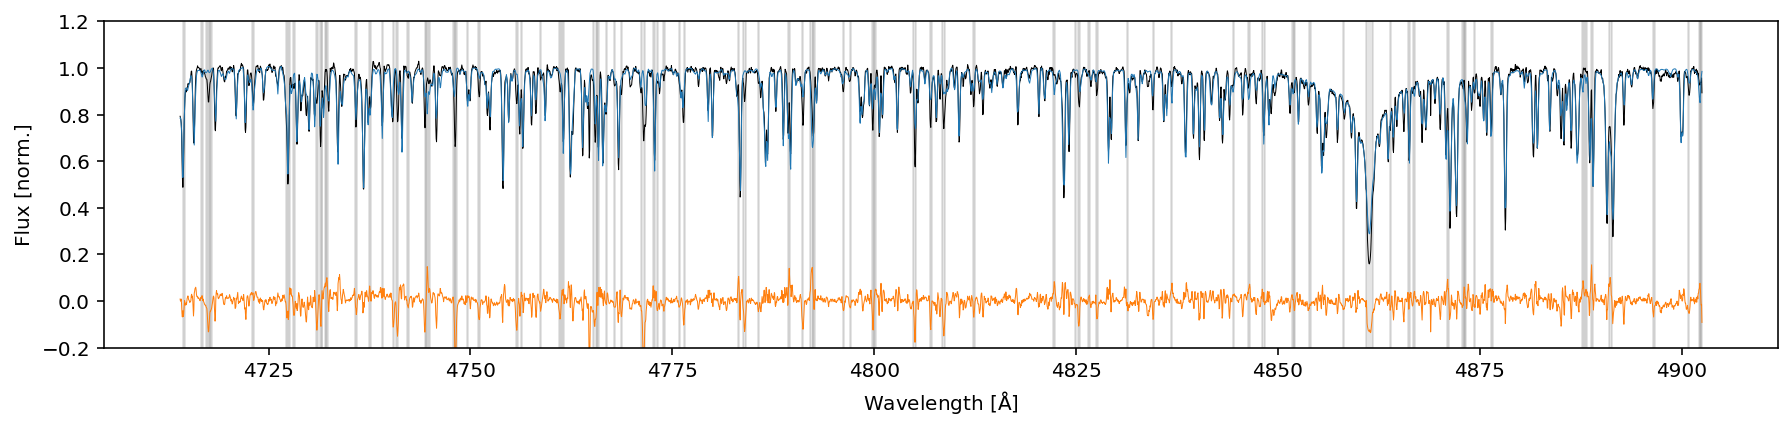

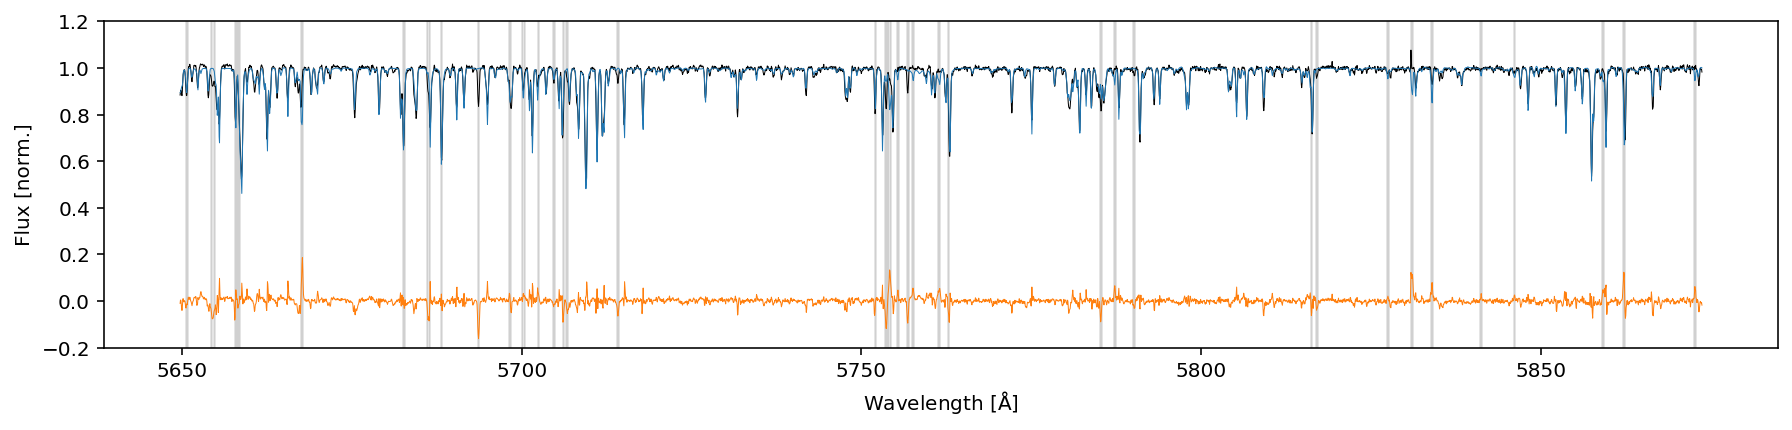

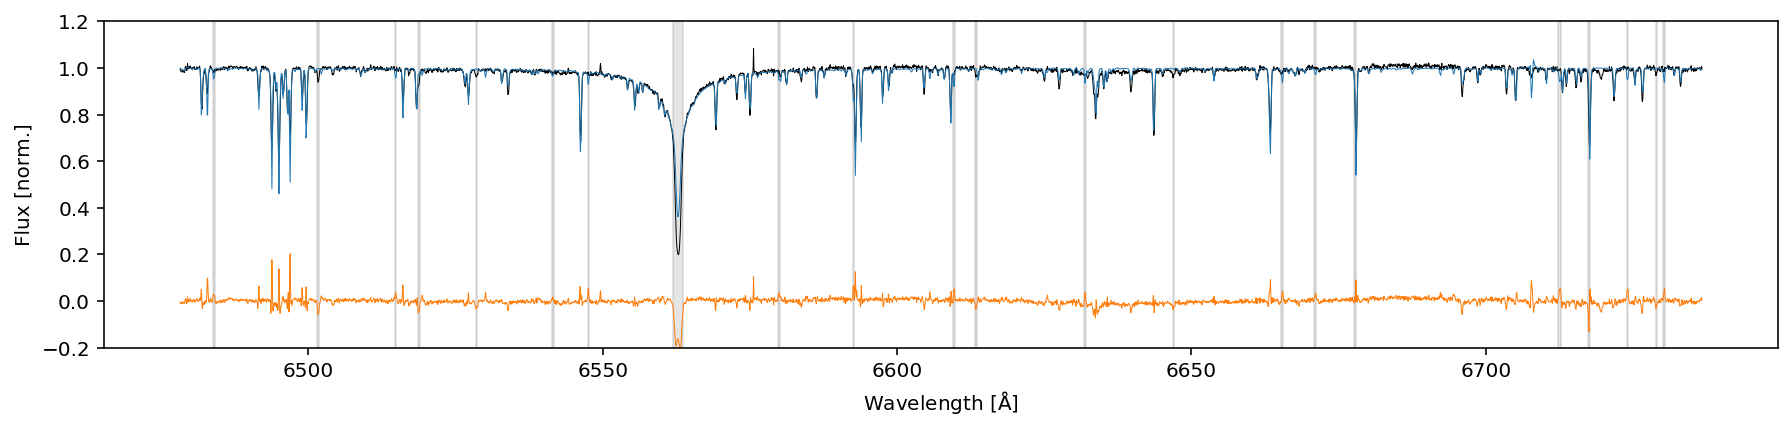

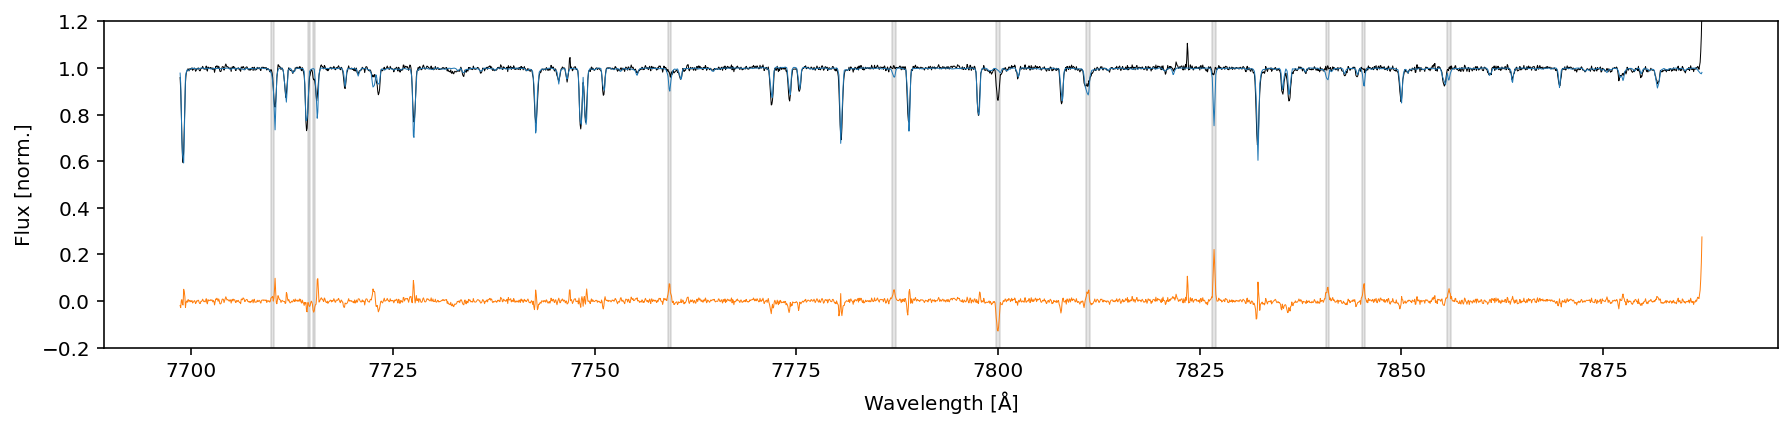

In [102]:
spectroscopic_log_likelihood(
    minisation.x, 
    model_labels, 
    spectrum, masks, default_model, default_model_name, debug=True)

1636355670.427208
reading in cannon model 0.02041912078857422
interpolation onto equidistant wavelength grid ccd1 0.03318905830383301 0.012769937515258789
degrade flux ccd1 0.08202409744262695 0.048835039138793945
degrade sigma ccd1 0.1213538646697998 0.03932976722717285
interpolation on observed wavelength ccd1 0.13002705574035645 0.00867319107055664
renormalisation ccd1 0.13895297050476074 0.008925914764404297
interpolation onto equidistant wavelength grid ccd2 0.23401904106140137 0.09506607055664062
degrade flux ccd2 0.2693901062011719 0.03537106513977051
degrade sigma ccd2 0.3122410774230957 0.04285097122192383
interpolation on observed wavelength ccd2 0.32016706466674805 0.007925987243652344
renormalisation ccd2 0.32941102981567383 0.009243965148925781
interpolation onto equidistant wavelength grid ccd3 0.3844630718231201 0.05505204200744629
degrade flux ccd3 0.42357397079467773 0.03911089897155762
degrade sigma ccd3 0.4695460796356201 0.04597210884094238
interpolation on observed

array([ 5.67322864e-01,  3.18830050e-01,  2.26272185e-01, ...,
       -9.32494558e+01, -2.50404144e+02, -6.33094042e+02])

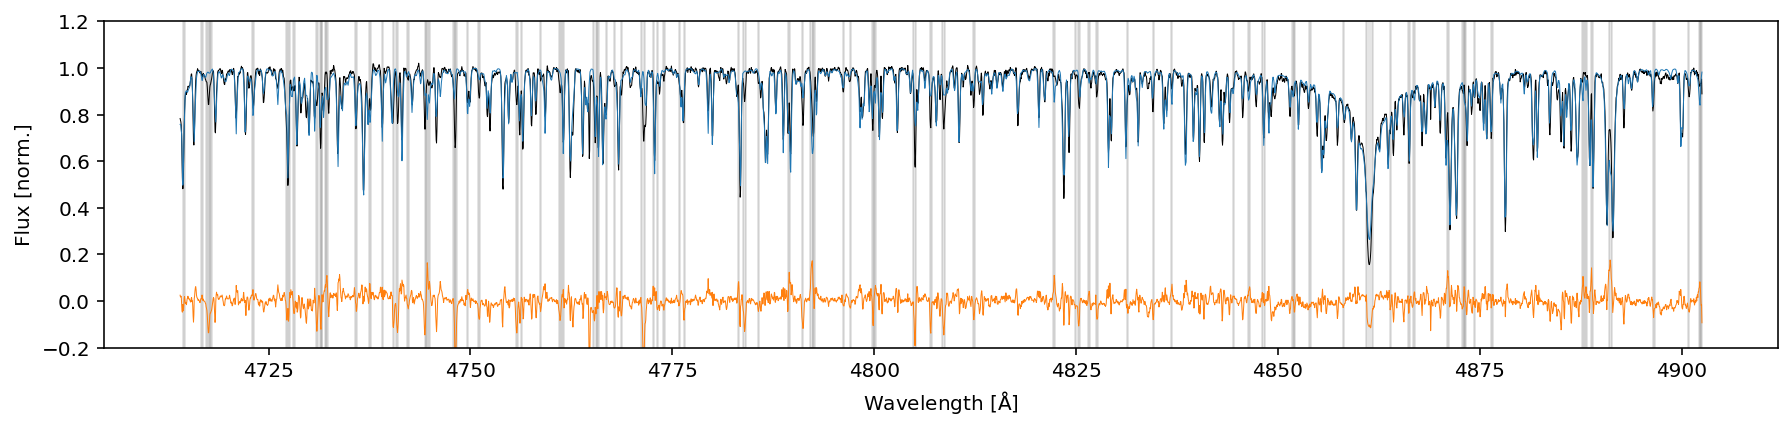

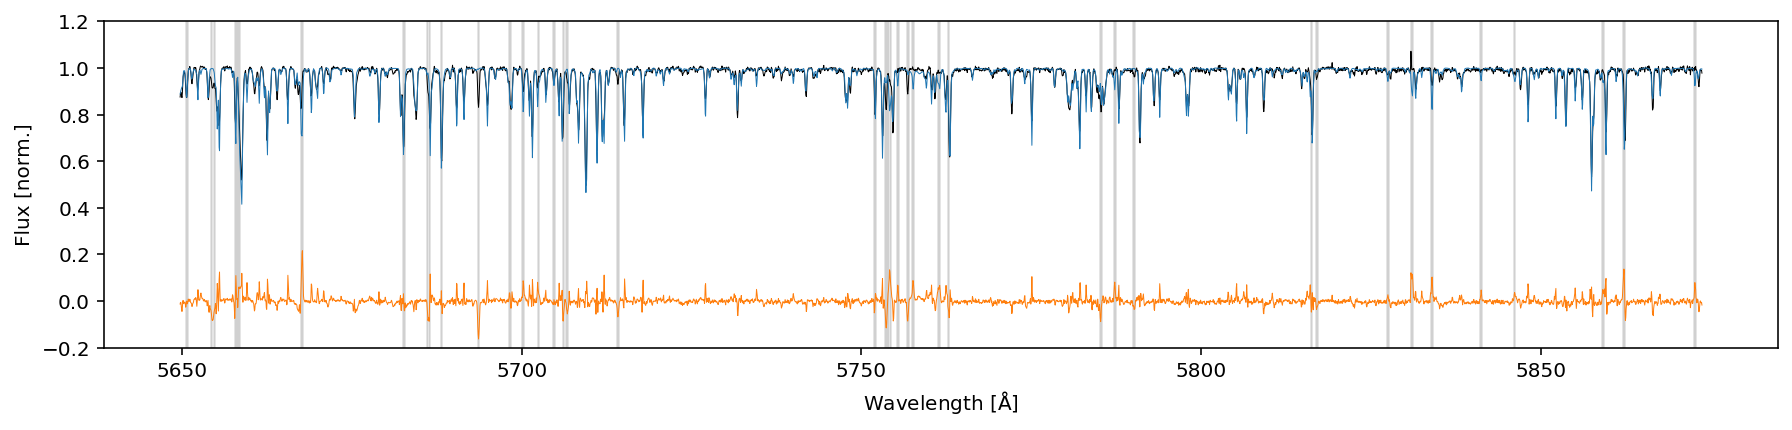

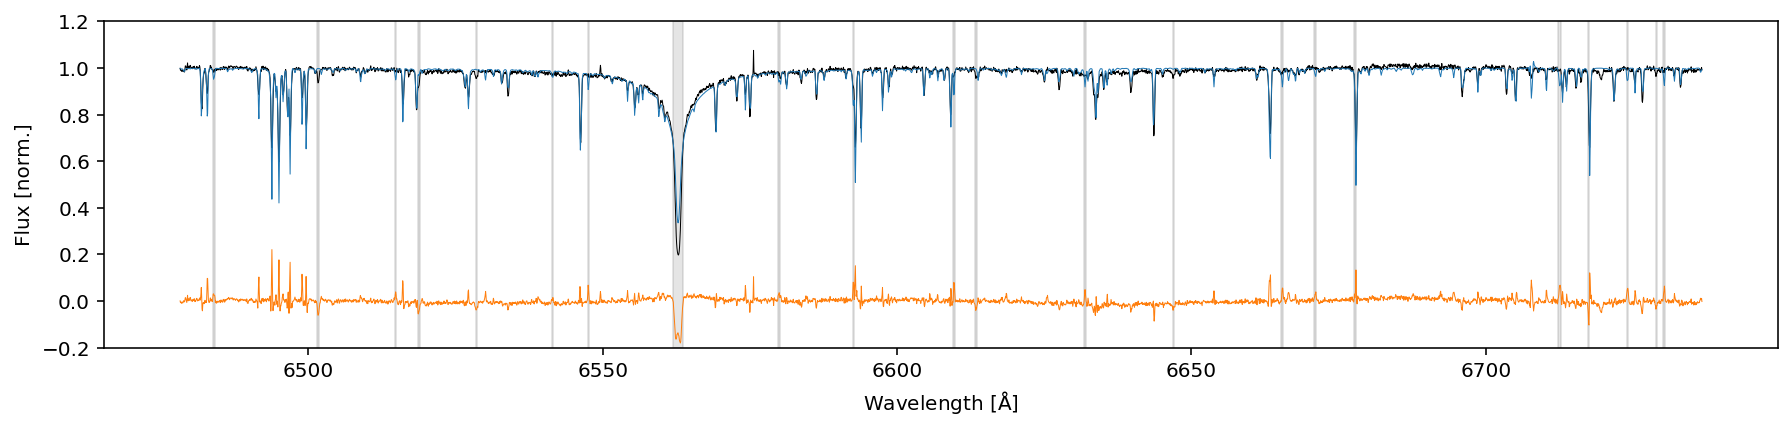

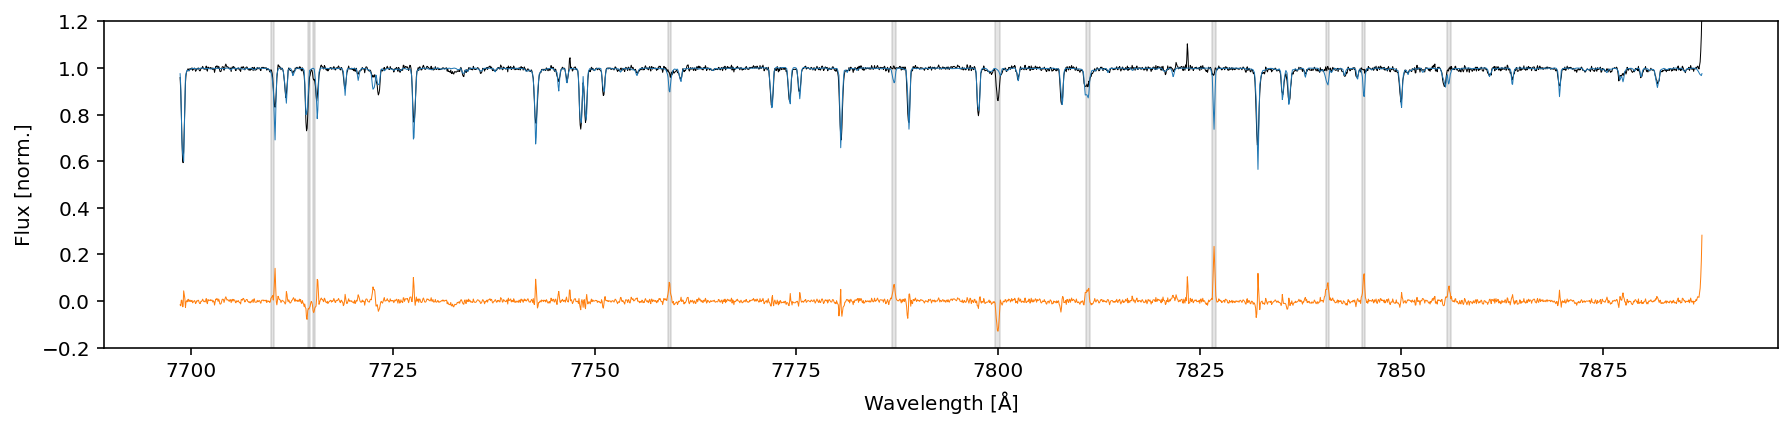

In [103]:
spectroscopic_log_likelihood(
    initial_model_parameters, 
    model_labels, 
    spectrum, masks, default_model, default_model_name, debug=True)

In [ ]:
logg_sampling = np.linspace(
    #1.5,4.5,25
    0.0,4.5,25
)

# log_p_spa = np.array([
#     log_probability(
#     model_parameters = [
#         spectrum['init_vrad'],
#         spectrum['init_teff'],
#         logg,
#         spectrum['init_fe_h'],
#         spectrum['init_vmic'],
#         spectrum['init_vsini'],
#         ((1./non_spec_info['parallax'] * u.arcsec * u.pc).to(u.pc)).value,
#         0.0
#     ],
#     model_labels = np.array(['vrad','teff','logg','fe_h','vmic','vsini','distance','a_v']),
#     spectrum=spectrum,
#     masks=masks,
#     non_spec_info = non_spec_info,
#     use_spectroscopy = True,
#     use_photoastrometry = True,
#     use_asteroseismology = True
# ) for logg in logg_sampling
# ])

# log_p_sp = np.array([
#     log_probability(
#     model_parameters = [
#         spectrum['init_vrad'],
#         spectrum['init_teff'],
#         logg,
#         spectrum['init_fe_h'],
#         spectrum['init_vmic'],
#         spectrum['init_vsini'],
#         ((1./non_spec_info['parallax'] * u.arcsec * u.pc).to(u.pc)).value,
#         0.0
#     ],
#     model_labels = np.array(['vrad','teff','logg','fe_h','vmic','vsini','distance','a_v']),
#     spectrum=spectrum,
#     masks=masks,
#     non_spec_info = non_spec_info,
#     use_spectroscopy = True,
#     use_photoastrometry = True,
#     use_asteroseismology = False
# ) for logg in logg_sampling
# ])

# log_p_sa = np.array([
#     log_probability(
#     model_parameters = [
#         spectrum['init_vrad'],
#         spectrum['init_teff'],
#         logg,
#         spectrum['init_fe_h'],
#         spectrum['init_vmic'],
#         spectrum['init_vsini'],
#         ((1./non_spec_info['parallax'] * u.arcsec * u.pc).to(u.pc)).value,
#         0.0
#     ],
#     model_labels = np.array(['vrad','teff','logg','fe_h','vmic','vsini','distance','a_v']),
#     spectrum=spectrum,
#     masks=masks,
#     non_spec_info = non_spec_info,
#     use_spectroscopy = True,
#     use_photoastrometry = False,
#     use_asteroseismology = True
# ) for logg in logg_sampling
# ])

# log_p_pa = np.array([
#     log_probability(
#     model_parameters = [
#         spectrum['init_vrad'],
#         spectrum['init_teff'],
#         logg,
#         spectrum['init_fe_h'],
#         spectrum['init_vmic'],
#         spectrum['init_vsini'],
#         ((1./non_spec_info['parallax'] * u.arcsec * u.pc).to(u.pc)).value,
#         0.0
#     ],
#     model_labels = np.array(['vrad','teff','logg','fe_h','vmic','vsini','distance','a_v']),
#     spectrum=spectrum,
#     masks=masks,
#     non_spec_info = non_spec_info,
#     use_spectroscopy = False,
#     use_photoastrometry = True,
#     use_asteroseismology = True
# ) for logg in logg_sampling
# ])

# log_p_s = np.array([
#     log_probability(
#     model_parameters = [
#         spectrum['init_vrad'],
#         spectrum['init_teff'],
#         logg,
#         spectrum['init_fe_h'],
#         spectrum['init_vmic'],
#         spectrum['init_vsini'],
#         ((1./non_spec_info['parallax'] * u.arcsec * u.pc).to(u.pc)).value,
#         0.0
#     ],
#     model_labels = np.array(['vrad','teff','logg','fe_h','vmic','vsini','distance','a_v']),
#     spectrum=spectrum,
#     masks=masks,
#     non_spec_info = non_spec_info,
#     use_spectroscopy = True,
#     use_photoastrometry = False,
#     use_asteroseismology = False
# ) for logg in logg_sampling
# ])

# log_p_p = np.array([
#     log_probability(
#     model_parameters = [
#         spectrum['init_vrad'],
#         spectrum['init_teff'],
#         logg,
#         spectrum['init_fe_h'],
#         spectrum['init_vmic'],
#         spectrum['init_vsini'],
#         ((1./non_spec_info['parallax'] * u.arcsec * u.pc).to(u.pc)).value,
#         0.0
#     ],
#     model_labels = np.array(['vrad','teff','logg','fe_h','vmic','vsini','distance','a_v']),
#     spectrum=spectrum,
#     masks=masks,
#     non_spec_info = non_spec_info,
#     use_spectroscopy = False,
#     use_photoastrometry = True,
#     use_asteroseismology = False
# ) for logg in logg_sampling
# ])

# log_p_a = np.array([
#     log_probability(
#     model_parameters = [
#         spectrum['init_vrad'],
#         spectrum['init_teff'],
#         logg,
#         spectrum['init_fe_h'],
#         spectrum['init_vmic'],
#         spectrum['init_vsini'],
#         ((1./non_spec_info['parallax'] * u.arcsec * u.pc).to(u.pc)).value,
#         0.0
#     ],
#     model_labels = np.array(['vrad','teff','logg','fe_h','vmic','vsini','distance','a_v']),
#     spectrum=spectrum,
#     masks=masks,
#     non_spec_info = non_spec_info,
#     use_spectroscopy = False,
#     use_photoastrometry = False,
#     use_asteroseismology = True
# ) for logg in logg_sampling
# ])

In [ ]:
logg_below_value = (logg_sampling < 5)

f, gs = plt.subplots(2,4,figsize=(12,8),sharex=True)

# ax = gs[0,0]
# ax.plot(
#     logg_sampling,
#     log_p_spa,
#     label='$\ln(P)$ S+P+A'
# )
# ax.legend()
# ax.set_ylabel('$\ln(P)$')

# ax = gs[0,1]
# ax.plot(
#     logg_sampling,
#     log_p_sp,
#     label='$\ln(P)$ spec+photo'
# )
# ax.legend()

ax = gs[0,2]
ax.plot(
    logg_sampling,
    log_p_sa,
    label='$\ln(P)$ spec+astero'
)
ax.legend()

# ax = gs[0,3]
# ax.plot(
#     logg_sampling[logg_below_value],
#     log_p_pa[logg_below_value],
#     label='$\ln(P)$ photo+astero'
# )
# ax.legend()
# ax.set_xlabel('$\ln (g~/~\mathrm{cm\,s^{-2}})$')
# ax.set_ylabel('$\ln(P)$')

ax = gs[1,0]
ax.plot(
    logg_sampling,
    log_p_s,
    label='$\ln(P)$ spec'
)
ax.legend()
ax.set_xlabel('$\ln (g~/~\mathrm{cm\,s^{-2}})$')
ax.set_ylabel('$\ln(P)$')

# ax = gs[1,1]
# ax.plot(
#     logg_sampling,
#     log_p_p,
#     label='$\ln(P)$ photo'
# )
# ax.legend()
# ax.set_xlabel('$\ln (g~/~\mathrm{cm\,s^{-2}})$')

ax = gs[1,2]
ax.plot(
    logg_sampling[logg_below_value],
    log_p_a[logg_below_value],
    label='$\ln(P)$ astero'
)
ax.set_ylim(2*np.median(log_p_a[logg_below_value]),0)
ax.legend()
ax.set_xlabel('$\ln (g~/~\mathrm{cm\,s^{-2}})$')

plt.tight_layout()

# Optimisation

In [48]:
number_steps = 500
step_burnin = int(number_steps/5)

In [35]:
start = time.time()
log_probability(
    initial_model_parameters,
    model_labels, spectrum, masks, non_spec_info, True, False, False, default_model, default_model_name, debug=False
)
print('full time: ',time.time()-start)
#1.08s with reading in Cannon spectrum & debug
#0.70s with reading in Cannon spectrum, without debug
#0.69s without reading in Cannon spectrum, with debug
#0.33s without reading in Cannon spectrum, without debug


full time:  0.3057730197906494


In [ ]:
# Initialize the walkers
coords = initial_model_parameters + 1e-1 * np.random.randn(5*len(model_labels), len(model_labels))
nwalkers, ndim = coords.shape

# Set up the backend
# Don't forget to clear it in case the file already exists
file_directory = working_directory+'/analysis_products/diagnostic_plots/'+str(spectrum['sobject_id'])[:6]+'/mcmc/'
Path(file_directory).mkdir(parents=True, exist_ok=True)

backend = emcee.backends.HDFBackend(file_directory+str(spectrum['sobject_id'])+'_sample.h5')
backend.reset(nwalkers, ndim)

# Walk that walk
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(model_labels, spectrum, masks, non_spec_info, True, True, True),
    backend=backend
)

sampler.run_mcmc(pos, number_steps, progress=True);

In [ ]:
print('checkout more: https://emcee.readthedocs.io/en/stable/tutorials/monitor/')

In [ ]:
# max_n = 100000

# # We'll track how the average autocorrelation time estimate changes
# index = 0
# autocorr = np.empty(max_n)

# # This will be useful to testing convergence
# old_tau = np.inf

# # Now we'll sample for up to max_n steps
# for sample in sampler.sample(coords, iterations=max_n, progress=True):
#     # Only check convergence every 100 steps
#     if sampler.iteration % 100:
#         continue

#     # Compute the autocorrelation time so far
#     # Using tol=0 means that we'll always get an estimate even
#     # if it isn't trustworthy
#     tau = sampler.get_autocorr_time(tol=0)
#     autocorr[index] = np.mean(tau)
#     index += 1

#     # Check convergence
#     converged = np.all(tau * 100 < sampler.iteration)
#     converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
#     if converged:
#         break
#     old_tau = tau

In [ ]:
file_directory = working_directory+'/analysis_products/diagnostic_plots/'+str(spectrum['sobject_id'])[:6]+'/mcmc/'
Path(file_directory).mkdir(parents=True, exist_ok=True)

fig, axes = plt.subplots(len(model_labels), figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.axvline(step_burnin)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(model_labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.savefig(file_directory+'/mcmc_chain_'+str(spectrum['sobject_id'])+'.png',bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
try:
    tau = sampler.get_autocorr_time()
except Exception as exc:
    print(exc)
    pass

In [ ]:
try:
    tau = sampler.get_autocorr_time()
    burnin = int(2 * np.max(tau))
    thin = int(0.5 * np.min(tau))
    samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)
    log_prob_samples = sampler.get_log_prob(discard=burnin, flat=True, thin=thin)
    log_prior_samples = sampler.get_blobs(discard=burnin, flat=True, thin=thin)
    
    print("burn-in: {0}".format(burnin))
    print("thin: {0}".format(thin))
    print("flat chain shape: {0}".format(samples.shape))
    print("flat log prob shape: {0}".format(log_prob_samples.shape))
    print("flat log prior shape: {0}".format(log_prior_samples.shape))

    all_samples = np.concatenate(
        (samples, log_prob_samples[:, None], log_prior_samples[:, None]), axis=1
    )

    labels = list(map(r"$\theta_{{{0}}}$".format, range(1, ndim + 1)))
    labels += ["log prob", "log prior"]

    corner.corner(all_samples, labels=labels);
except:
    pass

In [ ]:
flat_samples = sampler.get_chain(discard=step_burnin, thin=1, flat=True)
print(flat_samples.shape)

In [ ]:
flat_samples

In [ ]:
np.save(file_directory+'samples_'+str(spectrum['sobject_id'])+'.npy',flat_samples)

In [ ]:
file_directory = working_directory+'/analysis_products/diagnostic_plots/'+str(spectrum['sobject_id'])[:6]+'/mcmc/'
Path(file_directory).mkdir(parents=True, exist_ok=True)

fig = corner.corner(
    flat_samples, labels=model_labels, truths=initial_model_parameters
);
plt.savefig(file_directory+'/mcmc_corner_'+str(spectrum['sobject_id'])+'.png',bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
log_probability(
    np.median(flat_samples,axis=0),
    model_labels, spectrum, masks, non_spec_info, True, True, True, True
)

In [ ]:
output = Table()

file_directory = working_directory+'/analysis_products/fitting_output/'+str(spectrum['sobject_id'])[:6]+'/'
Path(file_directory).mkdir(parents=True, exist_ok=True)

for label in ['sobject_id','tmass_id','gaia_edr3_source_id']:
    col = Table.Column(
        name=label,
        data = [spectrum[label]],
        description=description[label],
        unit=units[label])
    output.add_column(col)

for label_index, label in enumerate(model_labels):
    percentiles = np.percentile(flat_samples[:, label_index], [16, 50, 84])
    col = Table.Column(
        name=label,
        data = [np.float32(percentiles[1])],
        description=description[label],
        unit=units[label])
    output.add_column(col)
    col = Table.Column(
        name=label+'_16',
        data = [np.float32(percentiles[1]-percentiles[0])],
        description='Difference to 16th percentile of '+description[label],
        unit=units[label])
    output.add_column(col)
    col = Table.Column(
        name=label+'_84',
        data = [np.float32(percentiles[2]-percentiles[1])],
        description='Difference to 84th percentile of '+description[label],
        unit=units[label])
    output.add_column(col)

output.write(file_directory+str(spectrum['sobject_id'])+'_logL_maximisation_results.fits',overwrite=True)

In [ ]:
output

In [ ]:
log_probability(
    np.median(flat_samples,axis=0),
    model_labels, spectrum, masks, non_spec_info, True, True, True, True
)

In [ ]:
np.median(flat_samples,axis=0)

In [ ]:
# def fit_leastsq(initial_model_parameters, model_labels, spectrum, masks, debug=False):

#     def residuals_for_leastsq(parameters):

#         print(parameters)
#         (wave,data,sigma2,model,s2) = match_observation_and_model(model_parameters=parameters, model_labels=model_labels, spectrum=spectrum, masks=masks, debug=False)
#         masked = np.any(np.array([((wave >= mask_beginning) & (wave <= mask_end)) for (mask_beginning, mask_end) in masks]),axis=0)
        
#         adjusted_sigma = sigma2 + s2
#         adjusted_sigma[masked] = 100000.
        
#         return (model - data)/np.sqrt(adjusted_sigma)
    
#     kwds = {
#             "func": residuals_for_leastsq,
#             "Dfun": None,
#             "col_deriv": True,

#             # These get passed through to leastsq:
#             "ftol": 7./3 - 4./3 - 1, # Machine precision.
#             "xtol": 7./3 - 4./3 - 1, # Machine precision.
#             "gtol": 0.0,
#             "maxfev": 100000, # MAGIC
#             "epsfcn": None,
#             "factor": 1.0,
#         }

#     op_labels, cov, meta, mesg, ier = op.leastsq(
#         x0 = initial_model_parameters,
#         full_output=True,**kwds
#     )
    
#     return(op_labels, cov, meta, mesg, ier)

# start_time = time.time()
# initial_model_parameters = [
#     spectrum['init_vrad'],
#     spectrum['init_teff'],
#     spectrum['init_logg'],
#     spectrum['init_fe_h'],
#     spectrum['init_vmic'],
#     0.0,
#     0.0
# ]
# model_labels=np.array(['vrad','teff','logg','fe_h','vmic','li_fe','k_fe'])
# op_labels, cov, meta, mesg, ier = fit_leastsq(initial_model_parameters, model_labels, spectrum, masks, debug=False)
# print(time.time() - start_time)
# # 31s for 47 calls for 4 parameters
# # 259s for 6 parameters
# # 118s for 11 parameters

In [ ]:
op_labels

In [ ]:
outcome = Table()
for each_index, label in enumerate(model_labels):
    outcome[label] = [op_labels[each_index]]
outcome